In [4]:
import torch

In [5]:
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to float64
torch.set_default_dtype(torch.float64)

In [15]:
import importlib
import utils

# After making changes to the GittinsIndex class in PandoraBayesOPT.acquisition module

# Reload the module
importlib.reload(utils)

# Re-import GittinsIndex from the reloaded module
from utils import fit_gp_model

In [2]:
from acquisition import GittinsIndex

In [11]:
import torch
from gpytorch.kernels import MaternKernel, ScaleKernel
from botorch.utils.gp_sampling import get_deterministic_model, RandomFourierFeatures

def create_objective_model(num_dimensions, lengthscale, outputscale, nu=0.5, num_rff_features=1280, seed=42):
    """
    Create and return the objective model for sampling from a Matern kernel.

    Parameters:
    - num_dimensions (int): Number of dimensions of the sample space.
    - lengthscale (float): Lengthscale parameter for the Matern kernel.
    - outputscale (float): Outputscale parameter for the Matern kernel.
    - nu (float): Smoothness parameter for the Matern kernel. Default is 0.5.
    - num_rff_features (int): Number of random Fourier features. Default is 1280.
    - seed (int): Random seed for reproducibility. Default is 42.

    Returns:
    - objective_model: The model used to evaluate the objective function.
    """
    # Set the seed for reproducibility
    torch.manual_seed(seed)

    # Set up the Matern kernel
    base_kernel = MaternKernel(nu=nu).double()
    base_kernel.lengthscale = torch.tensor([[lengthscale]], dtype=torch.float64)
    scale_kernel = ScaleKernel(base_kernel).double()
    scale_kernel.outputscale = torch.tensor([[outputscale]], dtype=torch.float64)

    # Random Fourier Features
    rff = RandomFourierFeatures(
        kernel=scale_kernel,
        input_dim=num_dimensions,
        num_rff_features=num_rff_features
    )

    # Generate weights for the Random Fourier Features
    weights = torch.randn(num_rff_features, dtype=torch.float64)
    objective_model = get_deterministic_model(weights=[weights], bases=[rff])

    return objective_model

In [12]:
def objective(X, objective_model):
    """
    Evaluate the objective function using the provided model.

    Parameters:
    - X (Tensor): Input points where the objective function should be evaluated.
    - objective_model: The model used to evaluate the objective function.

    Returns:
    - Tensor: Evaluated mean of the model's posterior.
    """
    return objective_model.posterior(X).mean.detach()

In [13]:
# Create the objective model
num_dimensions = 1
lengthscale = 1/16
outputscale = 2.0
objective_model = create_objective_model(num_dimensions, lengthscale, outputscale)

# Use the objective function
# For example, evaluating at some sample points
# Number of sample points along the line
num_points = 1000

# Create a tensor of evenly spaced points between 0 and 1
sample_x = torch.linspace(0, 1, num_points, dtype=torch.float64)

# Evaluate the objective function at these points
sample_y = objective(sample_x.view(-1, 1), objective_model)

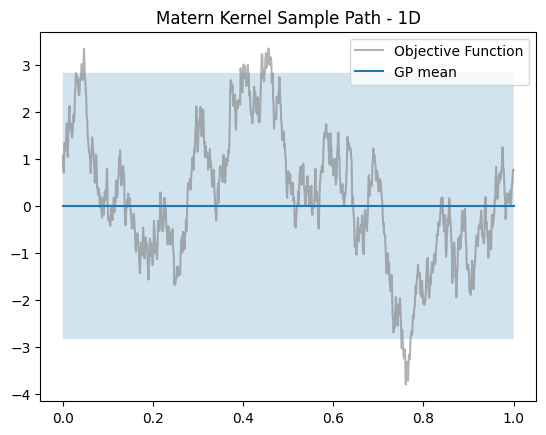

In [14]:
# Example Usage for 1D: 
prior_mean = torch.zeros(num_points_per_dim)
prior_std = torch.ones(num_points_per_dim)*np.sqrt(outputscale)
plot_matern_sample_path(sample_x, sample_y, 1, num_points_per_dim, prior_mean, prior_std)

In [15]:
# Example Usage for 2D: 

# Create the objective model
num_dimensions = 2
lengthscale = 1/16
outputscale = 2.0
objective_model = create_objective_model(num_dimensions, lengthscale, outputscale)

# Use the objective function
# For example, evaluating at some sample points
sample_points = torch.rand(10, num_dimensions)  # Random sample points
sample_values = objective(sample_points, objective_model)

In [16]:
sample_points

tensor([[0.6915, 0.7774],
        [0.0647, 0.5680],
        [0.4410, 0.9798],
        [0.6421, 0.2756],
        [0.3407, 0.9079],
        [0.3521, 0.5929],
        [0.9374, 0.0581],
        [0.4590, 0.0492],
        [0.3481, 0.6834],
        [0.5003, 0.7479]])

In [17]:
sample_values

tensor([[ 0.4656],
        [ 0.8956],
        [-0.7537],
        [-0.9810],
        [ 1.1253],
        [ 1.5760],
        [ 1.5197],
        [-1.0257],
        [ 3.2832],
        [-0.6463]], dtype=torch.float64)

In [67]:
from bayesianoptimizer import BayesianOptimizer

In [82]:
dim = 1
maximize = False
seed = 0
num_iterations = 24

In [83]:
# Create an instance of BayesianOptimizer
EI_optimizer = BayesianOptimizer(objective, dim=dim, maximize=maximize, seed=seed, nu=nu, lengthscale=lengthscale, outputscale=outputscale)

# Run the optimization
EI_optimizer.run(num_iterations=num_iterations, acquisition_function_class=ExpectedImprovement)

EI_best_history = EI_optimizer.get_best_history()

# Retrieve the cumulative cost
EI_cost_history = EI_optimizer.get_cost_history()

Iteration 0, New point: 0.9137180502061613, New value: -1.2973766789082257
Best observed value: -1.2973766789082257
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.2973766789082257
Cumulative cost: 2

Iteration 2, New point: 0.8567102706216227, New value: 0.06079542671945272
Best observed value: -1.2973766789082257
Cumulative cost: 3

Iteration 3, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.2973766789082257
Cumulative cost: 4

Iteration 4, New point: 0.9237245779906536, New value: -0.33353673608374235
Best observed value: -1.2973766789082257
Cumulative cost: 5

Iteration 5, New point: 0.9046017853155822, New value: -1.9130399689092112
Best observed value: -1.9130399689092112
Cumulative cost: 6

Iteration 6, New point: 0.899376421427631, New value: -1.127307670063332
Best observed value: -1.9130399689092112
Cumulative cost: 7

Iteration 7, New point: 0.7518302239014018, New value: -3.017389435408361
Best obs

In [84]:
# Example usage with GittinsIndex
GI_optimizer = BayesianOptimizer(objective, dim=dim, maximize=maximize, seed=seed)
GI_optimizer.run(num_iterations=num_iterations, acquisition_function_class=GittinsIndex, lmbda=0.005)

GI_best_history = GI_optimizer.get_best_history()

# Retrieve the cumulative cost
GI_cost_history = GI_optimizer.get_cost_history()

Iteration 0, New point: 0.7738861176598509, New value: -2.655980582039869
Best observed value: -2.655980582039869
Cumulative cost: 1

Iteration 1, New point: 0.9330104709951651, New value: -0.7921004656594144
Best observed value: -2.655980582039869
Cumulative cost: 2

Iteration 2, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.655980582039869
Cumulative cost: 3

Iteration 3, New point: 0.841964937047658, New value: 0.17601330857393105
Best observed value: -2.655980582039869
Cumulative cost: 4

Iteration 4, New point: 0.7167505816760877, New value: -1.1135747897612456
Best observed value: -2.655980582039869
Cumulative cost: 5

Iteration 5, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.655980582039869
Cumulative cost: 6

Iteration 6, New point: 0.21307785428414544, New value: -0.43838944000551816
Best observed value: -2.655980582039869
Cumulative cost: 7

Iteration 7, New point: 0.7523914685911071, New value: -2.670148514805442
Best observed 

Text(0.5, 1.0, 'Performance of EI vs Gittins on 1D Matern12')

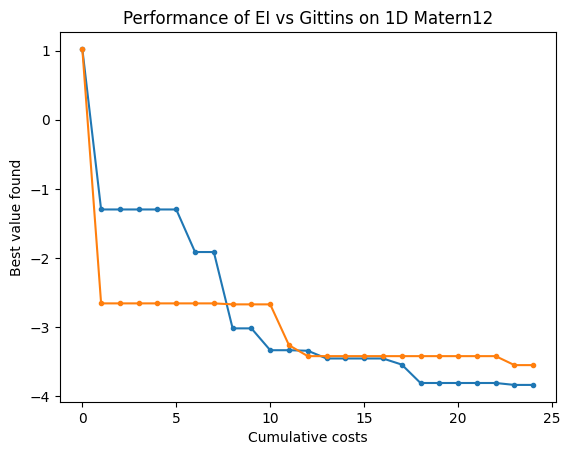

In [85]:
plt.plot(EI_cost_history, EI_best_history,'.-')
plt.plot(GI_cost_history, GI_best_history,'.-')
plt.xlabel('Cumulative costs')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins on 1D Matern12")

In [87]:
lmbda_values = [0.1, 0.05, 0.01, 0.005, 0.001]
num_trials = 30  # Number of trials for each lmbda
num_iterations = 24  # Budget for cumulative cost

EI_best_histories = []
EI_cost_histories = []

GI_best_histories = {lmbda: [] for lmbda in lmbda_values}
GI_cost_histories = {lmbda: [] for lmbda in lmbda_values}

for trial in range(num_trials):
    
    seed = trial
    
    print("seed:", seed)
    
    # Run trial with ExpectedImprovement
    EI_optimizer = BayesianOptimizer(objective, dim=dim, maximize=maximize, seed=seed)
    EI_optimizer.run(num_iterations=num_iterations, acquisition_function_class=ExpectedImprovement)
    EI_best_histories.append(EI_optimizer.get_best_history())
    EI_cost_histories.append(EI_optimizer.get_cost_history())

    for lmbda in lmbda_values:
        print("lmbda:", lmbda)

        # Run trial with GittinsIndex for the current lambda
        GI_optimizer = BayesianOptimizer(objective, dim=dim, maximize=maximize, seed=seed)
        GI_optimizer.run(num_iterations=num_iterations, acquisition_function_class=GittinsIndex, lmbda=lmbda)
        GI_best_histories[lmbda].append(GI_optimizer.get_best_history())
        GI_cost_histories[lmbda].append(GI_optimizer.get_cost_history())
        print()
    print()

seed: 0
Iteration 0, New point: 0.5289659091541931, New value: 0.7905801153155068
Best observed value: 0.7905801153155068
Cumulative cost: 1

Iteration 1, New point: 0.6747769417240215, New value: -0.5462896345015542
Best observed value: -0.5462896345015542
Cumulative cost: 2

Iteration 2, New point: 0.7288412765294177, New value: -1.6361572451978845
Best observed value: -1.6361572451978845
Cumulative cost: 3

Iteration 3, New point: 0.8022856834216485, New value: -2.2350193081814953
Best observed value: -2.2350193081814953
Cumulative cost: 4

Iteration 4, New point: 0.89579667831591, New value: -1.2973083543286994
Best observed value: -2.2350193081814953
Cumulative cost: 5

Iteration 5, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.2350193081814953
Cumulative cost: 6

Iteration 6, New point: 0.8386238840716335, New value: 0.15295521495128772
Best observed value: -2.2350193081814953
Cumulative cost: 7

Iteration 7, New point: 0.7776503137979172, New value: -2.43

Iteration 13, New point: 0.7548798872543504, New value: -3.145984198368329
Best observed value: -3.6605929537082513
Cumulative cost: 14

Iteration 14, New point: 0.7475353556182472, New value: -2.0134657775435088
Best observed value: -3.6605929537082513
Cumulative cost: 15

Iteration 15, New point: 0.7657634076254058, New value: -3.7169060761456443
Best observed value: -3.7169060761456443
Cumulative cost: 16

Iteration 16, New point: 0.7658630487678033, New value: -3.6177970395382584
Best observed value: -3.7169060761456443
Cumulative cost: 17

Iteration 17, New point: 0.7572473833298443, New value: -3.081341533299411
Best observed value: -3.7169060761456443
Cumulative cost: 18

Iteration 18, New point: 0.7518176694727579, New value: -3.020251366827855
Best observed value: -3.7169060761456443
Cumulative cost: 19

Iteration 19, New point: 0.7317676925219074, New value: -2.378637629739968
Best observed value: -3.7169060761456443
Cumulative cost: 20

Iteration 20, New point: 0.79981489589

Iteration 2, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.1177228273354127
Cumulative cost: 3

Iteration 3, New point: 0.8454539762190234, New value: -0.6450967871760627
Best observed value: -2.1177228273354127
Cumulative cost: 4

Iteration 4, New point: 0.7131267568729763, New value: -0.5125149829308551
Best observed value: -2.1177228273354127
Cumulative cost: 5

Iteration 5, New point: 0.20339910060992367, New value: -0.5919714834800456
Best observed value: -2.1177228273354127
Cumulative cost: 6

Iteration 6, New point: 0.29185466464392096, New value: 1.262884575225892
Best observed value: -2.1177228273354127
Cumulative cost: 7

Iteration 7, New point: 0.12521410519488801, New value: 1.0308840458594244
Best observed value: -2.1177228273354127
Cumulative cost: 8

Iteration 8, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.1177228273354127
Cumulative cost: 9

Iteration 9, New point: 0.754290954665071, New value: -2.9244605923947553
Best ob

Iteration 15, New point: 0.7406595802113197, New value: -2.3855677876140295
Best observed value: -2.420276729535695
Cumulative cost: 16

Iteration 16, New point: 0.7503242553489481, New value: -2.7465872646028453
Best observed value: -2.7465872646028453
Cumulative cost: 17

Iteration 17, New point: 0.7593800652285957, New value: -3.3135565495699337
Best observed value: -3.3135565495699337
Cumulative cost: 18

Iteration 18, New point: 0.7673301391467175, New value: -3.211586835648416
Best observed value: -3.3135565495699337
Cumulative cost: 19

Iteration 19, New point: 0.7629827225471533, New value: -3.2701675599468047
Best observed value: -3.3135565495699337
Cumulative cost: 20

Iteration 20, New point: 0.7596292568592332, New value: -3.331071235038883
Best observed value: -3.331071235038883
Cumulative cost: 21

Iteration 21, New point: 0.7601334282315144, New value: -3.356003121229401
Best observed value: -3.356003121229401
Cumulative cost: 22

Iteration 22, New point: 0.7772931180971

Iteration 3, New point: 0.16299999281037866, New value: -0.7399305587147912
Best observed value: -1.4219578572692428
Cumulative cost: 4

Iteration 4, New point: 0.8511608874084434, New value: -0.8907693412845723
Best observed value: -1.4219578572692428
Cumulative cost: 5

Iteration 5, New point: 0.557425113354016, New value: -0.06272334104483301
Best observed value: -1.4219578572692428
Cumulative cost: 6

Iteration 6, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.4219578572692428
Cumulative cost: 7

Iteration 7, New point: 0.7768604752292403, New value: -2.31377143694805
Best observed value: -2.31377143694805
Cumulative cost: 8

Iteration 8, New point: 0.763373777243864, New value: -3.3121450941411545
Best observed value: -3.3121450941411545
Cumulative cost: 9

Iteration 9, New point: 0.7475871913866271, New value: -2.00502102586848
Best observed value: -3.3121450941411545
Cumulative cost: 10

Iteration 10, New point: 0.7602228290531043, New value: -3.3514142043

Iteration 17, New point: 0.7217793727335593, New value: -1.22540282303602
Best observed value: -3.611623517477158
Cumulative cost: 18

Iteration 18, New point: 0.8407493393171235, New value: -0.06832142343913528
Best observed value: -3.611623517477158
Cumulative cost: 19

Iteration 19, New point: 0.8078911352219975, New value: -1.1501499666218695
Best observed value: -3.611623517477158
Cumulative cost: 20

Iteration 20, New point: 0.8976301181347167, New value: -1.1969268279752783
Best observed value: -3.611623517477158
Cumulative cost: 21

Iteration 21, New point: 0.913473248632836, New value: -1.295459000760271
Best observed value: -3.611623517477158
Cumulative cost: 22

Iteration 22, New point: 0.9289947702853422, New value: -0.20622159907232396
Best observed value: -3.611623517477158
Cumulative cost: 23

Iteration 23, New point: 0.19996526295513198, New value: -1.311343288614133
Best observed value: -3.611623517477158
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 0.526608

Iteration 5, New point: 0.3434163104315014, New value: 0.34246038399353074
Best observed value: -2.450808453210639
Cumulative cost: 6

Iteration 6, New point: 0.7513590801699646, New value: -2.8854048103896903
Best observed value: -2.8854048103896903
Cumulative cost: 7

Iteration 7, New point: 0.7579448266443871, New value: -3.151842193493448
Best observed value: -3.151842193493448
Cumulative cost: 8

Iteration 8, New point: 0.21915311515880728, New value: -0.11306577556518171
Best observed value: -3.151842193493448
Cumulative cost: 9

Iteration 9, New point: 0.7629579552527957, New value: -3.2781614099453
Best observed value: -3.2781614099453
Cumulative cost: 10

Iteration 10, New point: 0.12351187621664178, New value: 0.7140093115360497
Best observed value: -3.2781614099453
Cumulative cost: 11

Iteration 11, New point: 0.7640947383455777, New value: -3.3608218556232767
Best observed value: -3.3608218556232767
Cumulative cost: 12

Iteration 12, New point: 0.7691097547345881, New value

Iteration 17, New point: 0.2681311217578372, New value: -0.5591262626302123
Best observed value: -3.4237519891402943
Cumulative cost: 18

Iteration 18, New point: 0.18325000690425497, New value: -0.8475151756446104
Best observed value: -3.4237519891402943
Cumulative cost: 19

Iteration 19, New point: 0.8869237874892265, New value: -0.26255288586746856
Best observed value: -3.4237519891402943
Cumulative cost: 20

Iteration 20, New point: 0.3973549038499995, New value: 2.482932525857553
Best observed value: -3.4237519891402943
Cumulative cost: 21

Iteration 21, New point: 0.7599994160794953, New value: -3.3860253025315883
Best observed value: -3.4237519891402943
Cumulative cost: 22

Iteration 22, New point: 0.7705518586962158, New value: -3.1570111492657453
Best observed value: -3.4237519891402943
Cumulative cost: 23

Iteration 23, New point: 0.8163638539576579, New value: -1.5520096021195235
Best observed value: -3.4237519891402943
Cumulative cost: 24



seed: 3
Iteration 0, New point: 

/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Iteration 11, New point: 0.904973110703643, New value: -1.8535676861310741
Best observed value: -1.8535676861310741
Cumulative cost: 12

Iteration 12, New point: 0.9047044480208911, New value: -1.9088580753392825
Best observed value: -1.9088580753392825
Cumulative cost: 13

Iteration 13, New point: 0.899387596705842, New value: -1.1278364761160726
Best observed value: -1.9088580753392825
Cumulative cost: 14

Iteration 14, New point: 0.8929617100270378, New value: -0.47638735165113644
Best observed value: -1.9088580753392825
Cumulative cost: 15

Iteration 15, New point: 0.90451941589606, New value: -1.8654047573512471
Best observed value: -1.9088580753392825
Cumulative cost: 16

Iteration 16, New point: 0.9046475351983124, New value: -1.9116276585554326
Best observed value: -1.9116276585554326
Cumulative cost: 17

Iteration 17, New point: 0.9046375864404517, New value: -1.9159900588733136
Best observed value: -1.9159900588733136
Cumulative cost: 18

Iteration 18, New point: 0.9046346468

Iteration 23, New point: 0.7645690081292478, New value: -3.4208429404540155
Best observed value: -3.4647456385022752
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 0.4288316832225457, New value: 2.215294542046327
Best observed value: -0.23504525583013686
Cumulative cost: 1

Iteration 1, New point: 0.953724681012626, New value: -0.2999733936541811
Best observed value: -0.2999733936541811
Cumulative cost: 2

Iteration 2, New point: 0.8377170727293407, New value: -0.07980488618660164
Best observed value: -0.2999733936541811
Cumulative cost: 3

Iteration 3, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.2999733936541811
Cumulative cost: 4

Iteration 4, New point: 0.899468259819885, New value: -1.1750992312694684
Best observed value: -1.1750992312694684
Cumulative cost: 5

Iteration 5, New point: 0.5913860934130177, New value: 0.9320755343139977
Best observed value: -1.1750992312694684
Cumulative cost: 6

Iteration 6, New point: 0.2930343347610173, New val

Iteration 13, New point: 0.7623946919973381, New value: -3.4380566626159377
Best observed value: -3.4380566626159377
Cumulative cost: 14

Iteration 14, New point: 0.8284093548616123, New value: -0.8515550049938136
Best observed value: -3.4380566626159377
Cumulative cost: 15

Iteration 15, New point: 0.20590025493304026, New value: -1.0461802736879995
Best observed value: -3.4380566626159377
Cumulative cost: 16

Iteration 16, New point: 0.23588211869081493, New value: -0.5458801006976657
Best observed value: -3.4380566626159377
Cumulative cost: 17

Iteration 17, New point: 0.17541481037110437, New value: -0.9447748411438067
Best observed value: -3.4380566626159377
Cumulative cost: 18

Iteration 18, New point: 0.14183574041661162, New value: 0.08939271620376621
Best observed value: -3.4380566626159377
Cumulative cost: 19

Iteration 19, New point: 0.27961834442874556, New value: 0.4565580569081472
Best observed value: -3.4380566626159377
Cumulative cost: 20

Iteration 20, New point: 0.517

Iteration 2, New point: 0.7050003931241593, New value: 0.5577174466529571
Best observed value: -1.96149479470464
Cumulative cost: 3

Iteration 3, New point: 0.8741870007068171, New value: -1.7160670285894892
Best observed value: -1.96149479470464
Cumulative cost: 4

Iteration 4, New point: 0.8366097598800468, New value: -0.5193550476998086
Best observed value: -1.96149479470464
Cumulative cost: 5

Iteration 5, New point: 0.7733198073488704, New value: -2.5797002443663817
Best observed value: -2.5797002443663817
Cumulative cost: 6

Iteration 6, New point: 0.9219816176335432, New value: -0.4943994653094377
Best observed value: -2.5797002443663817
Cumulative cost: 7

Iteration 7, New point: 0.19893680855702994, New value: -1.2501808558104757
Best observed value: -2.5797002443663817
Cumulative cost: 8

Iteration 8, New point: 0.2645919744009853, New value: -0.7636762425034285
Best observed value: -2.5797002443663817
Cumulative cost: 9

Iteration 9, New point: 0.13314510635592072, New value

Iteration 15, New point: 0.5615356971034743, New value: 0.19532434528598752
Best observed value: -3.308723553172742
Cumulative cost: 16

Iteration 16, New point: 0.14335897076498663, New value: 0.12922969726745875
Best observed value: -3.308723553172742
Cumulative cost: 17

Iteration 17, New point: 0.619079070491098, New value: 0.38837567696583775
Best observed value: -3.308723553172742
Cumulative cost: 18

Iteration 18, New point: 0.7594183202194775, New value: -3.2945865964832253
Best observed value: -3.308723553172742
Cumulative cost: 19

Iteration 19, New point: 0.7617292016774525, New value: -3.3219450939123707
Best observed value: -3.3219450939123707
Cumulative cost: 20

Iteration 20, New point: 0.7617604432514764, New value: -3.309514044762513
Best observed value: -3.3219450939123707
Cumulative cost: 21

Iteration 21, New point: 0.7618064949381395, New value: -3.3275481606265327
Best observed value: -3.3275481606265327
Cumulative cost: 22

Iteration 22, New point: 0.761800832149

Iteration 3, New point: 0.04760598238409349, New value: 3.0496320954290774
Best observed value: 0.21309653991962066
Cumulative cost: 4

Iteration 4, New point: 1.0, New value: 0.7604891779712681
Best observed value: 0.21309653991962066
Cumulative cost: 5

Iteration 5, New point: 0.9715690609697577, New value: 0.7551266438922161
Best observed value: 0.21309653991962066
Cumulative cost: 6

Iteration 6, New point: 0.9409424050641625, New value: -0.544890676197149
Best observed value: -0.544890676197149
Cumulative cost: 7

Iteration 7, New point: 0.9218790996977464, New value: -0.5449063548973103
Best observed value: -0.5449063548973103
Cumulative cost: 8

Iteration 8, New point: 0.8969610336250406, New value: -1.3187824110984585
Best observed value: -1.3187824110984585
Cumulative cost: 9

Iteration 9, New point: 0.8757274961680972, New value: -1.1667219777963085
Best observed value: -1.3187824110984585
Cumulative cost: 10

Iteration 10, New point: 0.8471696496518849, New value: -0.3555851

Iteration 16, New point: 0.7556071528726037, New value: -3.166305378240036
Best observed value: -3.625320801417404
Cumulative cost: 17

Iteration 17, New point: 0.9154889854390769, New value: -0.9442000887036854
Best observed value: -3.625320801417404
Cumulative cost: 18

Iteration 18, New point: 0.8069795305373821, New value: -1.3773143651179725
Best observed value: -3.625320801417404
Cumulative cost: 19

Iteration 19, New point: 0.7690416822335288, New value: -3.1670942373032194
Best observed value: -3.625320801417404
Cumulative cost: 20

Iteration 20, New point: 0.783304157816975, New value: -1.783928979753152
Best observed value: -3.625320801417404
Cumulative cost: 21

Iteration 21, New point: 0.8226897250745223, New value: -1.1895171347069207
Best observed value: -3.625320801417404
Cumulative cost: 22

Iteration 22, New point: 0.7356592784836917, New value: -2.5989497748445043
Best observed value: -3.625320801417404
Cumulative cost: 23

Iteration 23, New point: 0.7272804399913316,

Iteration 5, New point: 0.7619135820243316, New value: -3.3420420870300247
Best observed value: -3.3420420870300247
Cumulative cost: 6

Iteration 6, New point: 0.7617592745668169, New value: -3.3093944425075366
Best observed value: -3.3420420870300247
Cumulative cost: 7

Iteration 7, New point: 0.0, New value: 1.070052924188904
Best observed value: -3.3420420870300247
Cumulative cost: 8

Iteration 8, New point: 0.7622469311039245, New value: -3.476107192605489
Best observed value: -3.476107192605489
Cumulative cost: 9

Iteration 9, New point: 0.7759140892856742, New value: -2.5616073217392317
Best observed value: -3.476107192605489
Cumulative cost: 10

Iteration 10, New point: 0.76281821450785, New value: -3.332169830862774
Best observed value: -3.476107192605489
Cumulative cost: 11

Iteration 11, New point: 0.7665082737686205, New value: -3.316987557627557
Best observed value: -3.476107192605489
Cumulative cost: 12

Iteration 12, New point: 0.7686569298288042, New value: -3.2396977500

Iteration 18, New point: 0.7605727557090438, New value: -3.6125080357562993
Best observed value: -3.6125080357562993
Cumulative cost: 19

Iteration 19, New point: 0.7510420326588892, New value: -2.644628608365499
Best observed value: -3.6125080357562993
Cumulative cost: 20

Iteration 20, New point: 0.7143087237744846, New value: -0.5241954908369707
Best observed value: -3.6125080357562993
Cumulative cost: 21

Iteration 21, New point: 0.734662072790735, New value: -2.4177389039214594
Best observed value: -3.6125080357562993
Cumulative cost: 22

Iteration 22, New point: 0.8092359604094138, New value: -1.2655939635276803
Best observed value: -3.6125080357562993
Cumulative cost: 23

Iteration 23, New point: 0.7847852872593658, New value: -1.6128224771532438
Best observed value: -3.6125080357562993
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.7338504241132053
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 

Iteration 7, New point: 0.7722962496249915, New value: -2.601328827624972
Best observed value: -3.5203485342540413
Cumulative cost: 8

Iteration 8, New point: 0.6995635375727586, New value: 0.4151932854827488
Best observed value: -3.5203485342540413
Cumulative cost: 9

Iteration 9, New point: 0.8380698370562344, New value: -0.04369716249566169
Best observed value: -3.5203485342540413
Cumulative cost: 10

Iteration 10, New point: 0.13874203939016624, New value: -0.4309670343692899
Best observed value: -3.5203485342540413
Cumulative cost: 11

Iteration 11, New point: 0.7634195819948231, New value: -3.352571295327417
Best observed value: -3.5203485342540413
Cumulative cost: 12

Iteration 12, New point: 0.7594345651362995, New value: -3.289335911409725
Best observed value: -3.5203485342540413
Cumulative cost: 13

Iteration 13, New point: 0.7840013159242798, New value: -1.72719850534149
Best observed value: -3.5203485342540413
Cumulative cost: 14

Iteration 14, New point: 0.7387751464186052

Iteration 20, New point: 0.7640579306464766, New value: -3.3272908740931317
Best observed value: -3.3449743177223423
Cumulative cost: 21

Iteration 21, New point: 0.7640578475032052, New value: -3.327247536576343
Best observed value: -3.3449743177223423
Cumulative cost: 22

Iteration 22, New point: 0.7640579120042267, New value: -3.3272811388876273
Best observed value: -3.3449743177223423
Cumulative cost: 23

Iteration 23, New point: 0.7640583538863936, New value: -3.327514711951648
Best observed value: -3.3449743177223423
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.2543802401789366
Cumulative cost: 1

Iteration 1, New point: 0.5477561418541492, New value: -0.0021567718657433677
Best observed value: -2.2543802401789366
Cumulative cost: 2

Iteration 2, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.2543802401789366
Cumulative cost: 3

Iteration 3, New point: 0.8319656934408816, New value: -0.5

Iteration 10, New point: 0.2675577135850757, New value: -0.5298789715069755
Best observed value: -2.2543802401789366
Cumulative cost: 11

Iteration 11, New point: 0.4615193360731607, New value: 3.1368372863149867
Best observed value: -2.2543802401789366
Cumulative cost: 12

Iteration 12, New point: 0.9181661039628776, New value: -0.7876641719146992
Best observed value: -2.2543802401789366
Cumulative cost: 13

Iteration 13, New point: 0.7648328877133793, New value: -3.4859498559318403
Best observed value: -3.4859498559318403
Cumulative cost: 14

Iteration 14, New point: 0.8824714044387284, New value: -0.7822085584795839
Best observed value: -3.4859498559318403
Cumulative cost: 15

Iteration 15, New point: 0.30935083667550106, New value: 1.6065652171793872
Best observed value: -3.4859498559318403
Cumulative cost: 16

Iteration 16, New point: 0.233387531435177, New value: -0.738229986946997
Best observed value: -3.4859498559318403
Cumulative cost: 17

Iteration 17, New point: 0.0578121703

Iteration 23, New point: 0.9035790235475452, New value: -1.7221388891036054
Best observed value: -3.733207451423863
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.7857698147650644, New value: -1.517749054899323
Best observed value: -1.517749054899323
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.517749054899323
Cumulative cost: 2

Iteration 2, New point: 0.7035772972829994, New value: 0.5286551285720081
Best observed value: -1.517749054899323
Cumulative cost: 3

Iteration 3, New point: 0.8437558596709035, New value: -0.3704428964089751
Best observed value: -1.517749054899323
Cumulative cost: 4

Iteration 4, New point: 0.79719964066812, New value: -1.720085978020705
Best observed value: -1.720085978020705
Cumulative cost: 5

Iteration 5, New point: 0.8008344960143552, New value: -1.96220195443987
Best observed value: -1.96220195443987
Cumulative cost: 6

Iteration 6, New point: 0.8163188445041194, New value: -1.524362

Iteration 12, New point: 0.9630127614857904, New value: 0.48289382718622126
Best observed value: -1.9632535926390675
Cumulative cost: 13

Iteration 13, New point: 0.5882761059036261, New value: 1.5994765225638126
Best observed value: -1.9632535926390675
Cumulative cost: 14

Iteration 14, New point: 0.5114449436017544, New value: 0.1656451728448501
Best observed value: -1.9632535926390675
Cumulative cost: 15

Iteration 15, New point: 0.7978421601193904, New value: -1.7855209829904228
Best observed value: -1.9632535926390675
Cumulative cost: 16

Iteration 16, New point: 0.9320022917596005, New value: -0.6937910381767871
Best observed value: -1.9632535926390675
Cumulative cost: 17

Iteration 17, New point: 0.8329823009434407, New value: -0.4264658282613072
Best observed value: -1.9632535926390675
Cumulative cost: 18

Iteration 18, New point: 0.7925355816372106, New value: -1.6354488635861357
Best observed value: -1.9632535926390675
Cumulative cost: 19

Iteration 19, New point: 0.777968499

Iteration 1, New point: 0.020349237949926813, New value: 1.291269691599446
Best observed value: -1.4307318009553298
Cumulative cost: 2

Iteration 2, New point: 0.7390242916063443, New value: -1.850443925904448
Best observed value: -1.850443925904448
Cumulative cost: 3

Iteration 3, New point: 0.7602862857574918, New value: -3.3599393267312374
Best observed value: -3.3599393267312374
Cumulative cost: 4

Iteration 4, New point: 0.7791807191277765, New value: -2.423986269154326
Best observed value: -3.3599393267312374
Cumulative cost: 5

Iteration 5, New point: 0.7610607023444775, New value: -3.8499844397655085
Best observed value: -3.8499844397655085
Cumulative cost: 6

Iteration 6, New point: 0.7678570948068745, New value: -3.1794777110162133
Best observed value: -3.8499844397655085
Cumulative cost: 7

Iteration 7, New point: 0.7638479277049394, New value: -3.323523270417864
Best observed value: -3.8499844397655085
Cumulative cost: 8

Iteration 8, New point: 0.772712880550796, New value

Iteration 14, New point: 0.8034781222929432, New value: -2.181138032886449
Best observed value: -3.4522571769724273
Cumulative cost: 15

Iteration 15, New point: 0.8891743978840658, New value: -0.4055653138435381
Best observed value: -3.4522571769724273
Cumulative cost: 16

Iteration 16, New point: 0.772520792129819, New value: -2.6178801342878684
Best observed value: -3.4522571769724273
Cumulative cost: 17

Iteration 17, New point: 0.7929966390519068, New value: -1.8895052887123496
Best observed value: -3.4522571769724273
Cumulative cost: 18

Iteration 18, New point: 0.7607019916931679, New value: -3.7484370500406317
Best observed value: -3.7484370500406317
Cumulative cost: 19

Iteration 19, New point: 0.744385595053264, New value: -2.4093873925133247
Best observed value: -3.7484370500406317
Cumulative cost: 20

Iteration 20, New point: 0.8112645149763611, New value: -1.7837146006550324
Best observed value: -3.7484370500406317
Cumulative cost: 21

Iteration 21, New point: 0.2560669004

Iteration 4, New point: 0.726456030149635, New value: -1.8256807602509397
Best observed value: -1.8256807602509397
Cumulative cost: 5

Iteration 5, New point: 0.6868647316726346, New value: 0.8490219497812227
Best observed value: -1.8256807602509397
Cumulative cost: 6

Iteration 6, New point: 0.7505929778710493, New value: -2.7881389312279765
Best observed value: -2.7881389312279765
Cumulative cost: 7

Iteration 7, New point: 0.7572004992770052, New value: -3.109283911945181
Best observed value: -3.109283911945181
Cumulative cost: 8

Iteration 8, New point: 0.7639938896670934, New value: -3.3308438611628732
Best observed value: -3.3308438611628732
Cumulative cost: 9

Iteration 9, New point: 0.7666983591642266, New value: -3.3838581999947204
Best observed value: -3.3838581999947204
Cumulative cost: 10

Iteration 10, New point: 0.7687187925179128, New value: -3.229835641859993
Best observed value: -3.3838581999947204
Cumulative cost: 11

Iteration 11, New point: 0.8174452338119115, New v

Iteration 16, New point: 0.18998580742816062, New value: -1.5966413886620368
Best observed value: -1.6053733211848493
Cumulative cost: 17

Iteration 17, New point: 0.18991581587231568, New value: -1.6087281365927009
Best observed value: -1.6087281365927009
Cumulative cost: 18

Iteration 18, New point: 0.18982605924366003, New value: -1.5915874568666801
Best observed value: -1.6087281365927009
Cumulative cost: 19

Iteration 19, New point: 0.1898961240724019, New value: -1.594143494758932
Best observed value: -1.6087281365927009
Cumulative cost: 20

Iteration 20, New point: 0.18990567748970405, New value: -1.601389541822416
Best observed value: -1.6087281365927009
Cumulative cost: 21

Iteration 21, New point: 0.1898993744280553, New value: -1.5965693523491586
Best observed value: -1.6087281365927009
Cumulative cost: 22

Iteration 22, New point: 0.18990138034878562, New value: -1.5980968308282733
Best observed value: -1.6087281365927009
Cumulative cost: 23

Iteration 23, New point: 0.2354

Iteration 6, New point: 0.1445478640958681, New value: 0.019120966628915992
Best observed value: -1.9339399542493134
Cumulative cost: 7

Iteration 7, New point: 0.5675457941964215, New value: -0.49818972986348886
Best observed value: -1.9339399542493134
Cumulative cost: 8

Iteration 8, New point: 0.8288080632883817, New value: -0.8663569079633842
Best observed value: -1.9339399542493134
Cumulative cost: 9

Iteration 9, New point: 0.9066982852191394, New value: -1.3573135115208288
Best observed value: -1.9339399542493134
Cumulative cost: 10

Iteration 10, New point: 0.5159136265791586, New value: -0.5404474916081015
Best observed value: -1.9339399542493134
Cumulative cost: 11

Iteration 11, New point: 0.9409097857359174, New value: -0.543160300168668
Best observed value: -1.9339399542493134
Cumulative cost: 12

Iteration 12, New point: 0.20891441647012776, New value: -0.9854712315996664
Best observed value: -1.9339399542493134
Cumulative cost: 13

Iteration 13, New point: 0.615804659970

Iteration 19, New point: 0.7552337382256327, New value: -3.1201086523377097
Best observed value: -3.650267158090574
Cumulative cost: 20

Iteration 20, New point: 0.7609989635400217, New value: -3.8797349211806424
Best observed value: -3.8797349211806424
Cumulative cost: 21

Iteration 21, New point: 0.7606465923346623, New value: -3.6777453316763977
Best observed value: -3.8797349211806424
Cumulative cost: 22

Iteration 22, New point: 0.7610291824743755, New value: -3.8684006613868513
Best observed value: -3.8797349211806424
Cumulative cost: 23

Iteration 23, New point: 0.7610250280375165, New value: -3.8710841466367154
Best observed value: -3.8797349211806424
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.7724638094499113, New value: -2.578428798995334
Best observed value: -2.578428798995334
Cumulative cost: 1

Iteration 1, New point: 0.8454394102630601, New value: -0.6539213621184828
Best observed value: -2.578428798995334
Cumulative cost: 2

Iteration 2, New point: 0.406

Iteration 9, New point: 0.810624255338819, New value: -1.6195579919529903
Best observed value: -3.074794038406251
Cumulative cost: 10

Iteration 10, New point: 0.7452208768791022, New value: -2.2443918864599697
Best observed value: -3.074794038406251
Cumulative cost: 11

Iteration 11, New point: 0.765568530824684, New value: -3.737409365330306
Best observed value: -3.737409365330306
Cumulative cost: 12

Iteration 12, New point: 0.1645010660891296, New value: -0.5815477678063317
Best observed value: -3.737409365330306
Cumulative cost: 13

Iteration 13, New point: 0.7626300524819148, New value: -3.398317357908107
Best observed value: -3.737409365330306
Cumulative cost: 14

Iteration 14, New point: 0.7704364980476895, New value: -3.240958481574732
Best observed value: -3.737409365330306
Cumulative cost: 15

Iteration 15, New point: 0.7946734014670227, New value: -1.9079207303307077
Best observed value: -3.737409365330306
Cumulative cost: 16

Iteration 16, New point: 0.8293682811910238, Ne

Iteration 23, New point: 0.7950962851851001, New value: -2.0011457784071074
Best observed value: -3.8711755380788064
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: -0.7320691523496557
Cumulative cost: 1

Iteration 1, New point: 0.16862631803545394, New value: -0.9204726239964138
Best observed value: -0.9204726239964138
Cumulative cost: 2

Iteration 2, New point: 0.1630786905602383, New value: -0.7180634822113424
Best observed value: -0.9204726239964138
Cumulative cost: 3

Iteration 3, New point: 0.1833366460257379, New value: -0.8544971014035346
Best observed value: -0.9204726239964138
Cumulative cost: 4

Iteration 4, New point: 0.23994270585526364, New value: -0.8263827687978719
Best observed value: -0.9204726239964138
Cumulative cost: 5

Iteration 5, New point: 0.1738207674700494, New value: -0.8365717928018771
Best observed value: -0.9204726239964138
Cumulative cost: 6

Iteration 6, New point: 0.2607728862388973, New va

Iteration 12, New point: 0.7710226721744962, New value: -2.73432037049443
Best observed value: -3.793398188107064
Cumulative cost: 13

Iteration 13, New point: 0.7205429959240601, New value: -1.0509653908549295
Best observed value: -3.793398188107064
Cumulative cost: 14

Iteration 14, New point: 0.7635944947420799, New value: -3.3877891833137372
Best observed value: -3.793398188107064
Cumulative cost: 15

Iteration 15, New point: 0.7588886750326619, New value: -3.074495348605272
Best observed value: -3.793398188107064
Cumulative cost: 16

Iteration 16, New point: 0.7450189186915903, New value: -2.2708257719566602
Best observed value: -3.793398188107064
Cumulative cost: 17

Iteration 17, New point: 0.7778149796565619, New value: -2.4049079369109085
Best observed value: -3.793398188107064
Cumulative cost: 18

Iteration 18, New point: 0.7302334730461486, New value: -1.7446674259354769
Best observed value: -3.793398188107064
Cumulative cost: 19

Iteration 19, New point: 0.802939112223447, 

Iteration 3, New point: 0.7866185167292414, New value: -1.4590052553989228
Best observed value: -3.343392895511968
Cumulative cost: 4

Iteration 4, New point: 0.7551679150646452, New value: -3.163633711241717
Best observed value: -3.343392895511968
Cumulative cost: 5

Iteration 5, New point: 0.7630147925678442, New value: -3.2772016472818963
Best observed value: -3.343392895511968
Cumulative cost: 6

Iteration 6, New point: 0.9008935060908426, New value: -1.4525023888371722
Best observed value: -3.343392895511968
Cumulative cost: 7

Iteration 7, New point: 0.0, New value: 1.070052924188904
Best observed value: -3.343392895511968
Cumulative cost: 8

Iteration 8, New point: 0.2317755059269384, New value: -0.8026548761944119
Best observed value: -3.343392895511968
Cumulative cost: 9

Iteration 9, New point: 0.2880255994498616, New value: 1.010909383921517
Best observed value: -3.343392895511968
Cumulative cost: 10

Iteration 10, New point: 0.18240362202810473, New value: -0.73286795405312

Iteration 17, New point: 0.7534294000463618, New value: -2.841186536979934
Best observed value: -3.7320473703912955
Cumulative cost: 18

Iteration 18, New point: 0.7295775762357798, New value: -1.4700132641226409
Best observed value: -3.7320473703912955
Cumulative cost: 19

Iteration 19, New point: 0.7656822659073099, New value: -3.7339672325554263
Best observed value: -3.7339672325554263
Cumulative cost: 20

Iteration 20, New point: 0.7765273572392978, New value: -2.4715929647494854
Best observed value: -3.7339672325554263
Cumulative cost: 21

Iteration 21, New point: 0.7656816194903348, New value: -3.734174416429142
Best observed value: -3.734174416429142
Cumulative cost: 22

Iteration 22, New point: 0.7609150008998073, New value: -3.8487990190876538
Best observed value: -3.8487990190876538
Cumulative cost: 23

Iteration 23, New point: 0.7608971998747499, New value: -3.8551349213542125
Best observed value: -3.8551349213542125
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 

Iteration 6, New point: 0.3246460224940707, New value: 0.9603006461418385
Best observed value: -2.8847733312648653
Cumulative cost: 7

Iteration 7, New point: 0.12428872571628757, New value: 0.7075386009557116
Best observed value: -2.8847733312648653
Cumulative cost: 8

Iteration 8, New point: 0.5893906537669885, New value: 1.3252567082704243
Best observed value: -2.8847733312648653
Cumulative cost: 9

Iteration 9, New point: 0.7603792616728676, New value: -3.3930659496354245
Best observed value: -3.3930659496354245
Cumulative cost: 10

Iteration 10, New point: 0.8982592707118576, New value: -1.3657214864800258
Best observed value: -3.3930659496354245
Cumulative cost: 11

Iteration 11, New point: 0.7520367532817365, New value: -3.017878164831899
Best observed value: -3.3930659496354245
Cumulative cost: 12

Iteration 12, New point: 0.9309088587020733, New value: -0.5602136296691096
Best observed value: -3.3930659496354245
Cumulative cost: 13

Iteration 13, New point: 0.6990584729326669,

Iteration 18, New point: 0.7597824029539896, New value: -3.381135283074784
Best observed value: -3.8583820047022535
Cumulative cost: 19

Iteration 19, New point: 0.7339656749701485, New value: -2.6039450657890875
Best observed value: -3.8583820047022535
Cumulative cost: 20

Iteration 20, New point: 0.7566952752053168, New value: -3.2935775537403122
Best observed value: -3.8583820047022535
Cumulative cost: 21

Iteration 21, New point: 0.7733392095926303, New value: -2.5915379104134884
Best observed value: -3.8583820047022535
Cumulative cost: 22

Iteration 22, New point: 0.7760065431615731, New value: -2.5481659839307347
Best observed value: -3.8583820047022535
Cumulative cost: 23

Iteration 23, New point: 0.7605850730655673, New value: -3.6316074736343986
Best observed value: -3.8583820047022535
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -3.121458969294131
Cumulative cost: 1

Iteration 1, New point: 0.837098250724279

Iteration 7, New point: 0.7633905097922508, New value: -3.323115668027377
Best observed value: -3.323115668027377
Cumulative cost: 8

Iteration 8, New point: 0.23182036719933846, New value: -0.7980588517149614
Best observed value: -3.323115668027377
Cumulative cost: 9

Iteration 9, New point: 0.9124252473402593, New value: -1.4471677347508796
Best observed value: -3.323115668027377
Cumulative cost: 10

Iteration 10, New point: 0.4866256485910061, New value: 1.3719489691870437
Best observed value: -3.323115668027377
Cumulative cost: 11

Iteration 11, New point: 0.7625736377150772, New value: -3.3833394078661705
Best observed value: -3.3833394078661705
Cumulative cost: 12

Iteration 12, New point: 0.7000084586545458, New value: 0.5038415110983498
Best observed value: -3.3833394078661705
Cumulative cost: 13

Iteration 13, New point: 0.9401068466463892, New value: -0.38610146312658755
Best observed value: -3.3833394078661705
Cumulative cost: 14

Iteration 14, New point: 0.8861872143234742,

Iteration 22, New point: 0.2533471580952762, New value: -1.2733787544315078
Best observed value: -1.5915520168465354
Cumulative cost: 23

Iteration 23, New point: 0.2486905018980787, New value: -1.7517820998090645
Best observed value: -1.7517820998090645
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 0.1189404170215265, New value: 0.31958475916635737
Best observed value: 0.31958475916635737
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: 0.31958475916635737
Cumulative cost: 2

Iteration 2, New point: 0.15917321346814373, New value: -0.4201478884380504
Best observed value: -0.4201478884380504
Cumulative cost: 3

Iteration 3, New point: 0.19107804963509661, New value: -1.302677216324862
Best observed value: -1.302677216324862
Cumulative cost: 4

Iteration 4, New point: 0.21054722835888176, New value: -0.991129160734471
Best observed value: -1.302677216324862
Cumulative cost: 5

Iteration 5, New point: 0.19230579128809971, New va

/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/optim/optimize.py:381: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


Iteration 23, New point: 0.17134121488921716, New value: -1.5512451202086703
Best observed value: -1.5546298351474652
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 0.06236713728758901, New value: 0.703070428564249
Best observed value: 0.703070428564249
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.7604891779712681
Best observed value: 0.703070428564249
Cumulative cost: 2

Iteration 2, New point: 0.17070584078602455, New value: -1.3923968425931443
Best observed value: -1.3923968425931443
Cumulative cost: 3

Iteration 3, New point: 0.8315819951423524, New value: -0.5998051229009784
Best observed value: -1.3923968425931443
Cumulative cost: 4

Iteration 4, New point: 0.20357509004341318, New value: -0.6080026286361899
Best observed value: -1.3923968425931443
Cumulative cost: 5

Iteration 5, New point: 0.13828489468810176, New value: -0.3650247923449059
Best observed value: -1.3923968425931443
Cumulative cost: 6

Iteration 6, New point: 0.772835396733567, New val

Iteration 11, New point: 0.8797070933535613, New value: -0.8146726961089711
Best observed value: -3.554068182605857
Cumulative cost: 12

Iteration 12, New point: 0.9224489516063128, New value: -0.4372045684374411
Best observed value: -3.554068182605857
Cumulative cost: 13

Iteration 13, New point: 0.6871730352135998, New value: 0.9909320056989481
Best observed value: -3.554068182605857
Cumulative cost: 14

Iteration 14, New point: 0.561850551793062, New value: 0.19267220588781164
Best observed value: -3.554068182605857
Cumulative cost: 15

Iteration 15, New point: 0.7707643294926665, New value: -2.961422907828668
Best observed value: -3.554068182605857
Cumulative cost: 16

Iteration 16, New point: 0.7595693645243367, New value: -3.2960014818966963
Best observed value: -3.554068182605857
Cumulative cost: 17

Iteration 17, New point: 0.44061706028480163, New value: 2.81351180012444
Best observed value: -3.554068182605857
Cumulative cost: 18

Iteration 18, New point: 0.9552372061694011, N

Iteration 2, New point: 0.9200239460799533, New value: -0.7045766155692375
Best observed value: -1.5613276456569807
Cumulative cost: 3

Iteration 3, New point: 0.5210247968988573, New value: 0.10537951464086714
Best observed value: -1.5613276456569807
Cumulative cost: 4

Iteration 4, New point: 0.8884091612241808, New value: -0.47501229999645733
Best observed value: -1.5613276456569807
Cumulative cost: 5

Iteration 5, New point: 0.9493381008564327, New value: -0.8221654863865376
Best observed value: -1.5613276456569807
Cumulative cost: 6

Iteration 6, New point: 0.8659762077042049, New value: -1.1780310035649295
Best observed value: -1.5613276456569807
Cumulative cost: 7

Iteration 7, New point: 0.8028203984513611, New value: -2.068827448038488
Best observed value: -2.068827448038488
Cumulative cost: 8

Iteration 8, New point: 0.816285866383271, New value: -1.5310036039450217
Best observed value: -2.068827448038488
Cumulative cost: 9

Iteration 9, New point: 0.7780994108383198, New val

Iteration 15, New point: 0.8143853000842346, New value: -1.6412414566102898
Best observed value: -3.736783171906255
Cumulative cost: 16

Iteration 16, New point: 0.6108262134273182, New value: 1.4778551224742202
Best observed value: -3.736783171906255
Cumulative cost: 17

Iteration 17, New point: 0.7602201640817832, New value: -3.353137999978233
Best observed value: -3.736783171906255
Cumulative cost: 18

Iteration 18, New point: 0.7730932456923975, New value: -2.6547275524464062
Best observed value: -3.736783171906255
Cumulative cost: 19

Iteration 19, New point: 0.925979227490342, New value: -0.4564529880068666
Best observed value: -3.736783171906255
Cumulative cost: 20

Iteration 20, New point: 0.8013263788333289, New value: -2.1090598589017464
Best observed value: -3.736783171906255
Cumulative cost: 21

Iteration 21, New point: 0.24362771089019955, New value: -0.6605562624858351
Best observed value: -3.736783171906255
Cumulative cost: 22

Iteration 22, New point: 0.9650529988816321

Iteration 4, New point: 0.9061138495184191, New value: -1.6628580093788137
Best observed value: -1.6628580093788137
Cumulative cost: 5

Iteration 5, New point: 0.9056818377768531, New value: -1.5994515692383873
Best observed value: -1.6628580093788137
Cumulative cost: 6

Iteration 6, New point: 0.9104453439903151, New value: -1.6650080620992633
Best observed value: -1.6650080620992633
Cumulative cost: 7

Iteration 7, New point: 0.9082659255959215, New value: -1.1733192644673776
Best observed value: -1.6650080620992633
Cumulative cost: 8

Iteration 8, New point: 0.9130514746694058, New value: -1.3090981647539905
Best observed value: -1.6650080620992633
Cumulative cost: 9

Iteration 9, New point: 0.9112579258939281, New value: -1.7490446335154828
Best observed value: -1.7490446335154828
Cumulative cost: 10

Iteration 10, New point: 0.8981371517516291, New value: -1.3785444836387362
Best observed value: -1.7490446335154828
Cumulative cost: 11

Iteration 11, New point: 0.9111446086548198, 

Iteration 18, New point: 0.8930540261480334, New value: -0.5360608043314378
Best observed value: -3.716626559834717
Cumulative cost: 19

Iteration 19, New point: 0.7302683599110369, New value: -1.7702207191758061
Best observed value: -3.716626559834717
Cumulative cost: 20

Iteration 20, New point: 0.7598648604877032, New value: -3.381732951408327
Best observed value: -3.716626559834717
Cumulative cost: 21

Iteration 21, New point: 0.7535796550557864, New value: -2.864956907423185
Best observed value: -3.716626559834717
Cumulative cost: 22

Iteration 22, New point: 0.7489874237776002, New value: -2.1805090805896072
Best observed value: -3.716626559834717
Cumulative cost: 23

Iteration 23, New point: 0.7823268671643925, New value: -1.8306321717971632
Best observed value: -3.716626559834717
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: -0.7723849791009026
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.76048

Iteration 7, New point: 0.24635796009276992, New value: -1.0852833889908844
Best observed value: -1.0852833889908844
Cumulative cost: 8

Iteration 8, New point: 0.5356230828528713, New value: 0.3539683086553863
Best observed value: -1.0852833889908844
Cumulative cost: 9

Iteration 9, New point: 0.3535757903974803, New value: 0.7190870085537788
Best observed value: -1.0852833889908844
Cumulative cost: 10

Iteration 10, New point: 0.6797750149462853, New value: 0.5397620455277364
Best observed value: -1.0852833889908844
Cumulative cost: 11

Iteration 11, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.0852833889908844
Cumulative cost: 12

Iteration 12, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.0852833889908844
Cumulative cost: 13

Iteration 13, New point: 0.45434342514817505, New value: 2.9832459681776147
Best observed value: -1.0852833889908844
Cumulative cost: 14

Iteration 14, New point: 0.5988602419086807, New value: 0.7509960127955796

Iteration 20, New point: 0.9075929742043912, New value: -1.3685048872659382
Best observed value: -1.891214240267955
Cumulative cost: 21

Iteration 21, New point: 0.9115522268718036, New value: -1.6967617629542862
Best observed value: -1.891214240267955
Cumulative cost: 22

Iteration 22, New point: 0.9106026273981669, New value: -1.681415692930385
Best observed value: -1.891214240267955
Cumulative cost: 23

Iteration 23, New point: 0.9024714793761407, New value: -1.8882098555225493
Best observed value: -1.891214240267955
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: -0.859992898856702
Cumulative cost: 1

Iteration 1, New point: 0.3940387022334913, New value: 2.664240746679287
Best observed value: -0.859992898856702
Cumulative cost: 2

Iteration 2, New point: 0.1682017700421724, New value: -0.9281752701277188
Best observed value: -0.9281752701277188
Cumulative cost: 3

Iteration 3, New point: 0.6189506953733114, New value

Iteration 9, New point: 0.90508348443792, New value: -1.8270689013007675
Best observed value: -1.8270689013007675
Cumulative cost: 10

Iteration 10, New point: 0.7683140590239297, New value: -3.2926717613220795
Best observed value: -3.2926717613220795
Cumulative cost: 11

Iteration 11, New point: 0.7924051111127107, New value: -1.5747047360655557
Best observed value: -3.2926717613220795
Cumulative cost: 12

Iteration 12, New point: 0.7488085362145307, New value: -2.1406954507478417
Best observed value: -3.2926717613220795
Cumulative cost: 13

Iteration 13, New point: 0.5213664236810516, New value: 0.1458626323731349
Best observed value: -3.2926717613220795
Cumulative cost: 14

Iteration 14, New point: 1.0, New value: 0.7604891779712681
Best observed value: -3.2926717613220795
Cumulative cost: 15

Iteration 15, New point: 0.14127802098644585, New value: 0.011150922431318155
Best observed value: -3.2926717613220795
Cumulative cost: 16

Iteration 16, New point: 0.46927970117389695, New va

Iteration 23, New point: 0.760986680594676, New value: -3.8770366398029865
Best observed value: -3.879635687286904
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.359785759756364
Cumulative cost: 1

Iteration 1, New point: 0.8298892682765635, New value: -0.5662695490649851
Best observed value: -2.359785759756364
Cumulative cost: 2

Iteration 2, New point: 0.7751884418490774, New value: -2.576461829767735
Best observed value: -2.576461829767735
Cumulative cost: 3

Iteration 3, New point: 0.33033143807752435, New value: 0.6197777454473924
Best observed value: -2.576461829767735
Cumulative cost: 4

Iteration 4, New point: 0.763487462192216, New value: -3.363402494369941
Best observed value: -3.363402494369941
Cumulative cost: 5

Iteration 5, New point: 0.761515279579491, New value: -3.5379958167957244
Best observed value: -3.5379958167957244
Cumulative cost: 6

Iteration 6, New point: 0.6813530393863545, New value: 0.3646

Iteration 12, New point: 0.755681412088294, New value: -3.1911475150533493
Best observed value: -3.4184016450412575
Cumulative cost: 13

Iteration 13, New point: 0.7682942786985896, New value: -3.277535916976278
Best observed value: -3.4184016450412575
Cumulative cost: 14

Iteration 14, New point: 0.7643854745071861, New value: -3.4490531281935226
Best observed value: -3.4490531281935226
Cumulative cost: 15

Iteration 15, New point: 0.7651648671306128, New value: -3.560203286006389
Best observed value: -3.560203286006389
Cumulative cost: 16

Iteration 16, New point: 0.7885676877466558, New value: -1.539288213418081
Best observed value: -3.560203286006389
Cumulative cost: 17

Iteration 17, New point: 0.1839040858832426, New value: -0.5452330003954702
Best observed value: -3.560203286006389
Cumulative cost: 18

Iteration 18, New point: 0.7358063045396159, New value: -2.544901300480041
Best observed value: -3.560203286006389
Cumulative cost: 19

Iteration 19, New point: 0.1567119291072315

Iteration 0, New point: 0.24458335728622838, New value: -0.8386161170882547
Best observed value: -0.8386161170882547
Cumulative cost: 1

Iteration 1, New point: 0.7926100027955292, New value: -1.7046039833380782
Best observed value: -1.7046039833380782
Cumulative cost: 2

Iteration 2, New point: 0.6932329002001644, New value: 0.9187696038526556
Best observed value: -1.7046039833380782
Cumulative cost: 3

Iteration 3, New point: 0.8506614734533288, New value: -0.9999660327744825
Best observed value: -1.7046039833380782
Cumulative cost: 4

Iteration 4, New point: 0.1481106051571315, New value: 0.17211373796943077
Best observed value: -1.7046039833380782
Cumulative cost: 5

Iteration 5, New point: 0.300012313499194, New value: 1.2133251976856043
Best observed value: -1.7046039833380782
Cumulative cost: 6

Iteration 6, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.7046039833380782
Cumulative cost: 7

Iteration 7, New point: 0.8155025443014299, New value: -1.61321623

Iteration 13, New point: 0.7904866085787727, New value: -1.4773984453543023
Best observed value: -3.5277055749179294
Cumulative cost: 14

Iteration 14, New point: 0.7644414950938653, New value: -3.425001949475626
Best observed value: -3.5277055749179294
Cumulative cost: 15

Iteration 15, New point: 0.7558229560471302, New value: -3.2209671993141926
Best observed value: -3.5277055749179294
Cumulative cost: 16

Iteration 16, New point: 0.8094645804577414, New value: -1.2556901036825596
Best observed value: -3.5277055749179294
Cumulative cost: 17

Iteration 17, New point: 0.4690847560190211, New value: 1.699655132880108
Best observed value: -3.5277055749179294
Cumulative cost: 18

Iteration 18, New point: 0.7586883660922287, New value: -3.0726989460932543
Best observed value: -3.5277055749179294
Cumulative cost: 19

Iteration 19, New point: 0.7739141346841291, New value: -2.657762439828936
Best observed value: -3.5277055749179294
Cumulative cost: 20

Iteration 20, New point: 0.75262286841

Iteration 4, New point: 0.8888834628981639, New value: -0.5280654339251928
Best observed value: -1.6579800035842691
Cumulative cost: 5

Iteration 5, New point: 0.25567264076902674, New value: -1.3905817241625658
Best observed value: -1.6579800035842691
Cumulative cost: 6

Iteration 6, New point: 0.24857834027054973, New value: -1.753392051352713
Best observed value: -1.753392051352713
Cumulative cost: 7

Iteration 7, New point: 0.8542274414943101, New value: -0.45601245176746125
Best observed value: -1.753392051352713
Cumulative cost: 8

Iteration 8, New point: 0.817903761597563, New value: -1.440739635256902
Best observed value: -1.753392051352713
Cumulative cost: 9

Iteration 9, New point: 0.801780406335097, New value: -2.0997203555982096
Best observed value: -2.0997203555982096
Cumulative cost: 10

Iteration 10, New point: 0.7903449459523383, New value: -1.4523859906485321
Best observed value: -2.0997203555982096
Cumulative cost: 11

Iteration 11, New point: 0.8059145823879095, New 

Iteration 16, New point: 0.1759963647156506, New value: -1.0082539006585838
Best observed value: -1.682806481712781
Cumulative cost: 17

Iteration 17, New point: 0.16742641157281163, New value: -0.6939859396123097
Best observed value: -1.682806481712781
Cumulative cost: 18

Iteration 18, New point: 0.24926613421437685, New value: -1.679520508556515
Best observed value: -1.682806481712781
Cumulative cost: 19

Iteration 19, New point: 0.24933236241805673, New value: -1.6705318800620264
Best observed value: -1.682806481712781
Cumulative cost: 20

Iteration 20, New point: 0.2493594246058921, New value: -1.6878522189187712
Best observed value: -1.6878522189187712
Cumulative cost: 21

Iteration 21, New point: 0.1733914394824282, New value: -0.7586691321421389
Best observed value: -1.6878522189187712
Cumulative cost: 22

Iteration 22, New point: 0.18049804050685878, New value: -1.0577890700014316
Best observed value: -1.6878522189187712
Cumulative cost: 23

Iteration 23, New point: 0.17025218

Iteration 5, New point: 0.7598702921904655, New value: -3.385654629678643
Best observed value: -3.385654629678643
Cumulative cost: 6

Iteration 6, New point: 0.6976663274549416, New value: 0.7129108251863698
Best observed value: -3.385654629678643
Cumulative cost: 7

Iteration 7, New point: 0.5601746045806797, New value: 0.5557649046183877
Best observed value: -3.385654629678643
Cumulative cost: 8

Iteration 8, New point: 0.7846274059115109, New value: -1.5902134446432696
Best observed value: -3.385654629678643
Cumulative cost: 9

Iteration 9, New point: 0.7385990416266283, New value: -2.066870070228692
Best observed value: -3.385654629678643
Cumulative cost: 10

Iteration 10, New point: 0.1490986907284435, New value: -0.023879912726224584
Best observed value: -3.385654629678643
Cumulative cost: 11

Iteration 11, New point: 0.0, New value: 1.070052924188904
Best observed value: -3.385654629678643
Cumulative cost: 12

Iteration 12, New point: 0.9380246485171924, New value: 0.12219565295

Iteration 18, New point: 0.7658609289105968, New value: -3.6189106155065005
Best observed value: -3.6203022445589466
Cumulative cost: 19

Iteration 19, New point: 0.7658608187117227, New value: -3.6189668200336835
Best observed value: -3.6203022445589466
Cumulative cost: 20

Iteration 20, New point: 0.7658611106736171, New value: -3.6188175683192236
Best observed value: -3.6203022445589466
Cumulative cost: 21

Iteration 21, New point: 0.7658608759775777, New value: -3.618937632279915
Best observed value: -3.6203022445589466
Cumulative cost: 22

Iteration 22, New point: 0.7658609447926825, New value: -3.6189025023232935
Best observed value: -3.6203022445589466
Cumulative cost: 23

Iteration 23, New point: 0.18315507087793376, New value: -0.843633085307635
Best observed value: -3.6203022445589466
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: 0.1518005327773701
Cumulative cost: 1

Iteration 1, New point: 0.8238006381472526

Iteration 7, New point: 0.7643963270651843, New value: -3.4495683522380265
Best observed value: -3.4495683522380265
Cumulative cost: 8

Iteration 8, New point: 0.26603923731696466, New value: -0.6138614025735692
Best observed value: -3.4495683522380265
Cumulative cost: 9

Iteration 9, New point: 0.10950536726455591, New value: -0.20635490002728307
Best observed value: -3.4495683522380265
Cumulative cost: 10

Iteration 10, New point: 0.5826325632305774, New value: 1.5120544415993282
Best observed value: -3.4495683522380265
Cumulative cost: 11

Iteration 11, New point: 0.7788174323851833, New value: -2.290869470069241
Best observed value: -3.4495683522380265
Cumulative cost: 12

Iteration 12, New point: 0.741677905746857, New value: -2.319522710778873
Best observed value: -3.4495683522380265
Cumulative cost: 13

Iteration 13, New point: 0.22555654603725306, New value: 0.20042896014143818
Best observed value: -3.4495683522380265
Cumulative cost: 14

Iteration 14, New point: 0.312440551411

Iteration 20, New point: 0.7518989759211108, New value: -3.048185529935321
Best observed value: -3.535937401577283
Cumulative cost: 21

Iteration 21, New point: 0.7819004163069305, New value: -1.8669361428002471
Best observed value: -3.535937401577283
Cumulative cost: 22

Iteration 22, New point: 0.743807795379754, New value: -2.0874153955681556
Best observed value: -3.535937401577283
Cumulative cost: 23

Iteration 23, New point: 0.731213293705906, New value: -2.1254146717975515
Best observed value: -3.535937401577283
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 0.5176579246266886, New value: -0.272272046461121
Best observed value: -0.272272046461121
Cumulative cost: 1

Iteration 1, New point: 0.029218751303177186, New value: 2.80296065045664
Best observed value: -0.272272046461121
Cumulative cost: 2

Iteration 2, New point: 0.6119436827249608, New value: 1.4157279413706765
Best observed value: -0.272272046461121
Cumulative cost: 3

Iteration 3, New point: 0.4743051820073408

Iteration 9, New point: 0.2512352002340643, New value: -1.5372766889802776
Best observed value: -1.5372766889802776
Cumulative cost: 10

Iteration 10, New point: 0.9313126630686046, New value: -0.6458367717716337
Best observed value: -1.5372766889802776
Cumulative cost: 11

Iteration 11, New point: 0.8975375435529571, New value: -1.2293993744684784
Best observed value: -1.5372766889802776
Cumulative cost: 12

Iteration 12, New point: 0.8640964752237655, New value: -1.3984115862220636
Best observed value: -1.5372766889802776
Cumulative cost: 13

Iteration 13, New point: 0.8271092018275932, New value: -1.307246393558046
Best observed value: -1.5372766889802776
Cumulative cost: 14

Iteration 14, New point: 0.7852006872196229, New value: -1.6389430862706824
Best observed value: -1.6389430862706824
Cumulative cost: 15

Iteration 15, New point: 0.7452596824251321, New value: -2.26150876595669
Best observed value: -2.26150876595669
Cumulative cost: 16

Iteration 16, New point: 0.7074558942842

Iteration 22, New point: 0.7620746317038142, New value: -3.4442483598947318
Best observed value: -3.804140483751117
Cumulative cost: 23

Iteration 23, New point: 0.773792992015805, New value: -2.636829578401482
Best observed value: -3.804140483751117
Cumulative cost: 24



seed: 24
Iteration 0, New point: 0.17495936660906308, New value: -0.800100764695278
Best observed value: -1.5649692516940514
Cumulative cost: 1

Iteration 1, New point: 0.2219735121832974, New value: -0.460138796686276
Best observed value: -1.5649692516940514
Cumulative cost: 2

Iteration 2, New point: 0.1256274466944328, New value: 0.9010128200786145
Best observed value: -1.5649692516940514
Cumulative cost: 3

Iteration 3, New point: 0.6586245658745754, New value: -0.5105229568367533
Best observed value: -1.5649692516940514
Cumulative cost: 4

Iteration 4, New point: 0.6147143924780275, New value: 0.6163188626550969
Best observed value: -1.5649692516940514
Cumulative cost: 5

Iteration 5, New point: 0.24182338570679

Iteration 10, New point: 0.2497227296791626, New value: -1.5781552432756167
Best observed value: -1.5781552432756167
Cumulative cost: 11

Iteration 11, New point: 0.8286092577856675, New value: -0.931339246499225
Best observed value: -1.5781552432756167
Cumulative cost: 12

Iteration 12, New point: 0.8012392775857121, New value: -2.0482142527909843
Best observed value: -2.0482142527909843
Cumulative cost: 13

Iteration 13, New point: 0.8084928466382073, New value: -1.1577105771961862
Best observed value: -2.0482142527909843
Cumulative cost: 14

Iteration 14, New point: 0.7834868656563345, New value: -1.8873451323537371
Best observed value: -2.0482142527909843
Cumulative cost: 15

Iteration 15, New point: 0.7932519856897482, New value: -1.7575974075839171
Best observed value: -2.0482142527909843
Cumulative cost: 16

Iteration 16, New point: 0.7996050059871883, New value: -1.9698699316864887
Best observed value: -2.0482142527909843
Cumulative cost: 17

Iteration 17, New point: 0.77130648

Iteration 22, New point: 0.7582886935044687, New value: -3.017314130998654
Best observed value: -3.589684212126217
Cumulative cost: 23

Iteration 23, New point: 1.0, New value: 0.7604891779712681
Best observed value: -3.589684212126217
Cumulative cost: 24


lmbda: 0.001
Iteration 0, New point: 0.08982734635712349, New value: -0.011781045969971926
Best observed value: -1.5649692516940514
Cumulative cost: 1

Iteration 1, New point: 0.6893498211444781, New value: 1.13598933994036
Best observed value: -1.5649692516940514
Cumulative cost: 2

Iteration 2, New point: 0.18670601886452873, New value: -0.8387265924718192
Best observed value: -1.5649692516940514
Cumulative cost: 3

Iteration 3, New point: 0.5123200614934058, New value: 0.171799263382038
Best observed value: -1.5649692516940514
Cumulative cost: 4

Iteration 4, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.5649692516940514
Cumulative cost: 5

Iteration 5, New point: 0.22097104398158102, New value: -0.42312499

Iteration 11, New point: 0.7697459180474879, New value: -3.2379594695818463
Best observed value: -3.3619438556871515
Cumulative cost: 12

Iteration 12, New point: 0.7661669801096969, New value: -3.3428839672817077
Best observed value: -3.3619438556871515
Cumulative cost: 13

Iteration 13, New point: 0.765743680709741, New value: -3.7318762463872703
Best observed value: -3.7318762463872703
Cumulative cost: 14

Iteration 14, New point: 0.7723097242949283, New value: -2.5898502723641497
Best observed value: -3.7318762463872703
Cumulative cost: 15

Iteration 15, New point: 0.7586931046304336, New value: -3.0730402070512253
Best observed value: -3.7318762463872703
Cumulative cost: 16

Iteration 16, New point: 0.765112707368076, New value: -3.5530548582415133
Best observed value: -3.7318762463872703
Cumulative cost: 17

Iteration 17, New point: 0.7562513005524298, New value: -3.478329429292456
Best observed value: -3.7318762463872703
Cumulative cost: 18

Iteration 18, New point: 0.7573110780

Iteration 2, New point: 0.6707595403702252, New value: -0.08723428408491424
Best observed value: -2.126749152877262
Cumulative cost: 3

Iteration 3, New point: 0.8615694224031959, New value: -0.6977060093763331
Best observed value: -2.126749152877262
Cumulative cost: 4

Iteration 4, New point: 0.2859467341393898, New value: 0.6706255684545206
Best observed value: -2.126749152877262
Cumulative cost: 5

Iteration 5, New point: 0.7477134879802529, New value: -1.9876240226274249
Best observed value: -2.126749152877262
Cumulative cost: 6

Iteration 6, New point: 0.7687289072338689, New value: -3.228491335032733
Best observed value: -3.228491335032733
Cumulative cost: 7

Iteration 7, New point: 0.9098568209653223, New value: -1.5725772755655156
Best observed value: -3.228491335032733
Cumulative cost: 8

Iteration 8, New point: 0.9430814680040926, New value: -0.7841632217435379
Best observed value: -3.228491335032733
Cumulative cost: 9

Iteration 9, New point: 0.0, New value: 1.07005292418890

Iteration 17, New point: 0.14706982284821474, New value: 0.047917987769400955
Best observed value: -3.47314245162881
Cumulative cost: 18

Iteration 18, New point: 0.4001857242393458, New value: 2.950812787037378
Best observed value: -3.47314245162881
Cumulative cost: 19

Iteration 19, New point: 0.5923235080463539, New value: 1.0984417001265507
Best observed value: -3.47314245162881
Cumulative cost: 20

Iteration 20, New point: 0.9191046180027698, New value: -0.6897975180270287
Best observed value: -3.47314245162881
Cumulative cost: 21

Iteration 21, New point: 0.9387087327840097, New value: -0.17249886822919647
Best observed value: -3.47314245162881
Cumulative cost: 22

Iteration 22, New point: 0.899653054438196, New value: -1.2103466697605199
Best observed value: -3.47314245162881
Cumulative cost: 23

Iteration 23, New point: 0.8843232393894852, New value: -0.3732980637440978
Best observed value: -3.47314245162881
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 0.688168360315

Iteration 6, New point: 0.7447351494994927, New value: -2.322362563857893
Best observed value: -3.0743456267960085
Cumulative cost: 7

Iteration 7, New point: 0.7728062792491567, New value: -2.7495304593638625
Best observed value: -3.0743456267960085
Cumulative cost: 8

Iteration 8, New point: 0.7618905206411766, New value: -3.3209136938346253
Best observed value: -3.3209136938346253
Cumulative cost: 9

Iteration 9, New point: 0.721763424927256, New value: -1.218242730773149
Best observed value: -3.3209136938346253
Cumulative cost: 10

Iteration 10, New point: 0.7652822173106959, New value: -3.5856341661422393
Best observed value: -3.5856341661422393
Cumulative cost: 11

Iteration 11, New point: 0.7664692042790695, New value: -3.3193450097871215
Best observed value: -3.5856341661422393
Cumulative cost: 12

Iteration 12, New point: 0.84106389311995, New value: -0.1667118286873297
Best observed value: -3.5856341661422393
Cumulative cost: 13

Iteration 13, New point: 0.7823451845076309, N

Iteration 19, New point: 0.13055959654527285, New value: 0.26428262510490547
Best observed value: -3.3285300832804867
Cumulative cost: 20

Iteration 20, New point: 0.7649360898549117, New value: -3.5343121055732567
Best observed value: -3.5343121055732567
Cumulative cost: 21

Iteration 21, New point: 0.8490381458450559, New value: -0.594823513543612
Best observed value: -3.5343121055732567
Cumulative cost: 22

Iteration 22, New point: 0.7353928470012665, New value: -2.6471367884349815
Best observed value: -3.5343121055732567
Cumulative cost: 23

Iteration 23, New point: 0.05185900063149997, New value: 2.3963289725840102
Best observed value: -3.5343121055732567
Cumulative cost: 24



seed: 27
Iteration 0, New point: 0.7852654741999834, New value: -1.6139880222173117
Best observed value: -1.6139880222173117
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.6139880222173117
Cumulative cost: 2

Iteration 2, New point: 0.0, New value: 1.0

Iteration 8, New point: 0.7691277742328512, New value: -3.199883250797673
Best observed value: -3.4317684778769415
Cumulative cost: 9

Iteration 9, New point: 0.7650617366676632, New value: -3.5611395697729678
Best observed value: -3.5611395697729678
Cumulative cost: 10

Iteration 10, New point: 0.7643265074229062, New value: -3.4207028997388313
Best observed value: -3.5611395697729678
Cumulative cost: 11

Iteration 11, New point: 0.7777762044195133, New value: -2.3996547629386633
Best observed value: -3.5611395697729678
Cumulative cost: 12

Iteration 12, New point: 0.7440136652804403, New value: -2.2538673434866645
Best observed value: -3.5611395697729678
Cumulative cost: 13

Iteration 13, New point: 0.7267468361339068, New value: -1.8266862600137124
Best observed value: -3.5611395697729678
Cumulative cost: 14

Iteration 14, New point: 0.8024254386598461, New value: -2.1570845240118546
Best observed value: -3.5611395697729678
Cumulative cost: 15

Iteration 15, New point: 0.81272193211

Iteration 21, New point: 0.7614955949102705, New value: -3.55077053699183
Best observed value: -3.55077053699183
Cumulative cost: 22

Iteration 22, New point: 0.7591640547678364, New value: -3.226222412202805
Best observed value: -3.55077053699183
Cumulative cost: 23

Iteration 23, New point: 0.7531720084829974, New value: -2.6968739035621976
Best observed value: -3.55077053699183
Cumulative cost: 24


lmbda: 0.001
Iteration 0, New point: 0.931988282394661, New value: -0.6865449556194506
Best observed value: -0.6865449556194506
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: -0.6865449556194506
Cumulative cost: 2

Iteration 2, New point: 0.7843211787170994, New value: -1.6696113879806458
Best observed value: -1.6696113879806458
Cumulative cost: 3

Iteration 3, New point: 0.20144486807420553, New value: -0.8977726350673649
Best observed value: -1.6696113879806458
Cumulative cost: 4

Iteration 4, New point: 0.844554651626543, New value: 

Iteration 10, New point: 0.7664712128192439, New value: -3.3184445945655323
Best observed value: -3.3184445945655323
Cumulative cost: 11

Iteration 11, New point: 0.7673353818591502, New value: -3.2089640911528696
Best observed value: -3.3184445945655323
Cumulative cost: 12

Iteration 12, New point: 0.7601975466224217, New value: -3.3665363505576176
Best observed value: -3.3665363505576176
Cumulative cost: 13

Iteration 13, New point: 0.763185462458921, New value: -3.2639008321741874
Best observed value: -3.3665363505576176
Cumulative cost: 14

Iteration 14, New point: 0.765481188315622, New value: -3.719355571993657
Best observed value: -3.719355571993657
Cumulative cost: 15

Iteration 15, New point: 0.7564738385066277, New value: -3.47355525232285
Best observed value: -3.719355571993657
Cumulative cost: 16

Iteration 16, New point: 0.7723947173147995, New value: -2.5975182743365197
Best observed value: -3.719355571993657
Cumulative cost: 17

Iteration 17, New point: 0.758176938776923

Iteration 23, New point: 0.48493019392822173, New value: 1.7661954552785906
Best observed value: -3.583749511218233
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.38261464184454175
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: -0.38261464184454175
Cumulative cost: 2

Iteration 2, New point: 0.762117941379988, New value: -3.4522523146785358
Best observed value: -3.4522523146785358
Cumulative cost: 3

Iteration 3, New point: 0.7059413302144606, New value: 0.4186930541039064
Best observed value: -3.4522523146785358
Cumulative cost: 4

Iteration 4, New point: 0.8108098544654858, New value: -1.7518381147834186
Best observed value: -3.4522523146785358
Cumulative cost: 5

Iteration 5, New point: 0.18164815244215937, New value: -0.9671521141505817
Best observed value: -3.4522523146785358
Cumulative cost: 6

Iteration 6, New point: 0.2563958051796409, New value: -1.4875522

Iteration 14, New point: 0.15425561003999574, New value: -0.4409544392440135
Best observed value: -3.3820837098797076
Cumulative cost: 15

Iteration 15, New point: 0.6981399025107684, New value: 0.8002840635409411
Best observed value: -3.3820837098797076
Cumulative cost: 16

Iteration 16, New point: 0.09781382598206685, New value: 0.8287803522765979
Best observed value: -3.3820837098797076
Cumulative cost: 17

Iteration 17, New point: 0.9460772915146284, New value: -0.5540327785056637
Best observed value: -3.3820837098797076
Cumulative cost: 18

Iteration 18, New point: 0.34834110561846066, New value: 0.7723638694895074
Best observed value: -3.3820837098797076
Cumulative cost: 19

Iteration 19, New point: 0.6406228016829452, New value: 0.9219646506311703
Best observed value: -3.3820837098797076
Cumulative cost: 20

Iteration 20, New point: 0.5259718507744909, New value: 0.7824275493901186
Best observed value: -3.3820837098797076
Cumulative cost: 21

Iteration 21, New point: 0.184438798

Iteration 3, New point: 0.8475280535749282, New value: -0.21033124822287996
Best observed value: -1.3478361614481496
Cumulative cost: 4

Iteration 4, New point: 0.7649473253544858, New value: -3.535946436841251
Best observed value: -3.535946436841251
Cumulative cost: 5

Iteration 5, New point: 0.2056870535818862, New value: -0.9604776603745016
Best observed value: -3.535946436841251
Cumulative cost: 6

Iteration 6, New point: 0.29152287989734477, New value: 1.2777776371051526
Best observed value: -3.535946436841251
Cumulative cost: 7

Iteration 7, New point: 0.7347990369621039, New value: -2.569427243223378
Best observed value: -3.535946436841251
Cumulative cost: 8

Iteration 8, New point: 0.12602730322454886, New value: 0.8203975382902972
Best observed value: -3.535946436841251
Cumulative cost: 9

Iteration 9, New point: 0.9247233330503113, New value: -0.38767514584581286
Best observed value: -3.535946436841251
Cumulative cost: 10

Iteration 10, New point: 0.7804610050259811, New valu

Iteration 16, New point: 0.7620676374145304, New value: -3.4380235225736144
Best observed value: -3.4380235225736144
Cumulative cost: 17

Iteration 17, New point: 0.1682864685777961, New value: -0.9287040396994823
Best observed value: -3.4380235225736144
Cumulative cost: 18

Iteration 18, New point: 0.6210452529004183, New value: 0.4575158267023438
Best observed value: -3.4380235225736144
Cumulative cost: 19

Iteration 19, New point: 0.7644520995795903, New value: -3.4199457283905774
Best observed value: -3.4380235225736144
Cumulative cost: 20

Iteration 20, New point: 0.5133852874004797, New value: 0.1685319037514168
Best observed value: -3.4380235225736144
Cumulative cost: 21

Iteration 21, New point: 0.7602113477316099, New value: -3.3589220943367013
Best observed value: -3.4380235225736144
Cumulative cost: 22

Iteration 22, New point: 0.8968085083169648, New value: -1.33814801766656
Best observed value: -3.4380235225736144
Cumulative cost: 23

Iteration 23, New point: 0.06282595425

In [93]:
for trial in range(num_trials, num_trials+70):
    
    seed = trial
    
    print("seed:", seed)
    
    # Run trial with ExpectedImprovement
    EI_optimizer = BayesianOptimizer(objective, dim=dim, maximize=maximize, seed=seed)
    EI_optimizer.run(num_iterations=num_iterations, acquisition_function_class=ExpectedImprovement)
    EI_best_histories.append(EI_optimizer.get_best_history())
    EI_cost_histories.append(EI_optimizer.get_cost_history())

    for lmbda in lmbda_values:
        print("lmbda:", lmbda)

        # Run trial with GittinsIndex for the current lambda
        GI_optimizer = BayesianOptimizer(objective, dim=dim, maximize=maximize, seed=seed)
        GI_optimizer.run(num_iterations=num_iterations, acquisition_function_class=GittinsIndex, lmbda=lmbda)
        GI_best_histories[lmbda].append(GI_optimizer.get_best_history())
        GI_cost_histories[lmbda].append(GI_optimizer.get_cost_history())
        print()
    print()

seed: 30
Iteration 0, New point: 0.2529253834076969, New value: -1.421792568209442
Best observed value: -1.421792568209442
Cumulative cost: 1

Iteration 1, New point: 0.4237841593035016, New value: 2.388078659791825
Best observed value: -1.421792568209442
Cumulative cost: 2

Iteration 2, New point: 0.21682127194297668, New value: 0.28226371474955486
Best observed value: -1.421792568209442
Cumulative cost: 3

Iteration 3, New point: 0.28182348894869985, New value: 0.4680452449950825
Best observed value: -1.421792568209442
Cumulative cost: 4

Iteration 4, New point: 0.2451914483210168, New value: -1.013687302289313
Best observed value: -1.421792568209442
Cumulative cost: 5

Iteration 5, New point: 0.9368211907703479, New value: 0.13598393312343832
Best observed value: -1.421792568209442
Cumulative cost: 6

Iteration 6, New point: 0.25760897031250113, New value: -1.3137791073562426
Best observed value: -1.421792568209442
Cumulative cost: 7

Iteration 7, New point: 0.15485047002424937, New

Iteration 13, New point: 0.7664517781949962, New value: -3.3273078196604358
Best observed value: -3.3273078196604358
Cumulative cost: 14

Iteration 14, New point: 0.766620908555907, New value: -3.3386042770608384
Best observed value: -3.3386042770608384
Cumulative cost: 15

Iteration 15, New point: 0.8180104830170901, New value: -1.4537791096905792
Best observed value: -3.3386042770608384
Cumulative cost: 16

Iteration 16, New point: 0.7672037448907959, New value: -3.345479503687227
Best observed value: -3.345479503687227
Cumulative cost: 17

Iteration 17, New point: 0.7603179357662032, New value: -3.384481078412568
Best observed value: -3.384481078412568
Cumulative cost: 18

Iteration 18, New point: 0.7609403280504027, New value: -3.849736240110425
Best observed value: -3.849736240110425
Cumulative cost: 19

Iteration 19, New point: 0.7525267185344614, New value: -2.600124313271447
Best observed value: -3.849736240110425
Cumulative cost: 20

Iteration 20, New point: 0.77029986469457, 

Iteration 3, New point: 0.8453751771067461, New value: -0.6405895409545409
Best observed value: -3.1297845176087176
Cumulative cost: 4

Iteration 4, New point: 0.7119472720445978, New value: -0.43152556515956014
Best observed value: -3.1297845176087176
Cumulative cost: 5

Iteration 5, New point: 0.7897854138663193, New value: -1.4550000119665916
Best observed value: -3.1297845176087176
Cumulative cost: 6

Iteration 6, New point: 0.21637380817601787, New value: 0.21431315194347578
Best observed value: -3.1297845176087176
Cumulative cost: 7

Iteration 7, New point: 0.9110929390833853, New value: -1.797782762493898
Best observed value: -3.1297845176087176
Cumulative cost: 8

Iteration 8, New point: 0.5251761203182532, New value: 0.4121666456035197
Best observed value: -3.1297845176087176
Cumulative cost: 9

Iteration 9, New point: 0.28902076703203766, New value: 0.8393271762985726
Best observed value: -3.1297845176087176
Cumulative cost: 10

Iteration 10, New point: 0.7438390149602578, Ne

Iteration 16, New point: 0.18988503494516393, New value: -1.586858903783921
Best observed value: -1.6137982125759103
Cumulative cost: 17

Iteration 17, New point: 0.18988528969936, New value: -1.5870018650885624
Best observed value: -1.6137982125759103
Cumulative cost: 18

Iteration 18, New point: 0.20467518985827557, New value: -0.9101517469679128
Best observed value: -1.6137982125759103
Cumulative cost: 19

Iteration 19, New point: 0.189888042838557, New value: -1.588631213179893
Best observed value: -1.6137982125759103
Cumulative cost: 20

Iteration 20, New point: 0.18988782086251968, New value: -1.588494359506535
Best observed value: -1.6137982125759103
Cumulative cost: 21

Iteration 21, New point: 0.1898874549899353, New value: -1.5882708165816646
Best observed value: -1.6137982125759103
Cumulative cost: 22

Iteration 22, New point: 0.18988729268330384, New value: -1.5881724676251154
Best observed value: -1.6137982125759103
Cumulative cost: 23

Iteration 23, New point: 0.189887169

Iteration 4, New point: 0.8702491937356192, New value: -1.2606536548156693
Best observed value: -1.9370008129238325
Cumulative cost: 5

Iteration 5, New point: 0.1548033168249182, New value: -0.5055609837163344
Best observed value: -1.9370008129238325
Cumulative cost: 6

Iteration 6, New point: 0.8259593799870119, New value: -1.2156948165171426
Best observed value: -1.9370008129238325
Cumulative cost: 7

Iteration 7, New point: 0.7528398378956793, New value: -2.658710884844142
Best observed value: -2.658710884844142
Cumulative cost: 8

Iteration 8, New point: 0.7649195434102052, New value: -3.5251988576201505
Best observed value: -3.5251988576201505
Cumulative cost: 9

Iteration 9, New point: 0.5661763567111766, New value: -0.36091991473621254
Best observed value: -3.5251988576201505
Cumulative cost: 10

Iteration 10, New point: 0.7734375678474448, New value: -2.5897882056720087
Best observed value: -3.5251988576201505
Cumulative cost: 11

Iteration 11, New point: 0.9048274628395091, N

Iteration 17, New point: 0.9405899393303815, New value: -0.6355339549520928
Best observed value: -3.4300060040974634
Cumulative cost: 18

Iteration 18, New point: 0.06811481689876511, New value: 1.1558797092481248
Best observed value: -3.4300060040974634
Cumulative cost: 19

Iteration 19, New point: 0.555084863600185, New value: -0.022067814582347967
Best observed value: -3.4300060040974634
Cumulative cost: 20

Iteration 20, New point: 0.7649377260451998, New value: -3.5347833372208948
Best observed value: -3.5347833372208948
Cumulative cost: 21

Iteration 21, New point: 0.7661661976787129, New value: -3.343400009106935
Best observed value: -3.5347833372208948
Cumulative cost: 22

Iteration 22, New point: 0.7724019232952188, New value: -2.5983286054510497
Best observed value: -3.5347833372208948
Cumulative cost: 23

Iteration 23, New point: 0.7450174470885093, New value: -2.272099983147807
Best observed value: -3.5347833372208948
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 

Iteration 6, New point: 0.745887676307647, New value: -2.2227648765392938
Best observed value: -3.7049599047961586
Cumulative cost: 7

Iteration 7, New point: 0.7661748162253729, New value: -3.3369995865447684
Best observed value: -3.7049599047961586
Cumulative cost: 8

Iteration 8, New point: 0.7580315944659329, New value: -3.1150065668351106
Best observed value: -3.7049599047961586
Cumulative cost: 9

Iteration 9, New point: 0.7320808261678365, New value: -2.4610334111826484
Best observed value: -3.7049599047961586
Cumulative cost: 10

Iteration 10, New point: 0.8011991192812606, New value: -2.0531594235669988
Best observed value: -3.7049599047961586
Cumulative cost: 11

Iteration 11, New point: 0.1954891930515375, New value: -0.9832264158276671
Best observed value: -3.7049599047961586
Cumulative cost: 12

Iteration 12, New point: 0.8166853195853413, New value: -1.4735910832668648
Best observed value: -3.7049599047961586
Cumulative cost: 13

Iteration 13, New point: 0.762798921937918

Iteration 18, New point: 0.8925981818480647, New value: -0.3743184757048842
Best observed value: -3.386393933576832
Cumulative cost: 19

Iteration 19, New point: 0.767633057462046, New value: -3.1007839937252353
Best observed value: -3.386393933576832
Cumulative cost: 20

Iteration 20, New point: 0.7606475558538116, New value: -3.6784224804295884
Best observed value: -3.6784224804295884
Cumulative cost: 21

Iteration 21, New point: 0.13675489634148177, New value: 0.2912972678718413
Best observed value: -3.6784224804295884
Cumulative cost: 22

Iteration 22, New point: 0.7589907063326412, New value: -3.1392124712816267
Best observed value: -3.6784224804295884
Cumulative cost: 23

Iteration 23, New point: 0.7446418310481533, New value: -2.319058749089543
Best observed value: -3.6784224804295884
Cumulative cost: 24



seed: 33
Iteration 0, New point: 0.20015116620738055, New value: -1.224363767739257
Best observed value: -1.224363767739257
Cumulative cost: 1

Iteration 1, New point: 0.4389

Iteration 7, New point: 0.2009973554935839, New value: -0.8361016690254878
Best observed value: -0.9892337348922284
Cumulative cost: 8

Iteration 8, New point: 0.2949469269728238, New value: 1.685783505683787
Best observed value: -0.9892337348922284
Cumulative cost: 9

Iteration 9, New point: 0.25471182613642696, New value: -1.2808102253226537
Best observed value: -1.2808102253226537
Cumulative cost: 10

Iteration 10, New point: 0.8173114306951899, New value: -1.3435005091675907
Best observed value: -1.3435005091675907
Cumulative cost: 11

Iteration 11, New point: 0.7824421034764342, New value: -1.764294596214734
Best observed value: -1.764294596214734
Cumulative cost: 12

Iteration 12, New point: 0.7456264602563896, New value: -2.358569602350431
Best observed value: -2.358569602350431
Cumulative cost: 13

Iteration 13, New point: 0.7107464262010097, New value: -0.4125416505654288
Best observed value: -2.358569602350431
Cumulative cost: 14

Iteration 14, New point: 0.7582292462698399, 

Iteration 20, New point: 0.7582205710076548, New value: -2.996768453693867
Best observed value: -3.487974405469666
Cumulative cost: 21

Iteration 21, New point: 0.7457049634305961, New value: -2.335417299740109
Best observed value: -3.487974405469666
Cumulative cost: 22

Iteration 22, New point: 0.7835341694884321, New value: -1.9257586908117723
Best observed value: -3.487974405469666
Cumulative cost: 23

Iteration 23, New point: 0.7947257319034011, New value: -1.871426448841888
Best observed value: -3.487974405469666
Cumulative cost: 24


lmbda: 0.001
Iteration 0, New point: 0.30203961950560637, New value: 1.7979016854371697
Best observed value: -0.2792215960870015
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.2792215960870015
Cumulative cost: 2

Iteration 2, New point: 0.17648434627741136, New value: -0.9950222865833935
Best observed value: -0.9950222865833935
Cumulative cost: 3

Iteration 3, New point: 0.7263411617213121, New 

Iteration 9, New point: 0.7353166135911114, New value: -2.6717678481868172
Best observed value: -2.7709787020877457
Cumulative cost: 10

Iteration 10, New point: 0.7280733699360985, New value: -1.667552988055475
Best observed value: -2.7709787020877457
Cumulative cost: 11

Iteration 11, New point: 0.738361625139275, New value: -2.168014769994868
Best observed value: -2.7709787020877457
Cumulative cost: 12

Iteration 12, New point: 0.7513685125152174, New value: -2.89193873854811
Best observed value: -2.89193873854811
Cumulative cost: 13

Iteration 13, New point: 0.7566632614593066, New value: -3.3390801996767165
Best observed value: -3.3390801996767165
Cumulative cost: 14

Iteration 14, New point: 0.7597520200923257, New value: -3.362195284783835
Best observed value: -3.362195284783835
Cumulative cost: 15

Iteration 15, New point: 0.7584435920098621, New value: -3.036473939162708
Best observed value: -3.362195284783835
Cumulative cost: 16

Iteration 16, New point: 0.7637558312001224, N

Iteration 22, New point: 0.7353264457494058, New value: -2.6752743453926344
Best observed value: -3.8616181571399943
Cumulative cost: 23

Iteration 23, New point: 0.8041381175050633, New value: -1.9075002787959936
Best observed value: -3.8616181571399943
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.7389826134675883
Cumulative cost: 1

Iteration 1, New point: 0.7713758639805951, New value: -2.8504100363519873
Best observed value: -2.8504100363519873
Cumulative cost: 2

Iteration 2, New point: 0.6733648570565662, New value: -0.4071330478761189
Best observed value: -2.8504100363519873
Cumulative cost: 3

Iteration 3, New point: 0.8296455350811563, New value: -0.6728854243643398
Best observed value: -2.8504100363519873
Cumulative cost: 4

Iteration 4, New point: 0.735977415609041, New value: -2.52770769129586
Best observed value: -2.8504100363519873
Cumulative cost: 5

Iteration 5, New point: 0.3182148106913895, New v

Iteration 11, New point: 0.2385315336130619, New value: -0.7080169587693766
Best observed value: -3.617456477577358
Cumulative cost: 12

Iteration 12, New point: 0.153848444332217, New value: -0.5423873446571794
Best observed value: -3.617456477577358
Cumulative cost: 13

Iteration 13, New point: 0.2912648948585389, New value: 1.1775593966747853
Best observed value: -3.617456477577358
Cumulative cost: 14

Iteration 14, New point: 0.7615708323485635, New value: -3.4704097131489124
Best observed value: -3.617456477577358
Cumulative cost: 15

Iteration 15, New point: 0.757519042073707, New value: -3.1268084656997033
Best observed value: -3.617456477577358
Cumulative cost: 16

Iteration 16, New point: 0.7737515639984002, New value: -2.6492880715963976
Best observed value: -3.617456477577358
Cumulative cost: 17

Iteration 17, New point: 0.7429237721230629, New value: -2.5197841341716662
Best observed value: -3.617456477577358
Cumulative cost: 18

Iteration 18, New point: 0.7860595907599189,

Iteration 2, New point: 0.7884445970196751, New value: -1.5418051849608316
Best observed value: -1.5418051849608316
Cumulative cost: 3

Iteration 3, New point: 0.8366895802590562, New value: -0.40920747689803705
Best observed value: -1.5418051849608316
Cumulative cost: 4

Iteration 4, New point: 0.7153542038177771, New value: -0.8522047485009889
Best observed value: -1.5418051849608316
Cumulative cost: 5

Iteration 5, New point: 0.17821583849212222, New value: -0.4759174353858663
Best observed value: -1.5418051849608316
Cumulative cost: 6

Iteration 6, New point: 0.25840930024389175, New value: -1.2930290405853935
Best observed value: -1.5418051849608316
Cumulative cost: 7

Iteration 7, New point: 0.7578409139522702, New value: -3.213398830101248
Best observed value: -3.213398830101248
Cumulative cost: 8

Iteration 8, New point: 0.7472753564114335, New value: -2.1202126968303237
Best observed value: -3.213398830101248
Cumulative cost: 9

Iteration 9, New point: 0.7685956659393383, New 

Iteration 15, New point: 0.7660793202962777, New value: -3.3712794133621076
Best observed value: -3.3712794133621076
Cumulative cost: 16

Iteration 16, New point: 0.060358122956504674, New value: 0.9542314818102663
Best observed value: -3.3712794133621076
Cumulative cost: 17

Iteration 17, New point: 0.7638997166638887, New value: -3.296400133535306
Best observed value: -3.3712794133621076
Cumulative cost: 18

Iteration 18, New point: 0.8512795144151195, New value: -0.8676656267445904
Best observed value: -3.3712794133621076
Cumulative cost: 19

Iteration 19, New point: 0.892183056316736, New value: -0.19924382932378581
Best observed value: -3.3712794133621076
Cumulative cost: 20

Iteration 20, New point: 0.9465632176683171, New value: -0.5403385991457843
Best observed value: -3.3712794133621076
Cumulative cost: 21

Iteration 21, New point: 0.6485355899694046, New value: -0.6556578540656239
Best observed value: -3.3712794133621076
Cumulative cost: 22

Iteration 22, New point: 0.7703051

Iteration 4, New point: 1.0, New value: 0.7604891779712681
Best observed value: -3.153798789155811
Cumulative cost: 5

Iteration 5, New point: 0.7294020486054131, New value: -1.6035841765752719
Best observed value: -3.153798789155811
Cumulative cost: 6

Iteration 6, New point: 0.7637275393173399, New value: -3.355250912319641
Best observed value: -3.355250912319641
Cumulative cost: 7

Iteration 7, New point: 0.7652930338736015, New value: -3.593506314187482
Best observed value: -3.593506314187482
Cumulative cost: 8

Iteration 8, New point: 0.25000459717770485, New value: -1.588045819695791
Best observed value: -3.593506314187482
Cumulative cost: 9

Iteration 9, New point: 0.7759243678283435, New value: -2.5660337910849913
Best observed value: -3.593506314187482
Cumulative cost: 10

Iteration 10, New point: 0.7454361457106105, New value: -2.3035333871752957
Best observed value: -3.593506314187482
Cumulative cost: 11

Iteration 11, New point: 0.7688684030030645, New value: -3.17471271012

Iteration 17, New point: 0.7786209546900082, New value: -2.266955495782767
Best observed value: -3.376732285869264
Cumulative cost: 18

Iteration 18, New point: 0.7330149475961453, New value: -2.3613275689353
Best observed value: -3.376732285869264
Cumulative cost: 19

Iteration 19, New point: 0.8084657341138365, New value: -1.1355460417811687
Best observed value: -3.376732285869264
Cumulative cost: 20

Iteration 20, New point: 0.844213253485707, New value: -0.32916569419793973
Best observed value: -3.376732285869264
Cumulative cost: 21

Iteration 21, New point: 0.3629559718599739, New value: 1.0275203565164945
Best observed value: -3.376732285869264
Cumulative cost: 22

Iteration 22, New point: 0.7613454730064302, New value: -3.715318238482361
Best observed value: -3.715318238482361
Cumulative cost: 23

Iteration 23, New point: 0.8245135150294274, New value: -1.159417132892555
Best observed value: -3.715318238482361
Cumulative cost: 24


lmbda: 0.001
Iteration 0, New point: 0.0, New v

Iteration 6, New point: 0.767246269825309, New value: -3.321477367806719
Best observed value: -3.7264730287167667
Cumulative cost: 7

Iteration 7, New point: 0.7636022002536896, New value: -3.383169618103466
Best observed value: -3.7264730287167667
Cumulative cost: 8

Iteration 8, New point: 0.7524623967638472, New value: -2.646217218429056
Best observed value: -3.7264730287167667
Cumulative cost: 9

Iteration 9, New point: 0.756958364071948, New value: -3.1449169533384094
Best observed value: -3.7264730287167667
Cumulative cost: 10

Iteration 10, New point: 0.7655359564061963, New value: -3.7213101469300844
Best observed value: -3.7264730287167667
Cumulative cost: 11

Iteration 11, New point: 0.7655397146941092, New value: -3.7218727175294744
Best observed value: -3.7264730287167667
Cumulative cost: 12

Iteration 12, New point: 0.7655402686146201, New value: -3.7219836384158924
Best observed value: -3.7264730287167667
Cumulative cost: 13

Iteration 13, New point: 0.7655404468679887, N

Iteration 19, New point: 0.8154868630646135, New value: -1.6142842909451534
Best observed value: -3.5637493481869944
Cumulative cost: 20

Iteration 20, New point: 0.8794776314980783, New value: -0.8594828965167471
Best observed value: -3.5637493481869944
Cumulative cost: 21

Iteration 21, New point: 0.7617940962698776, New value: -3.323133069064483
Best observed value: -3.5637493481869944
Cumulative cost: 22

Iteration 22, New point: 0.7666289062319095, New value: -3.3385407603643746
Best observed value: -3.5637493481869944
Cumulative cost: 23

Iteration 23, New point: 0.76988784289855, New value: -3.3375859876079668
Best observed value: -3.5637493481869944
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.08363640994611446
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: -0.08363640994611446
Cumulative cost: 2

Iteration 2, New point: 0.7350427974223207, New value: -2.

Iteration 9, New point: 0.7614199225147915, New value: -3.661779743189969
Best observed value: -3.661779743189969
Cumulative cost: 10

Iteration 10, New point: 0.6924408152402914, New value: 1.023930711477414
Best observed value: -3.661779743189969
Cumulative cost: 11

Iteration 11, New point: 0.9361643830581015, New value: 0.045362114538665066
Best observed value: -3.661779743189969
Cumulative cost: 12

Iteration 12, New point: 0.13110255861447428, New value: 0.5348470266280466
Best observed value: -3.661779743189969
Cumulative cost: 13

Iteration 13, New point: 0.23319720980480316, New value: -0.7426183051601531
Best observed value: -3.661779743189969
Cumulative cost: 14

Iteration 14, New point: 0.499234373314983, New value: 0.5575054350437203
Best observed value: -3.661779743189969
Cumulative cost: 15

Iteration 15, New point: 0.7607727106777483, New value: -3.793502635385121
Best observed value: -3.793502635385121
Cumulative cost: 16

Iteration 16, New point: 0.7591263588362639, N

Iteration 22, New point: 0.7328866360893076, New value: -2.3982257793020434
Best observed value: -3.852650362493671
Cumulative cost: 23

Iteration 23, New point: 0.7451544624505682, New value: -2.2442792329181724
Best observed value: -3.852650362493671
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.5430735425511706
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.5430735425511706
Cumulative cost: 2

Iteration 2, New point: 0.7803068921248257, New value: -1.9909824889868797
Best observed value: -1.9909824889868797
Cumulative cost: 3

Iteration 3, New point: 0.8153710453968778, New value: -1.6158055684116142
Best observed value: -1.9909824889868797
Cumulative cost: 4

Iteration 4, New point: 0.7241402256966638, New value: -1.4345079898971427
Best observed value: -1.9909824889868797
Cumulative cost: 5

Iteration 5, New point: 0.1854836420466604, New value: -0.87097087

Iteration 12, New point: 0.8440190472690122, New value: -0.3194243579849832
Best observed value: -3.6474273830328148
Cumulative cost: 13

Iteration 13, New point: 0.22328233034188055, New value: -0.3689628080231103
Best observed value: -3.6474273830328148
Cumulative cost: 14

Iteration 14, New point: 0.28526174030056073, New value: 0.648066370500173
Best observed value: -3.6474273830328148
Cumulative cost: 15

Iteration 15, New point: 0.7648267134093426, New value: -3.4874018731213283
Best observed value: -3.6474273830328148
Cumulative cost: 16

Iteration 16, New point: 0.8939989325691251, New value: -0.7192921105081806
Best observed value: -3.6474273830328148
Cumulative cost: 17

Iteration 17, New point: 0.7609791980016308, New value: -3.8734347860119502
Best observed value: -3.8734347860119502
Cumulative cost: 18

Iteration 18, New point: 0.7580037732530166, New value: -3.1376175176704137
Best observed value: -3.8734347860119502
Cumulative cost: 19

Iteration 19, New point: 0.7685595

Iteration 2, New point: 0.6332712528422781, New value: 1.2183299559198315
Best observed value: -3.1538121338474614
Cumulative cost: 3

Iteration 3, New point: 0.8276975827328318, New value: -0.9281737672671921
Best observed value: -3.1538121338474614
Cumulative cost: 4

Iteration 4, New point: 0.7268164197663024, New value: -1.8569151845169922
Best observed value: -3.1538121338474614
Cumulative cost: 5

Iteration 5, New point: 0.7756034219555716, New value: -2.4644955210069575
Best observed value: -3.1538121338474614
Cumulative cost: 6

Iteration 6, New point: 0.7548105284320342, New value: -3.082434669469937
Best observed value: -3.1538121338474614
Cumulative cost: 7

Iteration 7, New point: 0.7576913173630283, New value: -3.202400746523852
Best observed value: -3.202400746523852
Cumulative cost: 8

Iteration 8, New point: 0.760267550999843, New value: -3.34590887372707
Best observed value: -3.34590887372707
Cumulative cost: 9

Iteration 9, New point: 0.7648740232947605, New value: -3

Iteration 15, New point: 0.9143365958735568, New value: -1.120728079084366
Best observed value: -3.566527999392693
Cumulative cost: 16

Iteration 16, New point: 0.9351058474200147, New value: -0.43136063701259375
Best observed value: -3.566527999392693
Cumulative cost: 17

Iteration 17, New point: 0.8936500263222736, New value: -0.6302059113266335
Best observed value: -3.566527999392693
Cumulative cost: 18

Iteration 18, New point: 0.17334712405087327, New value: -0.745614705239618
Best observed value: -3.566527999392693
Cumulative cost: 19

Iteration 19, New point: 0.38383751114400194, New value: 1.5928245848191591
Best observed value: -3.566527999392693
Cumulative cost: 20

Iteration 20, New point: 0.7679275326949425, New value: -3.2315194597668544
Best observed value: -3.566527999392693
Cumulative cost: 21

Iteration 21, New point: 0.7314000032548291, New value: -2.2896127967930275
Best observed value: -3.566527999392693
Cumulative cost: 22

Iteration 22, New point: 0.75040479166817

Iteration 4, New point: 0.19219382817825664, New value: -1.1426611039698207
Best observed value: -1.1426611039698207
Cumulative cost: 5

Iteration 5, New point: 0.21731004948419494, New value: 0.27776227822937427
Best observed value: -1.1426611039698207
Cumulative cost: 6

Iteration 6, New point: 0.18724033994846173, New value: -0.8098037929111965
Best observed value: -1.1426611039698207
Cumulative cost: 7

Iteration 7, New point: 0.16676839229000875, New value: -0.757100538612506
Best observed value: -1.1426611039698207
Cumulative cost: 8

Iteration 8, New point: 0.248403946527061, New value: -1.6755848840523986
Best observed value: -1.6755848840523986
Cumulative cost: 9

Iteration 9, New point: 0.25698742672509967, New value: -1.2474422824410134
Best observed value: -1.6755848840523986
Cumulative cost: 10

Iteration 10, New point: 0.2501703447416355, New value: -1.6229471895438405
Best observed value: -1.6755848840523986
Cumulative cost: 11

Iteration 11, New point: 0.247701826036081

Iteration 17, New point: 0.7636814389850429, New value: -3.3592205390260084
Best observed value: -3.361191080702041
Cumulative cost: 18

Iteration 18, New point: 0.7636804124027367, New value: -3.358883913097995
Best observed value: -3.361191080702041
Cumulative cost: 19

Iteration 19, New point: 0.9046953933093663, New value: -1.9045931417826854
Best observed value: -3.361191080702041
Cumulative cost: 20

Iteration 20, New point: 0.9340169457979072, New value: -0.7746331326056901
Best observed value: -3.361191080702041
Cumulative cost: 21

Iteration 21, New point: 0.7636805631222167, New value: -3.358933417160659
Best observed value: -3.361191080702041
Cumulative cost: 22

Iteration 22, New point: 0.7636804464332373, New value: -3.3588950920617497
Best observed value: -3.361191080702041
Cumulative cost: 23

Iteration 23, New point: 0.7636804462752758, New value: -3.3588950401735556
Best observed value: -3.361191080702041
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 1.0, 

Iteration 6, New point: 0.7023459942668123, New value: 0.5473228579572196
Best observed value: -3.6319557277306114
Cumulative cost: 7

Iteration 7, New point: 0.8558492911515448, New value: -0.14154756930640117
Best observed value: -3.6319557277306114
Cumulative cost: 8

Iteration 8, New point: 0.29526155294362527, New value: 1.7087982041625023
Best observed value: -3.6319557277306114
Cumulative cost: 9

Iteration 9, New point: 0.1757605823656553, New value: -1.0100172390253255
Best observed value: -3.6319557277306114
Cumulative cost: 10

Iteration 10, New point: 0.1358328060746782, New value: 0.8048630528711047
Best observed value: -3.6319557277306114
Cumulative cost: 11

Iteration 11, New point: 0.7672892892325482, New value: -3.2564065273372886
Best observed value: -3.6319557277306114
Cumulative cost: 12

Iteration 12, New point: 0.7635832863082053, New value: -3.3917793360488244
Best observed value: -3.6319557277306114
Cumulative cost: 13

Iteration 13, New point: 0.754174909953195

Iteration 19, New point: 0.7402117563827955, New value: -2.100380226440865
Best observed value: -3.721988984178568
Cumulative cost: 20

Iteration 20, New point: 0.7177180946495575, New value: -1.4336635135856044
Best observed value: -3.721988984178568
Cumulative cost: 21

Iteration 21, New point: 0.7345953714185024, New value: -2.333089940594369
Best observed value: -3.721988984178568
Cumulative cost: 22

Iteration 22, New point: 0.7655302124654495, New value: -3.7210339729976036
Best observed value: -3.721988984178568
Cumulative cost: 23

Iteration 23, New point: 0.7655258709124942, New value: -3.7212126364820355
Best observed value: -3.721988984178568
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.292669773278151
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.292669773278151
Cumulative cost: 2

Iteration 2, New point: 0.8506058641551165, New value: -1.033750180

Iteration 9, New point: 0.9237429677321052, New value: -0.35543721867226985
Best observed value: -2.8945663387772322
Cumulative cost: 10

Iteration 10, New point: 0.2874542537418842, New value: 0.9943802765177467
Best observed value: -2.8945663387772322
Cumulative cost: 11

Iteration 11, New point: 0.7615311641961529, New value: -3.5260353137581184
Best observed value: -3.5260353137581184
Cumulative cost: 12

Iteration 12, New point: 0.7667136023918987, New value: -3.3864947622692156
Best observed value: -3.5260353137581184
Cumulative cost: 13

Iteration 13, New point: 0.1885566211218066, New value: -1.1381745075935175
Best observed value: -3.5260353137581184
Cumulative cost: 14

Iteration 14, New point: 0.6411439261634406, New value: 0.7040115340928428
Best observed value: -3.5260353137581184
Cumulative cost: 15

Iteration 15, New point: 0.762918916342585, New value: -3.314617247400983
Best observed value: -3.5260353137581184
Cumulative cost: 16

Iteration 16, New point: 0.77230539773

Iteration 21, New point: 0.7610444466780071, New value: -3.858052948851749
Best observed value: -3.879694609900047
Cumulative cost: 22

Iteration 22, New point: 0.7701862233286464, New value: -3.395430829321866
Best observed value: -3.879694609900047
Cumulative cost: 23

Iteration 23, New point: 0.760966637358848, New value: -3.865314199491764
Best observed value: -3.879694609900047
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.5725417957416002, New value: 0.7360539003394394
Best observed value: -1.1324904511499323
Cumulative cost: 1

Iteration 1, New point: 0.748581443392909, New value: -2.0659242409413947
Best observed value: -2.0659242409413947
Cumulative cost: 2

Iteration 2, New point: 0.7128033333273748, New value: -0.5943284319709
Best observed value: -2.0659242409413947
Cumulative cost: 3

Iteration 3, New point: 0.7756898667969919, New value: -2.509041837744773
Best observed value: -2.509041837744773
Cumulative cost: 4

Iteration 4, New point: 0.7730297591003901,

Iteration 10, New point: 0.9252028894494708, New value: -0.578520551861607
Best observed value: -3.758307203382542
Cumulative cost: 11

Iteration 11, New point: 0.7581188488737798, New value: -3.0517340648894278
Best observed value: -3.758307203382542
Cumulative cost: 12

Iteration 12, New point: 0.7340299452308519, New value: -2.559932955690325
Best observed value: -3.758307203382542
Cumulative cost: 13

Iteration 13, New point: 0.7962727888796933, New value: -1.7602059089153521
Best observed value: -3.758307203382542
Cumulative cost: 14

Iteration 14, New point: 0.763077953558604, New value: -3.248805804302947
Best observed value: -3.758307203382542
Cumulative cost: 15

Iteration 15, New point: 0.7727006972108049, New value: -2.703736770147864
Best observed value: -3.758307203382542
Cumulative cost: 16

Iteration 16, New point: 0.7397174316827771, New value: -2.2007419822179703
Best observed value: -3.758307203382542
Cumulative cost: 17

Iteration 17, New point: 0.7265997808232013, N

Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.4154011671139647
Cumulative cost: 1

Iteration 1, New point: 0.8270000398155216, New value: -1.227095596616022
Best observed value: -1.227095596616022
Cumulative cost: 2

Iteration 2, New point: 0.7902099695918153, New value: -1.4656454694534127
Best observed value: -1.4656454694534127
Cumulative cost: 3

Iteration 3, New point: 0.8084119506542238, New value: -1.1279744038932875
Best observed value: -1.4656454694534127
Cumulative cost: 4

Iteration 4, New point: 0.7653608507451375, New value: -3.64540808651486
Best observed value: -3.64540808651486
Cumulative cost: 5

Iteration 5, New point: 0.7381631672463161, New value: -2.13441439432433
Best observed value: -3.64540808651486
Cumulative cost: 6

Iteration 6, New point: 0.757795031554476, New value: -3.213851783948828
Best observed value: -3.64540808651486
Cumulative cost: 7

Iteration 7, New point: 0.7672852926139501, New value: -3.262894673505358
Best

Iteration 13, New point: 0.759131123262138, New value: -3.222587799639594
Best observed value: -3.3731515200122058
Cumulative cost: 14

Iteration 14, New point: 0.7835889531148045, New value: -1.910192005738141
Best observed value: -3.3731515200122058
Cumulative cost: 15

Iteration 15, New point: 0.8104626750762723, New value: -1.487881880664975
Best observed value: -3.3731515200122058
Cumulative cost: 16

Iteration 16, New point: 0.7664962461225817, New value: -3.313444544868096
Best observed value: -3.3731515200122058
Cumulative cost: 17

Iteration 17, New point: 0.17005420877993, New value: -1.3088890081525077
Best observed value: -3.3731515200122058
Cumulative cost: 18

Iteration 18, New point: 0.7551815525034254, New value: -3.1557494300210713
Best observed value: -3.3731515200122058
Cumulative cost: 19

Iteration 19, New point: 0.7339025824356654, New value: -2.614055620486057
Best observed value: -3.3731515200122058
Cumulative cost: 20

Iteration 20, New point: 0.153528504510613

Iteration 3, New point: 0.7576292476377492, New value: -3.1947285973376536
Best observed value: -3.1947285973376536
Cumulative cost: 4

Iteration 4, New point: 0.7297089516294814, New value: -1.4596746597700028
Best observed value: -3.1947285973376536
Cumulative cost: 5

Iteration 5, New point: 0.7679858026176357, New value: -3.2190547466139128
Best observed value: -3.2190547466139128
Cumulative cost: 6

Iteration 6, New point: 0.19096721094327535, New value: -1.3670851597742106
Best observed value: -3.2190547466139128
Cumulative cost: 7

Iteration 7, New point: 0.26526885403934736, New value: -0.9815455576131539
Best observed value: -3.2190547466139128
Cumulative cost: 8

Iteration 8, New point: 0.7633344145771408, New value: -3.3111290682780443
Best observed value: -3.3111290682780443
Cumulative cost: 9

Iteration 9, New point: 0.12776011174946486, New value: 0.8429087270347855
Best observed value: -3.3111290682780443
Cumulative cost: 10

Iteration 10, New point: 0.3264546766599476, 

Iteration 15, New point: 0.7542601504610886, New value: -2.925802716973183
Best observed value: -3.5418653223963186
Cumulative cost: 16

Iteration 16, New point: 0.7496795475734223, New value: -2.3299399605175473
Best observed value: -3.5418653223963186
Cumulative cost: 17

Iteration 17, New point: 0.727231143974305, New value: -1.783426323228373
Best observed value: -3.5418653223963186
Cumulative cost: 18

Iteration 18, New point: 0.14530152827501158, New value: 0.21635014813916625
Best observed value: -3.5418653223963186
Cumulative cost: 19

Iteration 19, New point: 0.798327431292998, New value: -1.6260936872437024
Best observed value: -3.5418653223963186
Cumulative cost: 20

Iteration 20, New point: 0.7609796777783624, New value: -3.873701653190751
Best observed value: -3.873701653190751
Cumulative cost: 21

Iteration 21, New point: 0.7610075970245878, New value: -3.878891109665781
Best observed value: -3.878891109665781
Cumulative cost: 22

Iteration 22, New point: 0.76112436990985

Iteration 4, New point: 0.28580018397518675, New value: 0.6844025936106921
Best observed value: -2.4005347582565126
Cumulative cost: 5

Iteration 5, New point: 0.7056792486544762, New value: 0.41316881088921004
Best observed value: -2.4005347582565126
Cumulative cost: 6

Iteration 6, New point: 0.11882215530847272, New value: 0.3317229524978629
Best observed value: -2.4005347582565126
Cumulative cost: 7

Iteration 7, New point: 0.8942118569078719, New value: -0.7483329305535658
Best observed value: -2.4005347582565126
Cumulative cost: 8

Iteration 8, New point: 0.771118670718898, New value: -2.7120265750782
Best observed value: -2.7120265750782
Cumulative cost: 9

Iteration 9, New point: 0.5450075305545792, New value: 0.279325344397072
Best observed value: -2.7120265750782
Cumulative cost: 10

Iteration 10, New point: 0.7594007868343533, New value: -3.304663815337475
Best observed value: -3.304663815337475
Cumulative cost: 11

Iteration 11, New point: 0.8488035109617288, New value: -0.

Iteration 17, New point: 0.25599567399238354, New value: -1.5144916267590067
Best observed value: -1.5328000262414114
Cumulative cost: 18

Iteration 18, New point: 0.2559956203517552, New value: -1.5144663988882543
Best observed value: -1.5328000262414114
Cumulative cost: 19

Iteration 19, New point: 0.25599557950335466, New value: -1.5144472189660312
Best observed value: -1.5328000262414114
Cumulative cost: 20

Iteration 20, New point: 0.2599808799708056, New value: -1.3877224934686379
Best observed value: -1.5328000262414114
Cumulative cost: 21

Iteration 21, New point: 0.2559946980255284, New value: -1.5140401215542691
Best observed value: -1.5328000262414114
Cumulative cost: 22

Iteration 22, New point: 0.2559948507210044, New value: -1.5141096977695658
Best observed value: -1.5328000262414114
Cumulative cost: 23

Iteration 23, New point: 0.255994966850527, New value: -1.514162880580948
Best observed value: -1.5328000262414114
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New poin

/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


Iteration 22, New point: 0.2513961570489851, New value: -1.639329660657091
Best observed value: -1.7376492908593395
Cumulative cost: 23

Iteration 23, New point: 0.24741244699149537, New value: -1.561205061340089
Best observed value: -1.7376492908593395
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 0.6302959364167878, New value: 1.0760084728499895
Best observed value: -1.3658279735696461
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.3658279735696461
Cumulative cost: 2

Iteration 2, New point: 0.39183278007642725, New value: 2.1045041931721484
Best observed value: -1.3658279735696461
Cumulative cost: 3

Iteration 3, New point: 0.8224503059214145, New value: -1.2350476115647748
Best observed value: -1.3658279735696461
Cumulative cost: 4

Iteration 4, New point: 0.751184115817805, New value: -2.723686024478386
Best observed value: -2.723686024478386
Cumulative cost: 5

Iteration 5, New point: 0.0, New value: 1.0700529241

Iteration 11, New point: 0.9240001572362425, New value: -0.486481255234215
Best observed value: -3.8479042978443863
Cumulative cost: 12

Iteration 12, New point: 0.60101071191442, New value: 0.7785535864440012
Best observed value: -3.8479042978443863
Cumulative cost: 13

Iteration 13, New point: 0.1972352578572444, New value: -1.0666580440822355
Best observed value: -3.8479042978443863
Cumulative cost: 14

Iteration 14, New point: 0.5217800519034296, New value: 0.17740591371922904
Best observed value: -3.8479042978443863
Cumulative cost: 15

Iteration 15, New point: 0.16807310444576404, New value: -0.8993328828903417
Best observed value: -3.8479042978443863
Cumulative cost: 16

Iteration 16, New point: 0.7086972762095697, New value: 0.0513391701880606
Best observed value: -3.8479042978443863
Cumulative cost: 17

Iteration 17, New point: 0.7950261045239325, New value: -1.9680856451415192
Best observed value: -3.8479042978443863
Cumulative cost: 18

Iteration 18, New point: 0.75940017878

Iteration 0, New point: 0.20373652532109782, New value: -0.5637801321209055
Best observed value: -1.0912902805526508
Cumulative cost: 1

Iteration 1, New point: 0.7737627336822799, New value: -2.6499507935576463
Best observed value: -2.6499507935576463
Cumulative cost: 2

Iteration 2, New point: 0.8228640918881566, New value: -1.1842224249960422
Best observed value: -2.6499507935576463
Cumulative cost: 3

Iteration 3, New point: 0.4765554990440541, New value: 2.3821688173175857
Best observed value: -2.6499507935576463
Cumulative cost: 4

Iteration 4, New point: 0.9365559483475073, New value: 0.18721450605003845
Best observed value: -2.6499507935576463
Cumulative cost: 5

Iteration 5, New point: 0.6377692449729242, New value: 1.2352551097702145
Best observed value: -2.6499507935576463
Cumulative cost: 6

Iteration 6, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.6499507935576463
Cumulative cost: 7

Iteration 7, New point: 0.7541917506814889, New value: -2.92816094

Iteration 13, New point: 0.7629224091595164, New value: -3.3114530906736515
Best observed value: -3.3114530906736515
Cumulative cost: 14

Iteration 14, New point: 0.7649740383051393, New value: -3.528978734673703
Best observed value: -3.528978734673703
Cumulative cost: 15

Iteration 15, New point: 0.740871254499315, New value: -2.4620007263647814
Best observed value: -3.528978734673703
Cumulative cost: 16

Iteration 16, New point: 0.7689337012764474, New value: -3.1403704774708263
Best observed value: -3.528978734673703
Cumulative cost: 17

Iteration 17, New point: 0.7923696983650018, New value: -1.5856081171644891
Best observed value: -3.528978734673703
Cumulative cost: 18

Iteration 18, New point: 0.7480411281266289, New value: -1.8294906736904322
Best observed value: -3.528978734673703
Cumulative cost: 19

Iteration 19, New point: 0.7325003666078973, New value: -2.4076330327853204
Best observed value: -3.528978734673703
Cumulative cost: 20

Iteration 20, New point: 0.880850544519132

Iteration 3, New point: 0.844189157258243, New value: -0.3210709774375437
Best observed value: -1.4182395485240724
Cumulative cost: 4

Iteration 4, New point: 0.7309454132081118, New value: -1.9503794600655704
Best observed value: -1.9503794600655704
Cumulative cost: 5

Iteration 5, New point: 0.751354216962106, New value: -2.880965393098654
Best observed value: -2.880965393098654
Cumulative cost: 6

Iteration 6, New point: 0.7566208248097718, New value: -3.365144298648983
Best observed value: -3.365144298648983
Cumulative cost: 7

Iteration 7, New point: 0.7665121549156108, New value: -3.318967330582824
Best observed value: -3.365144298648983
Cumulative cost: 8

Iteration 8, New point: 0.7610182862682897, New value: -3.874904178025886
Best observed value: -3.874904178025886
Cumulative cost: 9

Iteration 9, New point: 0.7616503505858462, New value: -3.3875377222822545
Best observed value: -3.874904178025886
Cumulative cost: 10

Iteration 10, New point: 0.7710315437643042, New value: -2

Iteration 16, New point: 0.7659950880762082, New value: -3.4660626047847964
Best observed value: -3.4660626047847964
Cumulative cost: 17

Iteration 17, New point: 0.7659845287784124, New value: -3.470870234252512
Best observed value: -3.470870234252512
Cumulative cost: 18

Iteration 18, New point: 0.7659685591348276, New value: -3.480156249164825
Best observed value: -3.480156249164825
Cumulative cost: 19

Iteration 19, New point: 0.1639925052073879, New value: -0.539349801317823
Best observed value: -3.480156249164825
Cumulative cost: 20

Iteration 20, New point: 0.7659087612592037, New value: -3.566782877183115
Best observed value: -3.566782877183115
Cumulative cost: 21

Iteration 21, New point: 0.8034441686050745, New value: -2.158414383320253
Best observed value: -3.566782877183115
Cumulative cost: 22

Iteration 22, New point: 0.8815257058836062, New value: -0.7648865625333039
Best observed value: -3.566782877183115
Cumulative cost: 23

Iteration 23, New point: 0.9150866574110432, 

Iteration 5, New point: 0.9233520030682758, New value: -0.3201507430912812
Best observed value: -1.8654591733414754
Cumulative cost: 6

Iteration 6, New point: 0.8899382738634265, New value: -0.11981297263593438
Best observed value: -1.8654591733414754
Cumulative cost: 7

Iteration 7, New point: 0.9085760504243552, New value: -1.188784073276226
Best observed value: -1.8654591733414754
Cumulative cost: 8

Iteration 8, New point: 0.9015093849478949, New value: -1.76781434279349
Best observed value: -1.8654591733414754
Cumulative cost: 9

Iteration 9, New point: 0.923327034362174, New value: -0.3277790070223886
Best observed value: -1.8654591733414754
Cumulative cost: 10

Iteration 10, New point: 0.22221688025349035, New value: -0.5209428555117555
Best observed value: -1.8654591733414754
Cumulative cost: 11

Iteration 11, New point: 0.19462035538758754, New value: -0.782815387391261
Best observed value: -1.8654591733414754
Cumulative cost: 12

Iteration 12, New point: 0.24952538807945154,

Iteration 19, New point: 0.7686293536081499, New value: -3.2671483047931114
Best observed value: -3.6300574364435105
Cumulative cost: 20

Iteration 20, New point: 0.7726280398469394, New value: -2.65362167443594
Best observed value: -3.6300574364435105
Cumulative cost: 21

Iteration 21, New point: 0.752390780131279, New value: -2.6704972562929954
Best observed value: -3.6300574364435105
Cumulative cost: 22

Iteration 22, New point: 0.5576501571637322, New value: -0.006694716421483338
Best observed value: -3.6300574364435105
Cumulative cost: 23

Iteration 23, New point: 0.7809418182827353, New value: -2.0737850623683958
Best observed value: -3.6300574364435105
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.5585346025683673
Cumulative cost: 1

Iteration 1, New point: 0.4353567307792161, New value: 1.8180016515016182
Best observed value: -0.5585346025683673
Cumulative cost: 2

Iteration 2, New point: 0.8217591773240762,

Iteration 9, New point: 0.33018898788152135, New value: 0.6002563008555973
Best observed value: -3.3193715939157604
Cumulative cost: 10

Iteration 10, New point: 0.13835092705889476, New value: -0.43947689372264886
Best observed value: -3.3193715939157604
Cumulative cost: 11

Iteration 11, New point: 0.0, New value: 1.070052924188904
Best observed value: -3.3193715939157604
Cumulative cost: 12

Iteration 12, New point: 0.7564200651395557, New value: -3.500935414109944
Best observed value: -3.500935414109944
Cumulative cost: 13

Iteration 13, New point: 0.22531511978100938, New value: 0.23264282705304357
Best observed value: -3.500935414109944
Cumulative cost: 14

Iteration 14, New point: 0.7603175933726046, New value: -3.384306820960761
Best observed value: -3.500935414109944
Cumulative cost: 15

Iteration 15, New point: 0.9320703726646217, New value: -0.6840406361010171
Best observed value: -3.500935414109944
Cumulative cost: 16

Iteration 16, New point: 0.6283926390589549, New value:

Iteration 22, New point: 0.7610238198876709, New value: -3.8718245886885
Best observed value: -3.877348491918622
Cumulative cost: 23

Iteration 23, New point: 0.7610269623595066, New value: -3.869858337121733
Best observed value: -3.877348491918622
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.3355566603852869
Cumulative cost: 1

Iteration 1, New point: 0.39046806435236814, New value: 2.241415220276763
Best observed value: -1.3355566603852869
Cumulative cost: 2

Iteration 2, New point: 0.7666775009911404, New value: -3.3705296842240156
Best observed value: -3.3705296842240156
Cumulative cost: 3

Iteration 3, New point: 0.7370769510416358, New value: -2.3112510285939867
Best observed value: -3.3705296842240156
Cumulative cost: 4

Iteration 4, New point: 0.7756597389805325, New value: -2.5096853248205697
Best observed value: -3.3705296842240156
Cumulative cost: 5

Iteration 5, New point: 0.7558793539631526, New value:

Iteration 11, New point: 0.769314020476325, New value: -3.2156836014651704
Best observed value: -3.675741630844497
Cumulative cost: 12

Iteration 12, New point: 0.7116175241843317, New value: -0.3642981554275876
Best observed value: -3.675741630844497
Cumulative cost: 13

Iteration 13, New point: 0.7423490144267698, New value: -2.4094330238096786
Best observed value: -3.675741630844497
Cumulative cost: 14

Iteration 14, New point: 0.7974820932925342, New value: -1.7983361739590404
Best observed value: -3.675741630844497
Cumulative cost: 15

Iteration 15, New point: 0.6202286874882331, New value: 0.33199453084301417
Best observed value: -3.675741630844497
Cumulative cost: 16

Iteration 16, New point: 0.4762887979884978, New value: 2.344676404758202
Best observed value: -3.675741630844497
Cumulative cost: 17

Iteration 17, New point: 0.7647581752993405, New value: -3.45230333839337
Best observed value: -3.675741630844497
Cumulative cost: 18

Iteration 18, New point: 0.8080680572588071, N

Iteration 1, New point: 0.6716742906133142, New value: -0.45063246826528824
Best observed value: -1.9954408164129762
Cumulative cost: 2

Iteration 2, New point: 0.7884305954632564, New value: -1.546185701480272
Best observed value: -1.9954408164129762
Cumulative cost: 3

Iteration 3, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.9954408164129762
Cumulative cost: 4

Iteration 4, New point: 0.74557408386968, New value: -2.34845218327096
Best observed value: -2.34845218327096
Cumulative cost: 5

Iteration 5, New point: 0.722372153632277, New value: -1.3057687153012385
Best observed value: -2.34845218327096
Cumulative cost: 6

Iteration 6, New point: 0.7366015901225607, New value: -2.4008130441791353
Best observed value: -2.4008130441791353
Cumulative cost: 7

Iteration 7, New point: 0.7412282345120194, New value: -2.5025414013177105
Best observed value: -2.5025414013177105
Cumulative cost: 8

Iteration 8, New point: 0.8066610147340345, New value: -1.456635557526392

Iteration 14, New point: 0.7551043118813228, New value: -3.1528686768171608
Best observed value: -3.765722606460778
Cumulative cost: 15

Iteration 15, New point: 0.7704345576951508, New value: -3.242238373177576
Best observed value: -3.765722606460778
Cumulative cost: 16

Iteration 16, New point: 0.7863225172118253, New value: -1.4513006366106653
Best observed value: -3.765722606460778
Cumulative cost: 17

Iteration 17, New point: 0.8083336608089248, New value: -1.120493486879987
Best observed value: -3.765722606460778
Cumulative cost: 18

Iteration 18, New point: 0.2584826916765355, New value: -1.3294433527700311
Best observed value: -3.765722606460778
Cumulative cost: 19

Iteration 19, New point: 0.7582642405072556, New value: -3.012069919895044
Best observed value: -3.765722606460778
Cumulative cost: 20

Iteration 20, New point: 0.767714545609042, New value: -3.110482268566562
Best observed value: -3.765722606460778
Cumulative cost: 21

Iteration 21, New point: 0.7518273782949847, N

Iteration 5, New point: 0.7785504133519999, New value: -2.2339928300970575
Best observed value: -3.215190859807083
Cumulative cost: 6

Iteration 6, New point: 0.7647993118043516, New value: -3.4858077143923833
Best observed value: -3.4858077143923833
Cumulative cost: 7

Iteration 7, New point: 0.6824015167538257, New value: 0.4931662075065818
Best observed value: -3.4858077143923833
Cumulative cost: 8

Iteration 8, New point: 0.7633132064582195, New value: -3.3097893972802446
Best observed value: -3.4858077143923833
Cumulative cost: 9

Iteration 9, New point: 0.7402458569425147, New value: -2.1006898398487555
Best observed value: -3.4858077143923833
Cumulative cost: 10

Iteration 10, New point: 0.7660039255154418, New value: -3.4615703345451023
Best observed value: -3.4858077143923833
Cumulative cost: 11

Iteration 11, New point: 0.7993335653033401, New value: -1.9356042468667431
Best observed value: -3.4858077143923833
Cumulative cost: 12

Iteration 12, New point: 1.0, New value: 0.76

Iteration 18, New point: 0.7993190314344953, New value: -1.940630342149301
Best observed value: -3.526474769749459
Cumulative cost: 19

Iteration 19, New point: 0.8083185061089978, New value: -1.1131822756969643
Best observed value: -3.526474769749459
Cumulative cost: 20

Iteration 20, New point: 0.3398961704397588, New value: 0.044873697480319774
Best observed value: -3.526474769749459
Cumulative cost: 21

Iteration 21, New point: 0.7650150425732674, New value: -3.5286068002343676
Best observed value: -3.5286068002343676
Cumulative cost: 22

Iteration 22, New point: 0.7650635634231403, New value: -3.5619344190538476
Best observed value: -3.5619344190538476
Cumulative cost: 23

Iteration 23, New point: 0.7616199257081075, New value: -3.400440131784377
Best observed value: -3.5619344190538476
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 0.4539029892825656, New value: 2.9951190765708295
Best observed value: -2.654057375214422
Cumulative cost: 1

Iteration 1, New point: 0.0, 

Iteration 8, New point: 0.8897967178354379, New value: -0.23948300863484884
Best observed value: -2.654057375214422
Cumulative cost: 9

Iteration 9, New point: 0.5436470128890387, New value: 0.29287586315924097
Best observed value: -2.654057375214422
Cumulative cost: 10

Iteration 10, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.654057375214422
Cumulative cost: 11

Iteration 11, New point: 0.7624181492058285, New value: -3.4203985031186037
Best observed value: -3.4203985031186037
Cumulative cost: 12

Iteration 12, New point: 0.7682978017910037, New value: -3.2804559249706893
Best observed value: -3.4203985031186037
Cumulative cost: 13

Iteration 13, New point: 0.7642369008804167, New value: -3.4235311510963173
Best observed value: -3.4235311510963173
Cumulative cost: 14

Iteration 14, New point: 0.7637204357882671, New value: -3.3594686745212963
Best observed value: -3.4235311510963173
Cumulative cost: 15

Iteration 15, New point: 0.16595886781655267, New value

Iteration 21, New point: 0.7609896866773347, New value: -3.8780987035574883
Best observed value: -3.8780987035574883
Cumulative cost: 22

Iteration 22, New point: 0.7658268496212446, New value: -3.6370907704024815
Best observed value: -3.8780987035574883
Cumulative cost: 23

Iteration 23, New point: 0.7609947035970681, New value: -3.8793043597949186
Best observed value: -3.8793043597949186
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.0239448274557967
Cumulative cost: 1

Iteration 1, New point: 0.7333709868933326, New value: -2.53992999077665
Best observed value: -2.53992999077665
Cumulative cost: 2

Iteration 2, New point: 0.6808797210554137, New value: 0.2232596094876756
Best observed value: -2.53992999077665
Cumulative cost: 3

Iteration 3, New point: 0.7641125296383947, New value: -3.3771337304902156
Best observed value: -3.3771337304902156
Cumulative cost: 4

Iteration 4, New point: 1.0, New value: 0.76048917797

Iteration 10, New point: 0.7608888135311196, New value: -3.858114715262346
Best observed value: -3.858114715262346
Cumulative cost: 11

Iteration 11, New point: 0.4328580220446853, New value: 2.122320389061185
Best observed value: -3.858114715262346
Cumulative cost: 12

Iteration 12, New point: 0.7586623702228406, New value: -3.061149186371205
Best observed value: -3.858114715262346
Cumulative cost: 13

Iteration 13, New point: 0.7803941072020611, New value: -2.0032399054623142
Best observed value: -3.858114715262346
Cumulative cost: 14

Iteration 14, New point: 0.7375504524708609, New value: -2.166275441983526
Best observed value: -3.858114715262346
Cumulative cost: 15

Iteration 15, New point: 0.8070179351855643, New value: -1.3857165351001575
Best observed value: -3.858114715262346
Cumulative cost: 16

Iteration 16, New point: 0.7630083076029396, New value: -3.2756326036564407
Best observed value: -3.858114715262346
Cumulative cost: 17

Iteration 17, New point: 0.799089440993329, Ne

Iteration 1, New point: 0.3744650057665351, New value: 2.543975555347897
Best observed value: -0.45445665682172276
Cumulative cost: 2

Iteration 2, New point: 0.14377465534745826, New value: 0.24500982475218602
Best observed value: -0.45445665682172276
Cumulative cost: 3

Iteration 3, New point: 0.7396807196188917, New value: -2.193775145665269
Best observed value: -2.193775145665269
Cumulative cost: 4

Iteration 4, New point: 0.8018907690630472, New value: -2.1326397011892158
Best observed value: -2.193775145665269
Cumulative cost: 5

Iteration 5, New point: 0.7682041117258036, New value: -3.274174060200845
Best observed value: -3.274174060200845
Cumulative cost: 6

Iteration 6, New point: 0.7699935604629864, New value: -3.407314605868585
Best observed value: -3.407314605868585
Cumulative cost: 7

Iteration 7, New point: 0.7804834152824058, New value: -2.009552465818674
Best observed value: -3.407314605868585
Cumulative cost: 8

Iteration 8, New point: 0.818148945413025, New value: -1

Iteration 14, New point: 0.762198645057016, New value: -3.476425311303587
Best observed value: -3.484627486649515
Cumulative cost: 15

Iteration 15, New point: 0.7621867519322372, New value: -3.46783351954557
Best observed value: -3.484627486649515
Cumulative cost: 16

Iteration 16, New point: 0.762185312882958, New value: -3.4667298639575
Best observed value: -3.484627486649515
Cumulative cost: 17

Iteration 17, New point: 0.7621841792851758, New value: -3.465860114255321
Best observed value: -3.484627486649515
Cumulative cost: 18

Iteration 18, New point: 0.7621856002026355, New value: -3.4669503643160775
Best observed value: -3.484627486649515
Cumulative cost: 19

Iteration 19, New point: 0.7621849182041095, New value: -3.4664269640729244
Best observed value: -3.484627486649515
Cumulative cost: 20

Iteration 20, New point: 0.7621850816918674, New value: -3.4665524309874765
Best observed value: -3.484627486649515
Cumulative cost: 21

Iteration 21, New point: 0.7621842773609862, New v

Iteration 4, New point: 0.7617939649267259, New value: -3.323073667460217
Best observed value: -3.323073667460217
Cumulative cost: 5

Iteration 5, New point: 0.9461341146574556, New value: -0.5830277303346593
Best observed value: -3.323073667460217
Cumulative cost: 6

Iteration 6, New point: 0.26821111881502474, New value: -0.5414293327810674
Best observed value: -3.323073667460217
Cumulative cost: 7

Iteration 7, New point: 0.16316608095279836, New value: -0.6816411170252633
Best observed value: -3.323073667460217
Cumulative cost: 8

Iteration 8, New point: 0.3726628864880505, New value: 2.64729669152513
Best observed value: -3.323073667460217
Cumulative cost: 9

Iteration 9, New point: 0.6186701074965084, New value: 0.33897188421908736
Best observed value: -3.323073667460217
Cumulative cost: 10

Iteration 10, New point: 0.09675592261355721, New value: 0.5370208509369486
Best observed value: -3.323073667460217
Cumulative cost: 11

Iteration 11, New point: 1.0, New value: 0.76048917797

Iteration 17, New point: 0.7609950929069121, New value: -3.87936677320799
Best observed value: -3.87936677320799
Cumulative cost: 18

Iteration 18, New point: 0.7609559295759623, New value: -3.857936713028937
Best observed value: -3.87936677320799
Cumulative cost: 19

Iteration 19, New point: 0.7610302450700658, New value: -3.867687719377677
Best observed value: -3.87936677320799
Cumulative cost: 20

Iteration 20, New point: 0.7610291941991373, New value: -3.8683928426396346
Best observed value: -3.87936677320799
Cumulative cost: 21

Iteration 21, New point: 0.7610292757609005, New value: -3.8683384213447742
Best observed value: -3.87936677320799
Cumulative cost: 22

Iteration 22, New point: 0.7610291920746575, New value: -3.8683942594492935
Best observed value: -3.87936677320799
Cumulative cost: 23

Iteration 23, New point: 0.7848076809688878, New value: -1.6092114574779532
Best observed value: -3.87936677320799
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 0.0, New value:

Iteration 6, New point: 0.7893307221538411, New value: -1.4144135541169418
Best observed value: -1.4144135541169418
Cumulative cost: 7

Iteration 7, New point: 0.21529954862523867, New value: -0.3682420570419692
Best observed value: -1.4144135541169418
Cumulative cost: 8

Iteration 8, New point: 0.09819592745259048, New value: 0.6713135762233242
Best observed value: -1.4144135541169418
Cumulative cost: 9

Iteration 9, New point: 0.7533929924279511, New value: -2.8350662368784527
Best observed value: -2.8350662368784527
Cumulative cost: 10

Iteration 10, New point: 0.9180936099834209, New value: -0.7349461696375186
Best observed value: -2.8350662368784527
Cumulative cost: 11

Iteration 11, New point: 0.7637630286118451, New value: -3.323754336583133
Best observed value: -3.323754336583133
Cumulative cost: 12

Iteration 12, New point: 0.2934250395226986, New value: 1.4235394410248534
Best observed value: -3.323754336583133
Cumulative cost: 13

Iteration 13, New point: 0.44082247413119846

Iteration 20, New point: 0.7610598381244704, New value: -3.8502678444003307
Best observed value: -3.8712265708643754
Cumulative cost: 21

Iteration 21, New point: 0.7610597199531817, New value: -3.8503080699238015
Best observed value: -3.8712265708643754
Cumulative cost: 22

Iteration 22, New point: 0.7610597284491861, New value: -3.8503051661284413
Best observed value: -3.8712265708643754
Cumulative cost: 23

Iteration 23, New point: 0.8387359745735574, New value: 0.14690431328010656
Best observed value: -3.8712265708643754
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.5765410511780662, New value: 0.7018347826887956
Best observed value: -2.0949013680020676
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.0949013680020676
Cumulative cost: 2

Iteration 2, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.0949013680020676
Cumulative cost: 3

Iteration 3, New point: 0.7557866004037526, New value: -3.193

Iteration 9, New point: 0.8575949428542584, New value: 0.17091291957324292
Best observed value: -3.4441355094689854
Cumulative cost: 10

Iteration 10, New point: 0.9353064864846004, New value: -0.3307568221916453
Best observed value: -3.4441355094689854
Cumulative cost: 11

Iteration 11, New point: 0.20725964743260503, New value: -0.7903558220049335
Best observed value: -3.4441355094689854
Cumulative cost: 12

Iteration 12, New point: 0.7598693957172507, New value: -3.3849807556326614
Best observed value: -3.4441355094689854
Cumulative cost: 13

Iteration 13, New point: 0.7630497787634946, New value: -3.270645221027848
Best observed value: -3.4441355094689854
Cumulative cost: 14

Iteration 14, New point: 0.7706206449771223, New value: -3.1136554117201682
Best observed value: -3.4441355094689854
Cumulative cost: 15

Iteration 15, New point: 0.7540653583244962, New value: -2.889970981809012
Best observed value: -3.4441355094689854
Cumulative cost: 16

Iteration 16, New point: 0.793634634

Iteration 23, New point: 0.7616660033221123, New value: -3.3822556329318445
Best observed value: -3.807889605326635
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.121524451929559
Cumulative cost: 1

Iteration 1, New point: 0.7297943091440734, New value: -1.5091268535157338
Best observed value: -1.5091268535157338
Cumulative cost: 2

Iteration 2, New point: 0.741274281167231, New value: -2.4994049614772234
Best observed value: -2.4994049614772234
Cumulative cost: 3

Iteration 3, New point: 0.7713620056272378, New value: -2.8492951205415658
Best observed value: -2.8492951205415658
Cumulative cost: 4

Iteration 4, New point: 0.758007948061152, New value: -3.135604711292399
Best observed value: -3.135604711292399
Cumulative cost: 5

Iteration 5, New point: 0.7580964392430396, New value: -3.052158327799091
Best observed value: -3.135604711292399
Cumulative cost: 6

Iteration 6, New point: 0.7536606769467451, New value: -2.8

Iteration 12, New point: 0.7651362578141423, New value: -3.547443240149238
Best observed value: -3.547443240149238
Cumulative cost: 13

Iteration 13, New point: 0.7538409918881548, New value: -2.83174277307823
Best observed value: -3.547443240149238
Cumulative cost: 14

Iteration 14, New point: 0.0, New value: 1.070052924188904
Best observed value: -3.547443240149238
Cumulative cost: 15

Iteration 15, New point: 0.7611805988843926, New value: -3.8280272661925276
Best observed value: -3.8280272661925276
Cumulative cost: 16

Iteration 16, New point: 0.7608101281951926, New value: -3.8108505919207705
Best observed value: -3.8280272661925276
Cumulative cost: 17

Iteration 17, New point: 0.761634070242348, New value: -3.392498312279765
Best observed value: -3.8280272661925276
Cumulative cost: 18

Iteration 18, New point: 0.7668976011491281, New value: -3.425748826696937
Best observed value: -3.8280272661925276
Cumulative cost: 19

Iteration 19, New point: 0.7563736540600539, New value: -3.5

Iteration 3, New point: 0.22962194310660616, New value: -0.21351628131044365
Best observed value: -1.4663988735649622
Cumulative cost: 4

Iteration 4, New point: 0.26302703119292287, New value: -0.7306497702903398
Best observed value: -1.4663988735649622
Cumulative cost: 5

Iteration 5, New point: 0.1699787846740804, New value: -1.3445892221921214
Best observed value: -1.4663988735649622
Cumulative cost: 6

Iteration 6, New point: 0.15003009845656115, New value: -0.032086355102444175
Best observed value: -1.4663988735649622
Cumulative cost: 7

Iteration 7, New point: 0.17767958217082372, New value: -0.722120328264221
Best observed value: -1.4663988735649622
Cumulative cost: 8

Iteration 8, New point: 0.199693325935309, New value: -1.2131258337421356
Best observed value: -1.4663988735649622
Cumulative cost: 9

Iteration 9, New point: 0.16459836796161179, New value: -0.6072380474065353
Best observed value: -1.4663988735649622
Cumulative cost: 10

Iteration 10, New point: 0.25235176775163

Iteration 15, New point: 0.7585727106693, New value: -3.063290827419771
Best observed value: -3.4107808019132366
Cumulative cost: 16

Iteration 16, New point: 0.751570793669636, New value: -2.9641349609672987
Best observed value: -3.4107808019132366
Cumulative cost: 17

Iteration 17, New point: 0.7554486631451067, New value: -3.1386399886971743
Best observed value: -3.4107808019132366
Cumulative cost: 18

Iteration 18, New point: 0.7474690550139672, New value: -2.019422307999382
Best observed value: -3.4107808019132366
Cumulative cost: 19

Iteration 19, New point: 0.7570001746105199, New value: -3.119027459258322
Best observed value: -3.4107808019132366
Cumulative cost: 20

Iteration 20, New point: 0.7608003168553141, New value: -3.803125940152454
Best observed value: -3.803125940152454
Cumulative cost: 21

Iteration 21, New point: 0.7627118247835225, New value: -3.3597692740426863
Best observed value: -3.803125940152454
Cumulative cost: 22

Iteration 22, New point: 0.7615074161314841,

Iteration 5, New point: 0.3521162742353772, New value: 0.7959919840181054
Best observed value: -2.4447087953117306
Cumulative cost: 6

Iteration 6, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.4447087953117306
Cumulative cost: 7

Iteration 7, New point: 0.8033584881636385, New value: -2.1566920507396583
Best observed value: -2.4447087953117306
Cumulative cost: 8

Iteration 8, New point: 0.46243204154014755, New value: 3.091730620998744
Best observed value: -2.4447087953117306
Cumulative cost: 9

Iteration 9, New point: 0.7866148005908916, New value: -1.4579189832275463
Best observed value: -2.4447087953117306
Cumulative cost: 10

Iteration 10, New point: 0.7541519036325361, New value: -2.8962385238093775
Best observed value: -2.8962385238093775
Cumulative cost: 11

Iteration 11, New point: 0.28440140007954656, New value: 0.48044957823792933
Best observed value: -2.8962385238093775
Cumulative cost: 12

Iteration 12, New point: 0.2191173843989613, New value: -0.09

Iteration 18, New point: 0.25166731424059746, New value: -1.7308859837348216
Best observed value: -1.7308859837348216
Cumulative cost: 19

Iteration 19, New point: 0.25168508901349057, New value: -1.7375019011536956
Best observed value: -1.7375019011536956
Cumulative cost: 20

Iteration 20, New point: 0.25169795183495297, New value: -1.7377779605402852
Best observed value: -1.7377779605402852
Cumulative cost: 21

Iteration 21, New point: 0.255237338164791, New value: -1.3005424195988593
Best observed value: -1.7377779605402852
Cumulative cost: 22

Iteration 22, New point: 0.2617652582552992, New value: -0.9519289931215986
Best observed value: -1.7377779605402852
Cumulative cost: 23

Iteration 23, New point: 0.25170269388367394, New value: -1.7365862683710525
Best observed value: -1.7377779605402852
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.028286877084867
Cumulative cost: 1

Iteration 1, New point: 0.0, New valu

Iteration 7, New point: 0.5297271318293976, New value: 0.47475085104103776
Best observed value: -2.441498903009767
Cumulative cost: 8

Iteration 8, New point: 0.11144556842967249, New value: -0.1792484773844273
Best observed value: -2.441498903009767
Cumulative cost: 9

Iteration 9, New point: 0.7616884965983286, New value: -3.3665301033187767
Best observed value: -3.3665301033187767
Cumulative cost: 10

Iteration 10, New point: 0.7588376914778645, New value: -3.0852652675264096
Best observed value: -3.3665301033187767
Cumulative cost: 11

Iteration 11, New point: 0.7677076031627605, New value: -3.1087949852282377
Best observed value: -3.3665301033187767
Cumulative cost: 12

Iteration 12, New point: 0.7980851168000334, New value: -1.6603614367294766
Best observed value: -3.3665301033187767
Cumulative cost: 13

Iteration 13, New point: 0.2164490675882349, New value: 0.19833228372687306
Best observed value: -3.3665301033187767
Cumulative cost: 14

Iteration 14, New point: 0.7635576089481

Iteration 20, New point: 0.7908003455628938, New value: -1.5191379106699008
Best observed value: -3.533663521799034
Cumulative cost: 21

Iteration 21, New point: 0.836721571013986, New value: -0.385872008927056
Best observed value: -3.533663521799034
Cumulative cost: 22

Iteration 22, New point: 0.8640443615883404, New value: -1.4790149659553564
Best observed value: -3.533663521799034
Cumulative cost: 23

Iteration 23, New point: 0.7273692827266106, New value: -1.7341019520847283
Best observed value: -3.533663521799034
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 0.5467196201082197, New value: 0.061212930218394135
Best observed value: -1.1363154219755607
Cumulative cost: 1

Iteration 1, New point: 0.745371637175727, New value: -2.291605996179043
Best observed value: -2.291605996179043
Cumulative cost: 2

Iteration 2, New point: 0.7049745604187031, New value: 0.5428923057378481
Best observed value: -2.291605996179043
Cumulative cost: 3

Iteration 3, New point: 0.7832575320678

Iteration 9, New point: 0.7628379398742509, New value: -3.3231547209451855
Best observed value: -3.349206668983128
Cumulative cost: 10

Iteration 10, New point: 0.7654097709249919, New value: -3.6503275016973866
Best observed value: -3.6503275016973866
Cumulative cost: 11

Iteration 11, New point: 0.7425528702145962, New value: -2.498168438029742
Best observed value: -3.6503275016973866
Cumulative cost: 12

Iteration 12, New point: 0.7881048903440324, New value: -1.431390086335391
Best observed value: -3.6503275016973866
Cumulative cost: 13

Iteration 13, New point: 0.8990684850368518, New value: -1.1948610149186785
Best observed value: -3.6503275016973866
Cumulative cost: 14

Iteration 14, New point: 0.7318631068768138, New value: -2.412039694052323
Best observed value: -3.6503275016973866
Cumulative cost: 15

Iteration 15, New point: 0.9170134143225634, New value: -0.680257684802398
Best observed value: -3.6503275016973866
Cumulative cost: 16

Iteration 16, New point: 0.1632884157231

Iteration 22, New point: 0.8080355992595257, New value: -1.1641442035353058
Best observed value: -3.74932643125975
Cumulative cost: 23

Iteration 23, New point: 0.8353894185391166, New value: -0.41874549903895186
Best observed value: -3.74932643125975
Cumulative cost: 24



seed: 60
Iteration 0, New point: 0.22756120538105312, New value: 0.07915557613909724
Best observed value: -1.3748849813731345
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.3748849813731345
Cumulative cost: 2

Iteration 2, New point: 0.18434340416998304, New value: -0.7800425719252818
Best observed value: -1.3748849813731345
Cumulative cost: 3

Iteration 3, New point: 0.16219554415143805, New value: -0.9748714267955036
Best observed value: -1.3748849813731345
Cumulative cost: 4

Iteration 4, New point: 0.2771081770151398, New value: 0.32942744529542634
Best observed value: -1.3748849813731345
Cumulative cost: 5

Iteration 5, New point: 0.1728256118250517, New v

Iteration 11, New point: 0.7374472482250499, New value: -2.159924023948972
Best observed value: -2.742499336225907
Cumulative cost: 12

Iteration 12, New point: 0.7548725114317913, New value: -3.1391284963979498
Best observed value: -3.1391284963979498
Cumulative cost: 13

Iteration 13, New point: 0.759247494768463, New value: -3.2882654797672495
Best observed value: -3.2882654797672495
Cumulative cost: 14

Iteration 14, New point: 0.7578998866425168, New value: -3.198572254579642
Best observed value: -3.2882654797672495
Cumulative cost: 15

Iteration 15, New point: 0.7623828610752844, New value: -3.4487903325506046
Best observed value: -3.4487903325506046
Cumulative cost: 16

Iteration 16, New point: 0.7622053453244906, New value: -3.480321788859291
Best observed value: -3.480321788859291
Cumulative cost: 17

Iteration 17, New point: 0.7618313139881105, New value: -3.3265129267715245
Best observed value: -3.480321788859291
Cumulative cost: 18

Iteration 18, New point: 0.75232387590727

Iteration 1, New point: 0.25595287700033326, New value: -1.515460735919437
Best observed value: -1.515460735919437
Cumulative cost: 2

Iteration 2, New point: 0.734083150092703, New value: -2.5304679455781303
Best observed value: -2.5304679455781303
Cumulative cost: 3

Iteration 3, New point: 0.6070269472187971, New value: 0.683911768497119
Best observed value: -2.5304679455781303
Cumulative cost: 4

Iteration 4, New point: 0.8351327118653018, New value: -0.48313847223322237
Best observed value: -2.5304679455781303
Cumulative cost: 5

Iteration 5, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.5304679455781303
Cumulative cost: 6

Iteration 6, New point: 0.6893133518525733, New value: 1.1360566431902386
Best observed value: -2.5304679455781303
Cumulative cost: 7

Iteration 7, New point: 0.7723735001990487, New value: -2.5888891084347625
Best observed value: -2.5888891084347625
Cumulative cost: 8

Iteration 8, New point: 0.5073679680732508, New value: 0.228140592094

Iteration 14, New point: 0.25915764411356745, New value: -1.4007909616562677
Best observed value: -1.424622708962188
Cumulative cost: 15

Iteration 15, New point: 0.2591568023486686, New value: -1.400415094849332
Best observed value: -1.424622708962188
Cumulative cost: 16

Iteration 16, New point: 0.2591566240148749, New value: -1.400333177030492
Best observed value: -1.424622708962188
Cumulative cost: 17

Iteration 17, New point: 0.25915627218418863, New value: -1.400169242698376
Best observed value: -1.424622708962188
Cumulative cost: 18

Iteration 18, New point: 0.25915699891573035, New value: -1.40050446598421
Best observed value: -1.424622708962188
Cumulative cost: 19

Iteration 19, New point: 0.2591566789603441, New value: -1.4003585009118242
Best observed value: -1.424622708962188
Cumulative cost: 20

Iteration 20, New point: 0.2591568828876127, New value: -1.4004518298413167
Best observed value: -1.424622708962188
Cumulative cost: 21

Iteration 21, New point: 0.2591566028776528

Iteration 3, New point: 0.5051221767917364, New value: 0.3993983793539524
Best observed value: -1.2482537682510466
Cumulative cost: 4

Iteration 4, New point: 0.18249249053166375, New value: -0.7130235234869129
Best observed value: -1.2482537682510466
Cumulative cost: 5

Iteration 5, New point: 0.2149315588762133, New value: -0.41266020084997324
Best observed value: -1.2482537682510466
Cumulative cost: 6

Iteration 6, New point: 0.2653855516771551, New value: -0.8840238249942592
Best observed value: -1.2482537682510466
Cumulative cost: 7

Iteration 7, New point: 0.28964916788031625, New value: 0.8665272126331269
Best observed value: -1.2482537682510466
Cumulative cost: 8

Iteration 8, New point: 0.04579944103043639, New value: 3.0575257999342367
Best observed value: -1.2482537682510466
Cumulative cost: 9

Iteration 9, New point: 0.39204637808104653, New value: 2.116597265956509
Best observed value: -1.2482537682510466
Cumulative cost: 10

Iteration 10, New point: 0.5692493508764214, Ne

Iteration 17, New point: 0.7653900497877096, New value: -3.644927283734676
Best observed value: -3.73251962459422
Cumulative cost: 18

Iteration 18, New point: 0.7507356188306716, New value: -2.737863914614612
Best observed value: -3.73251962459422
Cumulative cost: 19

Iteration 19, New point: 0.11917583085593032, New value: 0.3182259784648216
Best observed value: -3.73251962459422
Cumulative cost: 20

Iteration 20, New point: 0.7589207638811188, New value: -3.094050285300318
Best observed value: -3.73251962459422
Cumulative cost: 21

Iteration 21, New point: 0.7474389927407379, New value: -2.0460129855651146
Best observed value: -3.73251962459422
Cumulative cost: 22

Iteration 22, New point: 0.7762560621134842, New value: -2.5812897244325566
Best observed value: -3.73251962459422
Cumulative cost: 23

Iteration 23, New point: 0.7616048008206792, New value: -3.4155111248600902
Best observed value: -3.73251962459422
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 0.77520470314232

Iteration 7, New point: 0.15745042858233732, New value: -0.19694089576976825
Best observed value: -3.312985022667406
Cumulative cost: 8

Iteration 8, New point: 0.7524702232722201, New value: -2.6387914971956055
Best observed value: -3.312985022667406
Cumulative cost: 9

Iteration 9, New point: 0.7162057338212102, New value: -0.8798587978564062
Best observed value: -3.312985022667406
Cumulative cost: 10

Iteration 10, New point: 0.7641090022697, New value: -3.3744095614842817
Best observed value: -3.3744095614842817
Cumulative cost: 11

Iteration 11, New point: 0.7954042398136293, New value: -1.9815561675470272
Best observed value: -3.3744095614842817
Cumulative cost: 12

Iteration 12, New point: 0.8583191292268993, New value: 0.13533504589346257
Best observed value: -3.3744095614842817
Cumulative cost: 13

Iteration 13, New point: 0.7600813895046269, New value: -3.3804177542432114
Best observed value: -3.3804177542432114
Cumulative cost: 14

Iteration 14, New point: 0.8081025071083002

Iteration 21, New point: 0.7585476122221174, New value: -3.062538038289413
Best observed value: -3.8605616516361585
Cumulative cost: 22

Iteration 22, New point: 0.7904246271783246, New value: -1.4591055710631087
Best observed value: -3.8605616516361585
Cumulative cost: 23

Iteration 23, New point: 0.7376659119197887, New value: -2.1823382706528367
Best observed value: -3.8605616516361585
Cumulative cost: 24



seed: 63
Iteration 0, New point: 0.7300817774722387, New value: -1.6478297530495576
Best observed value: -1.6478297530495576
Cumulative cost: 1

Iteration 1, New point: 0.8022317528268641, New value: -2.2407311956808518
Best observed value: -2.2407311956808518
Cumulative cost: 2

Iteration 2, New point: 0.3833651213160125, New value: 1.7056799885583838
Best observed value: -2.2407311956808518
Cumulative cost: 3

Iteration 3, New point: 0.9099114558726803, New value: -1.5739565061933871
Best observed value: -2.2407311956808518
Cumulative cost: 4

Iteration 4, New point: 1.0, New 

Iteration 10, New point: 0.7650544535437699, New value: -3.5571407310427303
Best observed value: -3.5571407310427303
Cumulative cost: 11

Iteration 11, New point: 0.7524955164699839, New value: -2.613337928848965
Best observed value: -3.5571407310427303
Cumulative cost: 12

Iteration 12, New point: 0.7835843340510618, New value: -1.9116470937085044
Best observed value: -3.5571407310427303
Cumulative cost: 13

Iteration 13, New point: 0.7659720561728774, New value: -3.477716463357332
Best observed value: -3.5571407310427303
Cumulative cost: 14

Iteration 14, New point: 0.765206847262492, New value: -3.588388659435176
Best observed value: -3.588388659435176
Cumulative cost: 15

Iteration 15, New point: 0.8059560050477047, New value: -1.5482386155235734
Best observed value: -3.588388659435176
Cumulative cost: 16

Iteration 16, New point: 0.7563241013718991, New value: -3.4858260831909367
Best observed value: -3.588388659435176
Cumulative cost: 17

Iteration 17, New point: 0.75724475173862

Iteration 23, New point: 0.14034079913651767, New value: -0.03900882124011623
Best observed value: -3.4451579045688523
Cumulative cost: 24


lmbda: 0.001
Iteration 0, New point: 0.7534907012493656, New value: -2.854958951513656
Best observed value: -2.854958951513656
Cumulative cost: 1

Iteration 1, New point: 0.9651970109165537, New value: 0.24242419223489442
Best observed value: -2.854958951513656
Cumulative cost: 2

Iteration 2, New point: 0.3376879838814296, New value: 0.07177037946935083
Best observed value: -2.854958951513656
Cumulative cost: 3

Iteration 3, New point: 0.8382462048004731, New value: 0.0877978549689783
Best observed value: -2.854958951513656
Cumulative cost: 4

Iteration 4, New point: 0.0, New value: 1.070052924188904
Best observed value: -2.854958951513656
Cumulative cost: 5

Iteration 5, New point: 0.19827188055111963, New value: -1.0017582821669682
Best observed value: -2.854958951513656
Cumulative cost: 6

Iteration 6, New point: 0.12377878975272982, New value

Iteration 12, New point: 0.17524337459966952, New value: -0.8753147510219205
Best observed value: -1.3212181377046968
Cumulative cost: 13

Iteration 13, New point: 0.16365971921701783, New value: -0.6009521435658113
Best observed value: -1.3212181377046968
Cumulative cost: 14

Iteration 14, New point: 0.1972238418799759, New value: -1.064254245200766
Best observed value: -1.3212181377046968
Cumulative cost: 15

Iteration 15, New point: 0.18644989401729295, New value: -0.9068786792855623
Best observed value: -1.3212181377046968
Cumulative cost: 16

Iteration 16, New point: 0.22064973784252223, New value: -0.2456125917590284
Best observed value: -1.3212181377046968
Cumulative cost: 17

Iteration 17, New point: 0.16831914168808496, New value: -0.9480933997345498
Best observed value: -1.3212181377046968
Cumulative cost: 18

Iteration 18, New point: 0.1715410795884921, New value: -1.5420331397578917
Best observed value: -1.5420331397578917
Cumulative cost: 19

Iteration 19, New point: 0.171

Iteration 0, New point: 0.07239600365144438, New value: 0.7531334848671435
Best observed value: -0.3734960155954882
Cumulative cost: 1

Iteration 1, New point: 0.4655745008185965, New value: 2.7439530912191765
Best observed value: -0.3734960155954882
Cumulative cost: 2

Iteration 2, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.3734960155954882
Cumulative cost: 3

Iteration 3, New point: 0.17513700662053408, New value: -0.8709634631629356
Best observed value: -0.8709634631629356
Cumulative cost: 4

Iteration 4, New point: 0.8317585714558576, New value: -0.6256783964785148
Best observed value: -0.8709634631629356
Cumulative cost: 5

Iteration 5, New point: 0.7471313463404595, New value: -2.1699978532556763
Best observed value: -2.1699978532556763
Cumulative cost: 6

Iteration 6, New point: 0.6748507389350248, New value: -0.5201146743180262
Best observed value: -2.1699978532556763
Cumulative cost: 7

Iteration 7, New point: 0.7801039695289823, New value: -2.058709

Iteration 13, New point: 0.752897992274534, New value: -2.6503912302486166
Best observed value: -3.482525064911873
Cumulative cost: 14

Iteration 14, New point: 0.7905827796906164, New value: -1.5238214021032195
Best observed value: -3.482525064911873
Cumulative cost: 15

Iteration 15, New point: 0.7296403979112647, New value: -1.4830952691111667
Best observed value: -3.482525064911873
Cumulative cost: 16

Iteration 16, New point: 0.15634405191518544, New value: -0.2690323289445117
Best observed value: -3.482525064911873
Cumulative cost: 17

Iteration 17, New point: 0.20494684246069508, New value: -0.9070912643241338
Best observed value: -3.482525064911873
Cumulative cost: 18

Iteration 18, New point: 0.23357572619456238, New value: -0.6793823033498875
Best observed value: -3.482525064911873
Cumulative cost: 19

Iteration 19, New point: 0.4111786160960291, New value: 2.862563715977739
Best observed value: -3.482525064911873
Cumulative cost: 20

Iteration 20, New point: 0.11067803381125

Iteration 3, New point: 0.8627108149105751, New value: -0.8858099302843538
Best observed value: -1.8669753002368752
Cumulative cost: 4

Iteration 4, New point: 0.7521594947381122, New value: -2.9246966782263364
Best observed value: -2.9246966782263364
Cumulative cost: 5

Iteration 5, New point: 0.7205102398202274, New value: -1.0376681793675968
Best observed value: -2.9246966782263364
Cumulative cost: 6

Iteration 6, New point: 0.7710546441357172, New value: -2.733007644195498
Best observed value: -2.9246966782263364
Cumulative cost: 7

Iteration 7, New point: 0.7585755267366456, New value: -3.062313784761457
Best observed value: -3.062313784761457
Cumulative cost: 8

Iteration 8, New point: 0.7592324071610944, New value: -3.284754386256188
Best observed value: -3.284754386256188
Cumulative cost: 9

Iteration 9, New point: 0.7419088211163907, New value: -2.3549449397796556
Best observed value: -3.284754386256188
Cumulative cost: 10

Iteration 10, New point: 0.7649278868908832, New valu

Iteration 16, New point: 0.7618097361605582, New value: -3.3282080576368047
Best observed value: -3.3282080576368047
Cumulative cost: 17

Iteration 17, New point: 0.31148262917988956, New value: 2.0628390190189263
Best observed value: -3.3282080576368047
Cumulative cost: 18

Iteration 18, New point: 0.8953614719956957, New value: -1.1729580946325262
Best observed value: -3.3282080576368047
Cumulative cost: 19

Iteration 19, New point: 0.7613300760086569, New value: -3.729937554947957
Best observed value: -3.729937554947957
Cumulative cost: 20

Iteration 20, New point: 0.7672813691211118, New value: -3.2694113827344626
Best observed value: -3.729937554947957
Cumulative cost: 21

Iteration 21, New point: 0.7712266662211282, New value: -2.7667404835345377
Best observed value: -3.729937554947957
Cumulative cost: 22

Iteration 22, New point: 0.7499412439889342, New value: -2.5857025931998985
Best observed value: -3.729937554947957
Cumulative cost: 23

Iteration 23, New point: 0.780246284364

Iteration 4, New point: 0.16229297866307402, New value: -0.9703967667166578
Best observed value: -0.9703967667166578
Cumulative cost: 5

Iteration 5, New point: 0.6521857503818896, New value: -0.883509708350118
Best observed value: -0.9703967667166578
Cumulative cost: 6

Iteration 6, New point: 0.7099113590854124, New value: -0.31119465668353585
Best observed value: -0.9703967667166578
Cumulative cost: 7

Iteration 7, New point: 0.5989004927639303, New value: 0.7187925827419465
Best observed value: -0.9703967667166578
Cumulative cost: 8

Iteration 8, New point: 0.673915186089429, New value: -0.2652102235435108
Best observed value: -0.9703967667166578
Cumulative cost: 9

Iteration 9, New point: 0.7591701228918796, New value: -3.229368141999161
Best observed value: -3.229368141999161
Cumulative cost: 10

Iteration 10, New point: 0.7999790904304656, New value: -2.1670348543589757
Best observed value: -3.229368141999161
Cumulative cost: 11

Iteration 11, New point: 0.7711724490036499, New 

Iteration 17, New point: 0.8904292114244884, New value: 0.06599741933866654
Best observed value: -3.645657418599194
Cumulative cost: 18

Iteration 18, New point: 0.7631435221398396, New value: -3.252167323200892
Best observed value: -3.645657418599194
Cumulative cost: 19

Iteration 19, New point: 0.7490626316523138, New value: -2.236586646397119
Best observed value: -3.645657418599194
Cumulative cost: 20

Iteration 20, New point: 0.7829734504719426, New value: -1.7305804545064007
Best observed value: -3.645657418599194
Cumulative cost: 21

Iteration 21, New point: 0.16629131316366652, New value: -0.6454262004065238
Best observed value: -3.645657418599194
Cumulative cost: 22

Iteration 22, New point: 0.728589260782121, New value: -1.5940263412524165
Best observed value: -3.645657418599194
Cumulative cost: 23

Iteration 23, New point: 0.8626417072059438, New value: -0.9031646587639219
Best observed value: -3.645657418599194
Cumulative cost: 24


lmbda: 0.001
Iteration 0, New point: 0.229

Iteration 6, New point: 0.7617037414818768, New value: -3.350048740654498
Best observed value: -3.4131401089467177
Cumulative cost: 7

Iteration 7, New point: 0.7579140009870846, New value: -3.182525893157829
Best observed value: -3.4131401089467177
Cumulative cost: 8

Iteration 8, New point: 0.7520813272360034, New value: -2.974955271956876
Best observed value: -3.4131401089467177
Cumulative cost: 9

Iteration 9, New point: 0.733558495650867, New value: -2.6833951681340587
Best observed value: -3.4131401089467177
Cumulative cost: 10

Iteration 10, New point: 0.7681419386429763, New value: -3.242920760186723
Best observed value: -3.4131401089467177
Cumulative cost: 11

Iteration 11, New point: 0.7646118308507678, New value: -3.4152688042805215
Best observed value: -3.4152688042805215
Cumulative cost: 12

Iteration 12, New point: 0.7552624390133469, New value: -3.1258911065790604
Best observed value: -3.4152688042805215
Cumulative cost: 13

Iteration 13, New point: 0.771985500025884, Ne

Iteration 19, New point: 0.7960585864836609, New value: -1.7801536155831725
Best observed value: -3.862281469758591
Cumulative cost: 20

Iteration 20, New point: 0.2601518221309101, New value: -1.436734782371682
Best observed value: -3.862281469758591
Cumulative cost: 21

Iteration 21, New point: 0.7193082699403704, New value: -1.3101195933583427
Best observed value: -3.862281469758591
Cumulative cost: 22

Iteration 22, New point: 0.24076271494975837, New value: -0.6540715403715333
Best observed value: -3.862281469758591
Cumulative cost: 23

Iteration 23, New point: 0.8536188658072397, New value: -0.2489053055067536
Best observed value: -3.862281469758591
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.535916730373513
Cumulative cost: 1

Iteration 1, New point: 0.031770807606074924, New value: 2.791892215285752
Best observed value: -2.535916730373513
Cumulative cost: 2

Iteration 2, New point: 0.40979099346957554, Ne

Iteration 9, New point: 0.7626652052578771, New value: -3.377313506333298
Best observed value: -3.6396948648618075
Cumulative cost: 10

Iteration 10, New point: 0.7812993829409964, New value: -1.9490359222979408
Best observed value: -3.6396948648618075
Cumulative cost: 11

Iteration 11, New point: 0.8208648407418708, New value: -1.4405961973339416
Best observed value: -3.6396948648618075
Cumulative cost: 12

Iteration 12, New point: 0.7588808451885315, New value: -3.0743162874168997
Best observed value: -3.6396948648618075
Cumulative cost: 13

Iteration 13, New point: 0.7737665822262966, New value: -2.6493583345160436
Best observed value: -3.6396948648618075
Cumulative cost: 14

Iteration 14, New point: 0.6156602550396297, New value: 0.5043439616133379
Best observed value: -3.6396948648618075
Cumulative cost: 15

Iteration 15, New point: 0.7466778739615527, New value: -2.0408648745400013
Best observed value: -3.6396948648618075
Cumulative cost: 16

Iteration 16, New point: 0.7949351280

Iteration 21, New point: 0.7652640701320864, New value: -3.580234514366236
Best observed value: -3.580234514366236
Cumulative cost: 22

Iteration 22, New point: 0.8183069982740411, New value: -1.3103174737850665
Best observed value: -3.580234514366236
Cumulative cost: 23

Iteration 23, New point: 0.7655630418181717, New value: -3.7330880021353954
Best observed value: -3.7330880021353954
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 0.2714290585386176, New value: -0.562146950527064
Best observed value: -1.14257537447232
Cumulative cost: 1

Iteration 1, New point: 0.21615805005188823, New value: 0.2838984612759889
Best observed value: -1.14257537447232
Cumulative cost: 2

Iteration 2, New point: 0.31869452215248295, New value: 1.2752240074686139
Best observed value: -1.14257537447232
Cumulative cost: 3

Iteration 3, New point: 0.9844757916335607, New value: -0.036030797376814416
Best observed value: -1.14257537447232
Cumulative cost: 4

Iteration 4, New point: 0.8698681762253

Iteration 10, New point: 0.37814374005344437, New value: 2.2177063150861556
Best observed value: -3.4834095942580574
Cumulative cost: 11

Iteration 11, New point: 0.22501216149535744, New value: 0.0866142633587414
Best observed value: -3.4834095942580574
Cumulative cost: 12

Iteration 12, New point: 0.7484180136677561, New value: -1.9792392126603429
Best observed value: -3.4834095942580574
Cumulative cost: 13

Iteration 13, New point: 0.7037925222261322, New value: 0.5850456986224462
Best observed value: -3.4834095942580574
Cumulative cost: 14

Iteration 14, New point: 0.7963339251655067, New value: -1.7519676998556881
Best observed value: -3.4834095942580574
Cumulative cost: 15

Iteration 15, New point: 0.7630017867419188, New value: -3.2737828355044924
Best observed value: -3.4834095942580574
Cumulative cost: 16

Iteration 16, New point: 0.8838016715100673, New value: -0.698883899840339
Best observed value: -3.4834095942580574
Cumulative cost: 17

Iteration 17, New point: 0.112295604

Iteration 22, New point: 0.7602050941637125, New value: -3.362730662136302
Best observed value: -3.7650403999328623
Cumulative cost: 23

Iteration 23, New point: 0.7656055730961695, New value: -3.7654139954328008
Best observed value: -3.7654139954328008
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.2717166032291534
Cumulative cost: 1

Iteration 1, New point: 0.8400513115150794, New value: 0.0658698963829285
Best observed value: -1.2717166032291534
Cumulative cost: 2

Iteration 2, New point: 0.5589470281416259, New value: 0.5420595010002391
Best observed value: -1.2717166032291534
Cumulative cost: 3

Iteration 3, New point: 0.1414644397536859, New value: 0.08644421500613048
Best observed value: -1.2717166032291534
Cumulative cost: 4

Iteration 4, New point: 0.7211234859077744, New value: -1.0920772577890006
Best observed value: -1.2717166032291534
Cumulative cost: 5

Iteration 5, New point: 1.0, New value: 0.760489177

Iteration 11, New point: 0.7662727265635073, New value: -3.3139699917091994
Best observed value: -3.3954796861355776
Cumulative cost: 12

Iteration 12, New point: 0.40044481824654277, New value: 2.8841334612192115
Best observed value: -3.3954796861355776
Cumulative cost: 13

Iteration 13, New point: 0.7851733395976881, New value: -1.6651101275807043
Best observed value: -3.3954796861355776
Cumulative cost: 14

Iteration 14, New point: 0.8350707154988092, New value: -0.45964840226752113
Best observed value: -3.3954796861355776
Cumulative cost: 15

Iteration 15, New point: 0.7002321565646092, New value: 0.521824410822799
Best observed value: -3.3954796861355776
Cumulative cost: 16

Iteration 16, New point: 0.7523886790592139, New value: -2.671649203902219
Best observed value: -3.3954796861355776
Cumulative cost: 17

Iteration 17, New point: 0.8893302463128687, New value: -0.3834202053511869
Best observed value: -3.3954796861355776
Cumulative cost: 18

Iteration 18, New point: 0.225433386

Iteration 0, New point: 0.9277224875210655, New value: -0.23616596353127695
Best observed value: -2.6837791637442203
Cumulative cost: 1

Iteration 1, New point: 0.8061931972702033, New value: -1.4691061813071298
Best observed value: -2.6837791637442203
Cumulative cost: 2

Iteration 2, New point: 0.753679335961429, New value: -2.8721142630507925
Best observed value: -2.8721142630507925
Cumulative cost: 3

Iteration 3, New point: 0.763727507660543, New value: -3.3552726191465516
Best observed value: -3.3552726191465516
Cumulative cost: 4

Iteration 4, New point: 0.7592702192419809, New value: -3.2832906843478322
Best observed value: -3.3552726191465516
Cumulative cost: 5

Iteration 5, New point: 0.7717925035497375, New value: -2.7539751413940623
Best observed value: -3.3552726191465516
Cumulative cost: 6

Iteration 6, New point: 0.7659478683427622, New value: -3.5015132549877053
Best observed value: -3.5015132549877053
Cumulative cost: 7

Iteration 7, New point: 0.7663749610398725, New v

Iteration 13, New point: 0.8876975681542526, New value: -0.44758119052646833
Best observed value: -3.489248787116459
Cumulative cost: 14

Iteration 14, New point: 0.919050362164071, New value: -0.6914846188578843
Best observed value: -3.489248787116459
Cumulative cost: 15

Iteration 15, New point: 0.7197968554108738, New value: -1.3116457261751928
Best observed value: -3.489248787116459
Cumulative cost: 16

Iteration 16, New point: 0.7686648721443244, New value: -3.2340713223627633
Best observed value: -3.489248787116459
Cumulative cost: 17

Iteration 17, New point: 0.5335185841008486, New value: 0.8912926689162131
Best observed value: -3.489248787116459
Cumulative cost: 18

Iteration 18, New point: 0.7453140574326077, New value: -2.248729070038511
Best observed value: -3.489248787116459
Cumulative cost: 19

Iteration 19, New point: 0.7879359631642076, New value: -1.3499041653312278
Best observed value: -3.489248787116459
Cumulative cost: 20

Iteration 20, New point: 0.7658983808940181

Iteration 3, New point: 0.12274339330839559, New value: 0.591017271146248
Best observed value: -0.8289168770738224
Cumulative cost: 4

Iteration 4, New point: 0.17500623459985823, New value: -0.8400962298754586
Best observed value: -0.8400962298754586
Cumulative cost: 5

Iteration 5, New point: 0.8843229265015609, New value: -0.373326351933285
Best observed value: -0.8400962298754586
Cumulative cost: 6

Iteration 6, New point: 0.8335881442833031, New value: -0.3784112584731998
Best observed value: -0.8400962298754586
Cumulative cost: 7

Iteration 7, New point: 0.7734767425691229, New value: -2.6208263272690875
Best observed value: -2.6208263272690875
Cumulative cost: 8

Iteration 8, New point: 0.7457827446544754, New value: -2.312100911799715
Best observed value: -2.6208263272690875
Cumulative cost: 9

Iteration 9, New point: 0.7641108479152606, New value: -3.3758738284041656
Best observed value: -3.3758738284041656
Cumulative cost: 10

Iteration 10, New point: 0.7605083402547379, New 

Iteration 15, New point: 0.7934013531078506, New value: -1.7350949919320982
Best observed value: -3.582383688448814
Cumulative cost: 16

Iteration 16, New point: 0.8019896742293833, New value: -2.1875042901798825
Best observed value: -3.582383688448814
Cumulative cost: 17

Iteration 17, New point: 0.7665966027224412, New value: -3.346535226198821
Best observed value: -3.582383688448814
Cumulative cost: 18

Iteration 18, New point: 0.7723646981155381, New value: -2.584149264337692
Best observed value: -3.582383688448814
Cumulative cost: 19

Iteration 19, New point: 0.7601208864676882, New value: -3.3556717069044266
Best observed value: -3.582383688448814
Cumulative cost: 20

Iteration 20, New point: 0.7654996542043051, New value: -3.723859356501349
Best observed value: -3.723859356501349
Cumulative cost: 21

Iteration 21, New point: 0.770310522510091, New value: -3.3261285037006307
Best observed value: -3.723859356501349
Cumulative cost: 22

Iteration 22, New point: 0.7981587421417424, 

Iteration 4, New point: 0.6376222057778695, New value: 1.2284302030371836
Best observed value: -3.384421832740914
Cumulative cost: 5

Iteration 5, New point: 0.857482880590082, New value: 0.17102461495595792
Best observed value: -3.384421832740914
Cumulative cost: 6

Iteration 6, New point: 0.7221499294212457, New value: -1.329197857875988
Best observed value: -3.384421832740914
Cumulative cost: 7

Iteration 7, New point: 0.7976971031606135, New value: -1.8080560702562551
Best observed value: -3.384421832740914
Cumulative cost: 8

Iteration 8, New point: 0.5370044712060963, New value: 0.14101649892659585
Best observed value: -3.384421832740914
Cumulative cost: 9

Iteration 9, New point: 0.928221830616122, New value: -0.08975565456750279
Best observed value: -3.384421832740914
Cumulative cost: 10

Iteration 10, New point: 0.753411330358563, New value: -2.8422883523624556
Best observed value: -3.384421832740914
Cumulative cost: 11

Iteration 11, New point: 0.22125036636894096, New value:

Iteration 17, New point: 0.18981528697692535, New value: -1.5938684187397714
Best observed value: -1.5938684187397714
Cumulative cost: 18

Iteration 18, New point: 0.18975174298537523, New value: -1.5568644653295816
Best observed value: -1.5938684187397714
Cumulative cost: 19

Iteration 19, New point: 0.1899135031798085, New value: -1.6071556712601274
Best observed value: -1.6071556712601274
Cumulative cost: 20



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Iteration 20, New point: 0.19003641105439037, New value: -1.5964019951287363
Best observed value: -1.6071556712601274
Cumulative cost: 21

Iteration 21, New point: 0.18999865119772164, New value: -1.5909230392602924
Best observed value: -1.6071556712601274
Cumulative cost: 22

Iteration 22, New point: 0.1899880222718636, New value: -1.5954295965744256
Best observed value: -1.6071556712601274
Cumulative cost: 23

Iteration 23, New point: 0.1899869133324755, New value: -1.596026811322429
Best observed value: -1.6071556712601274
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.6117359489928362, New value: 1.4981231586603745
Best observed value: -0.8843661580582894
Cumulative cost: 1

Iteration 1, New point: 0.09741349726078649, New value: 0.6283010439403018
Best observed value: -0.8843661580582894
Cumulative cost: 2

Iteration 2, New point: 0.2285564466269743, New value: -0.2991370034106481
Best observed value: -0.8843661580582894
Cumulative cost: 3

Iteration 3, New point: 1.0

Iteration 8, New point: 0.25897655456356705, New value: -1.3699106774879732
Best observed value: -1.6908447268051794
Cumulative cost: 9

Iteration 9, New point: 0.1494480954975108, New value: 0.1425609330387877
Best observed value: -1.6908447268051794
Cumulative cost: 10

Iteration 10, New point: 0.6898979697399438, New value: 0.8657480600581902
Best observed value: -1.6908447268051794
Cumulative cost: 11

Iteration 11, New point: 0.19228408098716485, New value: -1.1234255006651004
Best observed value: -1.6908447268051794
Cumulative cost: 12

Iteration 12, New point: 0.2516730964411565, New value: -1.7335377582613323
Best observed value: -1.7335377582613323
Cumulative cost: 13

Iteration 13, New point: 0.25144712706204186, New value: -1.6807943604122328
Best observed value: -1.7335377582613323
Cumulative cost: 14

Iteration 14, New point: 0.8461161312455129, New value: -0.28587890135249766
Best observed value: -1.7335377582613323
Cumulative cost: 15

Iteration 15, New point: 0.80164252

Iteration 23, New point: 0.4786716029364864, New value: 2.3289909452603133
Best observed value: -3.3855208779843213
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.6868690502437308
Cumulative cost: 1

Iteration 1, New point: 0.7497231734491392, New value: -2.3932681913132337
Best observed value: -2.3932681913132337
Cumulative cost: 2

Iteration 2, New point: 0.6838402625964131, New value: 0.4714474309832822
Best observed value: -2.3932681913132337
Cumulative cost: 3

Iteration 3, New point: 0.795443877647038, New value: -1.9929481458931662
Best observed value: -2.3932681913132337
Cumulative cost: 4

Iteration 4, New point: 0.7631765628175624, New value: -3.264802574754447
Best observed value: -3.264802574754447
Cumulative cost: 5

Iteration 5, New point: 0.7706004205540492, New value: -3.1211681017338977
Best observed value: -3.264802574754447
Cumulative cost: 6

Iteration 6, New point: 0.7642749467631602, New value: -3

Iteration 12, New point: 0.7642133740545041, New value: -3.4015418060151994
Best observed value: -3.4015418060151994
Cumulative cost: 13

Iteration 13, New point: 0.7635177703394531, New value: -3.3626829678598344
Best observed value: -3.4015418060151994
Cumulative cost: 14

Iteration 14, New point: 0.7671114938714939, New value: -3.432733113133279
Best observed value: -3.432733113133279
Cumulative cost: 15

Iteration 15, New point: 0.7664623163404477, New value: -3.3226033115512577
Best observed value: -3.432733113133279
Cumulative cost: 16

Iteration 16, New point: 0.7729942988848179, New value: -2.6891844810329237
Best observed value: -3.432733113133279
Cumulative cost: 17

Iteration 17, New point: 0.7884313889487855, New value: -1.5460624528229603
Best observed value: -3.432733113133279
Cumulative cost: 18

Iteration 18, New point: 0.7525172899376761, New value: -2.6008483585637094
Best observed value: -3.432733113133279
Cumulative cost: 19

Iteration 19, New point: 0.7357768614272

Iteration 3, New point: 0.6994876503901079, New value: 0.4082362661130642
Best observed value: -2.355194914887351
Cumulative cost: 4

Iteration 4, New point: 0.7602376461362642, New value: -3.343547692823197
Best observed value: -3.343547692823197
Cumulative cost: 5

Iteration 5, New point: 0.766487866707328, New value: -3.313443290870602
Best observed value: -3.343547692823197
Cumulative cost: 6

Iteration 6, New point: 0.19667745092582886, New value: -0.9658890527429842
Best observed value: -3.343547692823197
Cumulative cost: 7

Iteration 7, New point: 0.27230883660861394, New value: -0.5713024983081929
Best observed value: -3.343547692823197
Cumulative cost: 8

Iteration 8, New point: 0.12123994797898756, New value: 0.17320383556005087
Best observed value: -3.343547692823197
Cumulative cost: 9

Iteration 9, New point: 0.7624351928490025, New value: -3.4160884359133012
Best observed value: -3.4160884359133012
Cumulative cost: 10

Iteration 10, New point: 0.8385616866597455, New value

Iteration 16, New point: 0.28778514390707577, New value: 1.0348317676032572
Best observed value: -3.7581754660529945
Cumulative cost: 17

Iteration 17, New point: 0.7579115992423097, New value: -3.185363166675804
Best observed value: -3.7581754660529945
Cumulative cost: 18

Iteration 18, New point: 0.7660797920651542, New value: -3.3707681492386095
Best observed value: -3.7581754660529945
Cumulative cost: 19

Iteration 19, New point: 0.744561895322129, New value: -2.367451186730454
Best observed value: -3.7581754660529945
Cumulative cost: 20

Iteration 20, New point: 0.7710289694163429, New value: -2.7356186833456193
Best observed value: -3.7581754660529945
Cumulative cost: 21

Iteration 21, New point: 0.7604100832487884, New value: -3.4214537833496683
Best observed value: -3.7581754660529945
Cumulative cost: 22

Iteration 22, New point: 0.7371096670126956, New value: -2.31592343746721
Best observed value: -3.7581754660529945
Cumulative cost: 23

Iteration 23, New point: 0.777457599558

Iteration 6, New point: 0.7796982050886119, New value: -2.2016430920957686
Best observed value: -2.355194914887351
Cumulative cost: 7

Iteration 7, New point: 0.2717844672885516, New value: -0.5532956434308789
Best observed value: -2.355194914887351
Cumulative cost: 8

Iteration 8, New point: 0.5653794353311258, New value: 0.06153512049516452
Best observed value: -2.355194914887351
Cumulative cost: 9

Iteration 9, New point: 0.11284318476551645, New value: -0.005946932627368617
Best observed value: -2.355194914887351
Cumulative cost: 10

Iteration 10, New point: 0.759572644180027, New value: -3.2960784826240612
Best observed value: -3.2960784826240612
Cumulative cost: 11

Iteration 11, New point: 0.9028097853900581, New value: -1.8378525197242412
Best observed value: -3.2960784826240612
Cumulative cost: 12

Iteration 12, New point: 0.9380560122990945, New value: 0.12229646094650959
Best observed value: -3.2960784826240612
Cumulative cost: 13

Iteration 13, New point: 0.8746960655537959

Iteration 19, New point: 0.7611056308742014, New value: -3.858288384127457
Best observed value: -3.858288384127457
Cumulative cost: 20

Iteration 20, New point: 0.7567633560817676, New value: -3.24307130828012
Best observed value: -3.858288384127457
Cumulative cost: 21

Iteration 21, New point: 0.7609641065937317, New value: -3.863539566214134
Best observed value: -3.863539566214134
Cumulative cost: 22

Iteration 22, New point: 0.7609829676229418, New value: -3.875406550846767
Best observed value: -3.875406550846767
Cumulative cost: 23

Iteration 23, New point: 0.7609739739250633, New value: -3.870278079245172
Best observed value: -3.875406550846767
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.796603992154743, New value: -1.6876003788548815
Best observed value: -1.6876003788548815
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.6876003788548815
Cumulative cost: 2

Iteration 2, New point: 0.7367023577414873, New value

Iteration 8, New point: 0.15075789074582432, New value: -0.0422388311518721
Best observed value: -2.113151292116979
Cumulative cost: 9

Iteration 9, New point: 0.08261737619247221, New value: 0.08822740568021858
Best observed value: -2.113151292116979
Cumulative cost: 10

Iteration 10, New point: 0.9170818053373301, New value: -0.6510731591999217
Best observed value: -2.113151292116979
Cumulative cost: 11

Iteration 11, New point: 0.7638436056178196, New value: -3.323675375011011
Best observed value: -3.323675375011011
Cumulative cost: 12

Iteration 12, New point: 0.77060276351415, New value: -3.1204532691550737
Best observed value: -3.323675375011011
Cumulative cost: 13

Iteration 13, New point: 0.7650634927713216, New value: -3.5619053537032617
Best observed value: -3.5619053537032617
Cumulative cost: 14

Iteration 14, New point: 0.734103470974565, New value: -2.52966348893439
Best observed value: -3.5619053537032617
Cumulative cost: 15

Iteration 15, New point: 0.8926404265039266, N

Iteration 21, New point: 0.7577504158125481, New value: -3.2368558869686885
Best observed value: -3.8794728292082175
Cumulative cost: 22

Iteration 22, New point: 0.7705869166581909, New value: -3.1260671135789178
Best observed value: -3.8794728292082175
Cumulative cost: 23

Iteration 23, New point: 0.7551898767276551, New value: -3.149061866780083
Best observed value: -3.8794728292082175
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: -0.9906803130957695
Cumulative cost: 1

Iteration 1, New point: 0.7707436321661096, New value: -2.975332450598248
Best observed value: -2.975332450598248
Cumulative cost: 2

Iteration 2, New point: 0.6526757388855027, New value: -0.6083695116192089
Best observed value: -2.975332450598248
Cumulative cost: 3

Iteration 3, New point: 0.8233686447507192, New value: -0.937005862947175
Best observed value: -2.975332450598248
Cumulative cost: 4

Iteration 4, New point: 0.7391813764369732, New value:

Iteration 11, New point: 0.7832274162891804, New value: -1.7523539976087932
Best observed value: -3.255725303877215
Cumulative cost: 12

Iteration 12, New point: 0.8628149013070179, New value: -0.9117276520759616
Best observed value: -3.255725303877215
Cumulative cost: 13

Iteration 13, New point: 0.909779801092882, New value: -1.6297252493819663
Best observed value: -3.255725303877215
Cumulative cost: 14

Iteration 14, New point: 0.7647303726972671, New value: -3.4352069196252977
Best observed value: -3.4352069196252977
Cumulative cost: 15

Iteration 15, New point: 0.7649899263048516, New value: -3.52442653066164
Best observed value: -3.52442653066164
Cumulative cost: 16

Iteration 16, New point: 0.7479407290903215, New value: -1.8878154591734027
Best observed value: -3.52442653066164
Cumulative cost: 17

Iteration 17, New point: 0.7275629012956373, New value: -1.75285888282633
Best observed value: -3.52442653066164
Cumulative cost: 18

Iteration 18, New point: 0.836492045449951, New 

Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: 0.10355232240444812
Cumulative cost: 1

Iteration 1, New point: 0.8043947617843155, New value: -1.9981379011308302
Best observed value: -1.9981379011308302
Cumulative cost: 2

Iteration 2, New point: 0.7785009922097721, New value: -2.228429038233873
Best observed value: -2.228429038233873
Cumulative cost: 3

Iteration 3, New point: 0.7882950931532303, New value: -1.5099190213016576
Best observed value: -2.228429038233873
Cumulative cost: 4

Iteration 4, New point: 0.7644219781773031, New value: -3.438138171797766
Best observed value: -3.438138171797766
Cumulative cost: 5

Iteration 5, New point: 0.7490998022295955, New value: -2.230138929426036
Best observed value: -3.438138171797766
Cumulative cost: 6

Iteration 6, New point: 0.34392882239131894, New value: 0.19397694682534417
Best observed value: -3.438138171797766
Cumulative cost: 7

Iteration 7, New point: 0.5064947058181603, New value: 0.245396745674171

Iteration 13, New point: 0.7661109146625055, New value: -3.35255814597297
Best observed value: -3.8517701255889136
Cumulative cost: 14

Iteration 14, New point: 0.7785670043954774, New value: -2.232375717866031
Best observed value: -3.8517701255889136
Cumulative cost: 15

Iteration 15, New point: 0.5821531824768051, New value: 1.5639686580820185
Best observed value: -3.8517701255889136
Cumulative cost: 16

Iteration 16, New point: 0.7707687507883303, New value: -2.957210586727182
Best observed value: -3.8517701255889136
Cumulative cost: 17

Iteration 17, New point: 0.7609299422828293, New value: -3.8473809505157353
Best observed value: -3.8517701255889136
Cumulative cost: 18

Iteration 18, New point: 0.7609140428469165, New value: -3.849053492652428
Best observed value: -3.8517701255889136
Cumulative cost: 19

Iteration 19, New point: 0.7609134639535393, New value: -3.849214806350569
Best observed value: -3.8517701255889136
Cumulative cost: 20

Iteration 20, New point: 0.74137474757413

Iteration 3, New point: 0.20762127223687443, New value: -0.7979956881395027
Best observed value: -0.7979956881395027
Cumulative cost: 4

Iteration 4, New point: 0.14426809486820713, New value: -0.04524215041554416
Best observed value: -0.7979956881395027
Cumulative cost: 5

Iteration 5, New point: 0.2530467716817821, New value: -1.4115513205321983
Best observed value: -1.4115513205321983
Cumulative cost: 6

Iteration 6, New point: 0.2777841225396829, New value: 0.46785874676596473
Best observed value: -1.4115513205321983
Cumulative cost: 7

Iteration 7, New point: 0.23359650274249194, New value: -0.6757030934310356
Best observed value: -1.4115513205321983
Cumulative cost: 8

Iteration 8, New point: 0.18204406622740477, New value: -0.9615346024243063
Best observed value: -1.4115513205321983
Cumulative cost: 9

Iteration 9, New point: 0.7827266272020035, New value: -1.7123168570338017
Best observed value: -1.7123168570338017
Cumulative cost: 10

Iteration 10, New point: 0.757282090536611

Iteration 16, New point: 0.7701212058647073, New value: -3.42431916514714
Best observed value: -3.4335028948653266
Cumulative cost: 17

Iteration 17, New point: 0.7701212106436388, New value: -3.424315540666992
Best observed value: -3.4335028948653266
Cumulative cost: 18

Iteration 18, New point: 0.7701212170700503, New value: -3.4243106662026266
Best observed value: -3.4335028948653266
Cumulative cost: 19

Iteration 19, New point: 0.7701211198220759, New value: -3.4243843693010985
Best observed value: -3.4335028948653266
Cumulative cost: 20

Iteration 20, New point: 0.770121216164738, New value: -3.424311352920226
Best observed value: -3.4335028948653266
Cumulative cost: 21

Iteration 21, New point: 0.7701212317773702, New value: -3.4242995085264782
Best observed value: -3.4335028948653266
Cumulative cost: 22

Iteration 22, New point: 0.770121230511491, New value: -3.4243004689979735
Best observed value: -3.4335028948653266
Cumulative cost: 23

Iteration 23, New point: 0.7701212252059

Iteration 6, New point: 0.7484643768958068, New value: -2.0087052124340365
Best observed value: -3.1963606900654615
Cumulative cost: 7

Iteration 7, New point: 0.7747771871760403, New value: -2.740699877426206
Best observed value: -3.1963606900654615
Cumulative cost: 8

Iteration 8, New point: 0.7618319214835463, New value: -3.3263293849187816
Best observed value: -3.3263293849187816
Cumulative cost: 9

Iteration 9, New point: 0.0, New value: 1.070052924188904
Best observed value: -3.3263293849187816
Cumulative cost: 10

Iteration 10, New point: 0.7647234942874302, New value: -3.434347412970272
Best observed value: -3.434347412970272
Cumulative cost: 11

Iteration 11, New point: 0.7648579206119016, New value: -3.4821936148399253
Best observed value: -3.4821936148399253
Cumulative cost: 12

Iteration 12, New point: 0.8162798198813118, New value: -1.5343009518209492
Best observed value: -3.4821936148399253
Cumulative cost: 13

Iteration 13, New point: 0.7650014608827983, New value: -3.52

Iteration 19, New point: 0.7700488712036088, New value: -3.414185213569575
Best observed value: -3.773023453574118
Cumulative cost: 20

Iteration 20, New point: 0.7719342091002047, New value: -2.696298747215716
Best observed value: -3.773023453574118
Cumulative cost: 21

Iteration 21, New point: 0.7552274692101923, New value: -3.1216653033052815
Best observed value: -3.773023453574118
Cumulative cost: 22

Iteration 22, New point: 0.7512606892951654, New value: -2.791931562526302
Best observed value: -3.773023453574118
Cumulative cost: 23

Iteration 23, New point: 0.7687312420811858, New value: -3.2278191473063744
Best observed value: -3.773023453574118
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 0.13313022718700915, New value: 0.8247441667559783
Best observed value: -0.8522940826732484
Cumulative cost: 1

Iteration 1, New point: 0.7597138050851161, New value: -3.3310667065370003
Best observed value: -3.3310667065370003
Cumulative cost: 2

Iteration 2, New point: 0.876228128

Iteration 9, New point: 0.7156293921398871, New value: -0.9204476819124764
Best observed value: -2.161535305878491
Cumulative cost: 10

Iteration 10, New point: 0.7687356223919031, New value: -3.2261510547444416
Best observed value: -3.2261510547444416
Cumulative cost: 11

Iteration 11, New point: 0.7744142501287878, New value: -2.787167775857265
Best observed value: -3.2261510547444416
Cumulative cost: 12

Iteration 12, New point: 0.7618297383094899, New value: -3.326961628958206
Best observed value: -3.326961628958206
Cumulative cost: 13

Iteration 13, New point: 0.4321865064774019, New value: 2.325022159280194
Best observed value: -3.326961628958206
Cumulative cost: 14

Iteration 14, New point: 0.7642089265862554, New value: -3.397596023108965
Best observed value: -3.397596023108965
Cumulative cost: 15

Iteration 15, New point: 0.7644156211721012, New value: -3.442219960889395
Best observed value: -3.442219960889395
Cumulative cost: 16

Iteration 16, New point: 0.7646177557126904, N

Iteration 22, New point: 0.7320709516799719, New value: -2.459058293659834
Best observed value: -3.4506488222069693
Cumulative cost: 23

Iteration 23, New point: 0.9186186851425939, New value: -0.7175264145303304
Best observed value: -3.4506488222069693
Cumulative cost: 24



seed: 80
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.427174757823053
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.427174757823053
Cumulative cost: 2

Iteration 2, New point: 0.7342450103472841, New value: -2.427660520766887
Best observed value: -2.427660520766887
Cumulative cost: 3

Iteration 3, New point: 0.6993224740454248, New value: 0.43083782922256314
Best observed value: -2.427660520766887
Cumulative cost: 4

Iteration 4, New point: 0.7472049474644029, New value: -2.13219130525335
Best observed value: -2.427660520766887
Cumulative cost: 5

Iteration 5, New point: 0.8546354726220357, New value: -0.6058755095955821


Iteration 11, New point: 0.7743071066520167, New value: -2.800026573703394
Best observed value: -3.583908571407657
Cumulative cost: 12

Iteration 12, New point: 0.7795994098011318, New value: -2.2721646027189633
Best observed value: -3.583908571407657
Cumulative cost: 13

Iteration 13, New point: 0.7544912810206931, New value: -2.953645603266674
Best observed value: -3.583908571407657
Cumulative cost: 14

Iteration 14, New point: 0.7373667776642542, New value: -2.205568411202206
Best observed value: -3.583908571407657
Cumulative cost: 15

Iteration 15, New point: 0.7611196479362408, New value: -3.8629031926967783
Best observed value: -3.8629031926967783
Cumulative cost: 16

Iteration 16, New point: 0.7714573077009119, New value: -2.901260331185124
Best observed value: -3.8629031926967783
Cumulative cost: 17

Iteration 17, New point: 0.7524748746191158, New value: -2.6340289055414514
Best observed value: -3.8629031926967783
Cumulative cost: 18

Iteration 18, New point: 0.776688776921837

Iteration 2, New point: 0.2857181923398712, New value: 0.7299358478018947
Best observed value: -1.427174757823053
Cumulative cost: 3

Iteration 3, New point: 0.7065272726533408, New value: 0.23401775773072847
Best observed value: -1.427174757823053
Cumulative cost: 4

Iteration 4, New point: 0.8671340235834959, New value: -0.9119194008679541
Best observed value: -1.427174757823053
Cumulative cost: 5

Iteration 5, New point: 0.43804257972513166, New value: 2.439410719317186
Best observed value: -1.427174757823053
Cumulative cost: 6

Iteration 6, New point: 0.15223860072863377, New value: -0.2532663377573616
Best observed value: -1.427174757823053
Cumulative cost: 7

Iteration 7, New point: 0.822793996984095, New value: -1.1961068714320109
Best observed value: -1.427174757823053
Cumulative cost: 8

Iteration 8, New point: 0.21032743127514605, New value: -0.9349684503109317
Best observed value: -1.427174757823053
Cumulative cost: 9

Iteration 9, New point: 0.9219120345992039, New value: -

Iteration 15, New point: 0.7659301318264436, New value: -3.5291252535559705
Best observed value: -3.718188283253294
Cumulative cost: 16

Iteration 16, New point: 0.756657459439108, New value: -3.345195976822036
Best observed value: -3.718188283253294
Cumulative cost: 17

Iteration 17, New point: 0.7604082703133516, New value: -3.4190198417583884
Best observed value: -3.718188283253294
Cumulative cost: 18

Iteration 18, New point: 0.7521398172422525, New value: -2.9312710302103397
Best observed value: -3.718188283253294
Cumulative cost: 19

Iteration 19, New point: 0.7681008730441952, New value: -3.2431965160577003
Best observed value: -3.718188283253294
Cumulative cost: 20

Iteration 20, New point: 0.7711521775546422, New value: -2.7391233380500895
Best observed value: -3.718188283253294
Cumulative cost: 21

Iteration 21, New point: 0.7432643072602484, New value: -2.266524325765611
Best observed value: -3.718188283253294
Cumulative cost: 22

Iteration 22, New point: 0.7655166033110973,

Iteration 4, New point: 0.6291950116516953, New value: 0.6031208002522973
Best observed value: -1.6565794511090748
Cumulative cost: 5

Iteration 5, New point: 0.17239970926885415, New value: -1.0658327992495074
Best observed value: -1.6565794511090748
Cumulative cost: 6

Iteration 6, New point: 0.2493972982555864, New value: -1.7037638509198743
Best observed value: -1.7037638509198743
Cumulative cost: 7

Iteration 7, New point: 0.09997100951482367, New value: -0.04494512266481865
Best observed value: -1.7037638509198743
Cumulative cost: 8

Iteration 8, New point: 0.2182093253338614, New value: 0.1269999500233539
Best observed value: -1.7037638509198743
Cumulative cost: 9

Iteration 9, New point: 0.2921379315423928, New value: 1.1890516870042278
Best observed value: -1.7037638509198743
Cumulative cost: 10

Iteration 10, New point: 0.8733742651468464, New value: -1.6929642093490247
Best observed value: -1.7037638509198743
Cumulative cost: 11

Iteration 11, New point: 0.7703259169731029, 

Iteration 17, New point: 0.18804288389627422, New value: -1.2004023893767362
Best observed value: -3.3471851862520996
Cumulative cost: 18

Iteration 18, New point: 0.652422700858995, New value: -0.7837560388770355
Best observed value: -3.3471851862520996
Cumulative cost: 19

Iteration 19, New point: 0.764902840218182, New value: -3.510263936533081
Best observed value: -3.510263936533081
Cumulative cost: 20

Iteration 20, New point: 0.7543972855913312, New value: -2.9293839342607066
Best observed value: -3.510263936533081
Cumulative cost: 21

Iteration 21, New point: 0.736318154206946, New value: -2.5848279979730693
Best observed value: -3.510263936533081
Cumulative cost: 22

Iteration 22, New point: 0.7844195092634382, New value: -1.617503672097397
Best observed value: -3.510263936533081
Cumulative cost: 23

Iteration 23, New point: 0.822960145098748, New value: -1.139331420471081
Best observed value: -3.510263936533081
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 1.0, New v

Iteration 6, New point: 0.7809750855341357, New value: -2.05395125494072
Best observed value: -3.5103812934250627
Cumulative cost: 7

Iteration 7, New point: 0.9028162974817426, New value: -1.8405450862494908
Best observed value: -3.5103812934250627
Cumulative cost: 8

Iteration 8, New point: 0.5330573544365739, New value: 0.684233175991326
Best observed value: -3.5103812934250627
Cumulative cost: 9

Iteration 9, New point: 0.7493851355481443, New value: -2.236549099311427
Best observed value: -3.5103812934250627
Cumulative cost: 10

Iteration 10, New point: 0.7663374472884577, New value: -3.301052978087329
Best observed value: -3.5103812934250627
Cumulative cost: 11

Iteration 11, New point: 0.7020138151147126, New value: 0.3441567999926917
Best observed value: -3.5103812934250627
Cumulative cost: 12

Iteration 12, New point: 0.8794422148521999, New value: -0.8403987401858186
Best observed value: -3.5103812934250627
Cumulative cost: 13

Iteration 13, New point: 0.18710635499846925, Ne

Iteration 19, New point: 0.7652775284960812, New value: -3.583268502676922
Best observed value: -3.583268502676922
Cumulative cost: 20

Iteration 20, New point: 0.7393025688982636, New value: -1.9944906564783533
Best observed value: -3.583268502676922
Cumulative cost: 21

Iteration 21, New point: 0.9255508565425121, New value: -0.6101020936744648
Best observed value: -3.583268502676922
Cumulative cost: 22

Iteration 22, New point: 0.2080281636624663, New value: -0.9587094787141457
Best observed value: -3.583268502676922
Cumulative cost: 23

Iteration 23, New point: 0.17273030646386778, New value: -1.0723981500804278
Best observed value: -3.583268502676922
Cumulative cost: 24



seed: 83
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.8423435785565117
Cumulative cost: 1

Iteration 1, New point: 0.8220182775931385, New value: -1.1722012081958453
Best observed value: -1.8423435785565117
Cumulative cost: 2

Iteration 2, New point: 0.8783796301659692, New 

Iteration 8, New point: 0.7626689893614986, New value: -3.374325247980094
Best observed value: -3.5074355397378403
Cumulative cost: 9

Iteration 9, New point: 0.7655700466893365, New value: -3.738674499209243
Best observed value: -3.738674499209243
Cumulative cost: 10

Iteration 10, New point: 0.77636391935307, New value: -2.5828582627118335
Best observed value: -3.738674499209243
Cumulative cost: 11

Iteration 11, New point: 0.7643647730299764, New value: -3.4396582172879766
Best observed value: -3.738674499209243
Cumulative cost: 12

Iteration 12, New point: 0.7591632479900623, New value: -3.225879226100323
Best observed value: -3.738674499209243
Cumulative cost: 13

Iteration 13, New point: 0.7358761161104548, New value: -2.5509414738857235
Best observed value: -3.738674499209243
Cumulative cost: 14

Iteration 14, New point: 0.7559170410293599, New value: -3.226011220267639
Best observed value: -3.738674499209243
Cumulative cost: 15

Iteration 15, New point: 0.7403355913309689, New 

Iteration 21, New point: 0.760695468417424, New value: -3.7383871825421147
Best observed value: -3.8050516118129716
Cumulative cost: 22

Iteration 22, New point: 0.7829922158057175, New value: -1.7342788312366302
Best observed value: -3.8050516118129716
Cumulative cost: 23

Iteration 23, New point: 0.8053720572067743, New value: -1.5861907668571662
Best observed value: -3.8050516118129716
Cumulative cost: 24


lmbda: 0.001
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -1.8423435785565117
Cumulative cost: 1

Iteration 1, New point: 0.7283677899937752, New value: -1.6099466349019202
Best observed value: -1.8423435785565117
Cumulative cost: 2

Iteration 2, New point: 0.5636364038557415, New value: 0.2625367095457989
Best observed value: -1.8423435785565117
Cumulative cost: 3

Iteration 3, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.8423435785565117
Cumulative cost: 4

Iteration 4, New point: 0.8200794482148757, New value: -1.51081

Iteration 10, New point: 0.7567710855125604, New value: -3.2417135088575293
Best observed value: -3.2417135088575293
Cumulative cost: 11

Iteration 11, New point: 0.7623782969969789, New value: -3.4526164072010905
Best observed value: -3.4526164072010905
Cumulative cost: 12

Iteration 12, New point: 0.7623586699536724, New value: -3.4639386990322514
Best observed value: -3.4639386990322514
Cumulative cost: 13

Iteration 13, New point: 0.7623365678231483, New value: -3.463852342554902
Best observed value: -3.4639386990322514
Cumulative cost: 14

Iteration 14, New point: 0.7623108645896334, New value: -3.45448953407569
Best observed value: -3.4639386990322514
Cumulative cost: 15

Iteration 15, New point: 0.7623535531476935, New value: -3.4651206488664434
Best observed value: -3.4651206488664434
Cumulative cost: 16

Iteration 16, New point: 0.7623622788398982, New value: -3.4626340592943983
Best observed value: -3.4651206488664434
Cumulative cost: 17

Iteration 17, New point: 0.7623682928

Iteration 23, New point: 0.7539498018717838, New value: -2.854583587637503
Best observed value: -3.849378432783185
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: 0.3527713331892073
Cumulative cost: 1

Iteration 1, New point: 1.0, New value: 0.7604891779712681
Best observed value: 0.3527713331892073
Cumulative cost: 2

Iteration 2, New point: 0.759055294035309, New value: -3.167664027376242
Best observed value: -3.167664027376242
Cumulative cost: 3

Iteration 3, New point: 0.6398434460613885, New value: 1.006791963952341
Best observed value: -3.167664027376242
Cumulative cost: 4

Iteration 4, New point: 0.8477586388769173, New value: -0.16729124434946474
Best observed value: -3.167664027376242
Cumulative cost: 5

Iteration 5, New point: 0.14421859151984232, New value: -0.05205396754861216
Best observed value: -3.167664027376242
Cumulative cost: 6

Iteration 6, New point: 0.7272210373809296, New value: -1.7942263943945629

Iteration 13, New point: 0.7611844757805977, New value: -3.8245185249517935
Best observed value: -3.8245185249517935
Cumulative cost: 14

Iteration 14, New point: 0.7740778511340997, New value: -2.702479942471183
Best observed value: -3.8245185249517935
Cumulative cost: 15

Iteration 15, New point: 0.7518118069023867, New value: -3.022588086109419
Best observed value: -3.8245185249517935
Cumulative cost: 16

Iteration 16, New point: 0.743554517970734, New value: -2.1224123186839763
Best observed value: -3.8245185249517935
Cumulative cost: 17

Iteration 17, New point: 0.7940560999592368, New value: -1.952845123966423
Best observed value: -3.8245185249517935
Cumulative cost: 18

Iteration 18, New point: 0.7097825112012109, New value: -0.26485752180735883
Best observed value: -3.8245185249517935
Cumulative cost: 19

Iteration 19, New point: 0.7617025014916261, New value: -3.3514946063885738
Best observed value: -3.8245185249517935
Cumulative cost: 20

Iteration 20, New point: 0.7658694978

Iteration 2, New point: 0.7291675839818564, New value: -1.7338083615205653
Best observed value: -1.8804139971487897
Cumulative cost: 3

Iteration 3, New point: 0.7754467034721164, New value: -2.4355207530633756
Best observed value: -2.4355207530633756
Cumulative cost: 4

Iteration 4, New point: 0.7668578968315286, New value: -3.433837363305411
Best observed value: -3.433837363305411
Cumulative cost: 5

Iteration 5, New point: 0.3995569147780874, New value: 2.6723103448620766
Best observed value: -3.433837363305411
Cumulative cost: 6

Iteration 6, New point: 0.8558768466849206, New value: -0.1584052660372836
Best observed value: -3.433837363305411
Cumulative cost: 7

Iteration 7, New point: 0.0, New value: 1.070052924188904
Best observed value: -3.433837363305411
Cumulative cost: 8

Iteration 8, New point: 0.20648898171519284, New value: -0.8726714263873092
Best observed value: -3.433837363305411
Cumulative cost: 9

Iteration 9, New point: 0.7520433381748409, New value: -3.0148053930600

Iteration 15, New point: 0.16413175465370744, New value: -0.5746666073802703
Best observed value: -3.3103195834492
Cumulative cost: 16

Iteration 16, New point: 0.763616574389545, New value: -3.3723287948816685
Best observed value: -3.3723287948816685
Cumulative cost: 17

Iteration 17, New point: 0.6128113888540577, New value: 1.03678246183802
Best observed value: -3.3723287948816685
Cumulative cost: 18

Iteration 18, New point: 1.0, New value: 0.7604891779712681
Best observed value: -3.3723287948816685
Cumulative cost: 19

Iteration 19, New point: 0.7663101020654017, New value: -3.3156649212511917
Best observed value: -3.3723287948816685
Cumulative cost: 20

Iteration 20, New point: 0.9161114885279422, New value: -0.8777835237896113
Best observed value: -3.3723287948816685
Cumulative cost: 21

Iteration 21, New point: 0.0657010879765599, New value: 1.3766179918502945
Best observed value: -3.3723287948816685
Cumulative cost: 22

Iteration 22, New point: 0.8534178501330372, New value: -

Iteration 5, New point: 0.6428715834150789, New value: 0.0028641512635518285
Best observed value: 0.0028641512635518285
Cumulative cost: 6

Iteration 6, New point: 0.6428440523847991, New value: 0.01354860625783938
Best observed value: 0.0028641512635518285
Cumulative cost: 7

Iteration 7, New point: 0.6428819648134018, New value: -0.0025344665833594293
Best observed value: -0.0025344665833594293
Cumulative cost: 8

Iteration 8, New point: 0.6428659671153957, New value: 0.005879848307816404
Best observed value: -0.0025344665833594293
Cumulative cost: 9

Iteration 9, New point: 0.6428669007308859, New value: 0.005388521738586782
Best observed value: -0.0025344665833594293
Cumulative cost: 10

Iteration 10, New point: 0.6428668201104251, New value: 0.0054311783098006106
Best observed value: -0.0025344665833594293
Cumulative cost: 11

Iteration 11, New point: 0.6428668015318668, New value: 0.005441002486497926
Best observed value: -0.0025344665833594293
Cumulative cost: 12

Iteration 12, 

Iteration 17, New point: 0.7579302086353723, New value: -3.164267399559657
Best observed value: -3.4841123276965704
Cumulative cost: 18

Iteration 18, New point: 0.9025694599770442, New value: -1.906718923564677
Best observed value: -3.4841123276965704
Cumulative cost: 19

Iteration 19, New point: 0.9309041540469257, New value: -0.5541791231907707
Best observed value: -3.4841123276965704
Cumulative cost: 20

Iteration 20, New point: 0.7630827937496959, New value: -3.2452873112180187
Best observed value: -3.4841123276965704
Cumulative cost: 21

Iteration 21, New point: 0.7689055130008021, New value: -3.1560197530761167
Best observed value: -3.4841123276965704
Cumulative cost: 22

Iteration 22, New point: 0.7473257753546931, New value: -2.083424609997934
Best observed value: -3.4841123276965704
Cumulative cost: 23

Iteration 23, New point: 0.7796907017303073, New value: -2.2006713194839214
Best observed value: -3.4841123276965704
Cumulative cost: 24


lmbda: 0.001
Iteration 0, New point:

Iteration 6, New point: 0.7251487457792706, New value: -1.3476198248150186
Best observed value: -1.3476198248150186
Cumulative cost: 7

Iteration 7, New point: 0.6902860093186669, New value: 0.8777394194158364
Best observed value: -1.3476198248150186
Cumulative cost: 8

Iteration 8, New point: 0.7521061554729075, New value: -2.947544286072419
Best observed value: -2.947544286072419
Cumulative cost: 9

Iteration 9, New point: 0.7524885930858783, New value: -2.6198140813175073
Best observed value: -2.947544286072419
Cumulative cost: 10

Iteration 10, New point: 0.748757883675976, New value: -2.1298531765048256
Best observed value: -2.947544286072419
Cumulative cost: 11

Iteration 11, New point: 0.750875188991046, New value: -2.6644024978311243
Best observed value: -2.947544286072419
Cumulative cost: 12

Iteration 12, New point: 0.7517378931449429, New value: -3.0159946564601987
Best observed value: -3.0159946564601987
Cumulative cost: 13

Iteration 13, New point: 0.7518065410215182, New 

Iteration 19, New point: 0.6662597582343213, New value: -0.9713070346673676
Best observed value: -3.524073732820109
Cumulative cost: 20

Iteration 20, New point: 0.7795504027935424, New value: -2.285191615911163
Best observed value: -3.524073732820109
Cumulative cost: 21

Iteration 21, New point: 0.7652467479082957, New value: -3.583010606027767
Best observed value: -3.583010606027767
Cumulative cost: 22

Iteration 22, New point: 0.7264528568942294, New value: -1.8260660585212412
Best observed value: -3.583010606027767
Cumulative cost: 23

Iteration 23, New point: 0.7590510382902539, New value: -3.1627483523859494
Best observed value: -3.583010606027767
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.250848668089115
Cumulative cost: 1

Iteration 1, New point: 0.6522298391046383, New value: -0.8622905838916028
Best observed value: -1.250848668089115
Cumulative cost: 2

Iteration 2, New point: 0.9375076614633929, New va

Iteration 9, New point: 0.7488307710567251, New value: -2.1327498799715494
Best observed value: -3.0009187084324216
Cumulative cost: 10

Iteration 10, New point: 0.7634922517189445, New value: -3.3620456120675652
Best observed value: -3.3620456120675652
Cumulative cost: 11

Iteration 11, New point: 0.7604734728873089, New value: -3.5000929381935117
Best observed value: -3.5000929381935117
Cumulative cost: 12

Iteration 12, New point: 0.7217790251737599, New value: -1.2253197355306087
Best observed value: -3.5000929381935117
Cumulative cost: 13

Iteration 13, New point: 0.8240943666305897, New value: -0.9940844288461909
Best observed value: -3.5000929381935117
Cumulative cost: 14

Iteration 14, New point: 0.8976632946149992, New value: -1.212775835959548
Best observed value: -3.5000929381935117
Cumulative cost: 15

Iteration 15, New point: 0.780284234107569, New value: -2.0052492647197937
Best observed value: -3.5000929381935117
Cumulative cost: 16

Iteration 16, New point: 0.2306899687

Iteration 22, New point: 0.7656739527724375, New value: -3.7373582917602013
Best observed value: -3.7373582917602013
Cumulative cost: 23

Iteration 23, New point: 0.7656739444880397, New value: -3.7373624292318968
Best observed value: -3.7373624292318968
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.2818180526698422
Cumulative cost: 1

Iteration 1, New point: 0.7663653135968855, New value: -3.295769135530833
Best observed value: -3.295769135530833
Cumulative cost: 2

Iteration 2, New point: 0.6769598373353923, New value: -0.01781069123769774
Best observed value: -3.295769135530833
Cumulative cost: 3

Iteration 3, New point: 0.8339066569315603, New value: -0.4259648303590198
Best observed value: -3.295769135530833
Cumulative cost: 4

Iteration 4, New point: 0.29711486787600755, New value: 1.8647413985528347
Best observed value: -3.295769135530833
Cumulative cost: 5

Iteration 5, New point: 0.7381693625936439, New valu

Iteration 12, New point: 0.7681765626447137, New value: -3.2670362185302957
Best observed value: -3.2670362185302957
Cumulative cost: 13

Iteration 13, New point: 0.23247455962149252, New value: -0.6352031017327344
Best observed value: -3.2670362185302957
Cumulative cost: 14

Iteration 14, New point: 0.6958908478017791, New value: 0.6921606817817069
Best observed value: -3.2670362185302957
Cumulative cost: 15

Iteration 15, New point: 0.17037660803354443, New value: -1.3372718795609244
Best observed value: -3.2670362185302957
Cumulative cost: 16

Iteration 16, New point: 0.40352140131235104, New value: 3.0178747164190884
Best observed value: -3.2670362185302957
Cumulative cost: 17

Iteration 17, New point: 0.06435678441535926, New value: 1.2572109740770303
Best observed value: -3.2670362185302957
Cumulative cost: 18

Iteration 18, New point: 0.8644599832138692, New value: -1.2427814615068788
Best observed value: -3.2670362185302957
Cumulative cost: 19

Iteration 19, New point: 0.631751

Iteration 1, New point: 0.9170696232403881, New value: -0.6514933864028316
Best observed value: -3.465049498006488
Cumulative cost: 2

Iteration 2, New point: 0.6593233236852531, New value: -0.3301511912794764
Best observed value: -3.465049498006488
Cumulative cost: 3

Iteration 3, New point: 0.8140520345869555, New value: -1.731591715716728
Best observed value: -3.465049498006488
Cumulative cost: 4

Iteration 4, New point: 0.7339413991761777, New value: -2.600190203938629
Best observed value: -3.465049498006488
Cumulative cost: 5

Iteration 5, New point: 0.7705648745027488, New value: -3.141837077008999
Best observed value: -3.465049498006488
Cumulative cost: 6

Iteration 6, New point: 0.7556092526011602, New value: -3.165548592162631
Best observed value: -3.465049498006488
Cumulative cost: 7

Iteration 7, New point: 0.7630912377125476, New value: -3.240284701517453
Best observed value: -3.465049498006488
Cumulative cost: 8

Iteration 8, New point: 0.7789499581562188, New value: -2.32

Iteration 14, New point: 0.7783569834821578, New value: -2.1623851490079327
Best observed value: -3.465049498006488
Cumulative cost: 15

Iteration 15, New point: 0.8012756625434495, New value: -2.072850007079036
Best observed value: -3.465049498006488
Cumulative cost: 16

Iteration 16, New point: 0.7399525267060657, New value: -2.2177071861177056
Best observed value: -3.465049498006488
Cumulative cost: 17

Iteration 17, New point: 0.8109360853477047, New value: -1.761139669995718
Best observed value: -3.465049498006488
Cumulative cost: 18

Iteration 18, New point: 0.7317163613672079, New value: -2.3687272087836315
Best observed value: -3.465049498006488
Cumulative cost: 19

Iteration 19, New point: 0.8228504828320506, New value: -1.1789333125619301
Best observed value: -3.465049498006488
Cumulative cost: 20

Iteration 20, New point: 0.2920033393000673, New value: 1.2393379382396532
Best observed value: -3.465049498006488
Cumulative cost: 21

Iteration 21, New point: 0.16286793362996968

Iteration 3, New point: 0.7747253874885023, New value: -2.7596909002530463
Best observed value: -2.7596909002530463
Cumulative cost: 4

Iteration 4, New point: 0.7382498264450681, New value: -2.139958139989865
Best observed value: -2.7596909002530463
Cumulative cost: 5

Iteration 5, New point: 0.6833266734673406, New value: 0.5315892536881659
Best observed value: -2.7596909002530463
Cumulative cost: 6

Iteration 6, New point: 0.7591508501579302, New value: -3.222653257907246
Best observed value: -3.222653257907246
Cumulative cost: 7

Iteration 7, New point: 0.759910899404823, New value: -3.410920734472046
Best observed value: -3.410920734472046
Cumulative cost: 8

Iteration 8, New point: 0.7660707623923415, New value: -3.381610824835651
Best observed value: -3.410920734472046
Cumulative cost: 9

Iteration 9, New point: 0.762616679601148, New value: -3.3984744857213034
Best observed value: -3.410920734472046
Cumulative cost: 10

Iteration 10, New point: 0.7696255890942896, New value: -3

Iteration 16, New point: 0.7622804036893802, New value: -3.4550009850657872
Best observed value: -3.4550009850657872
Cumulative cost: 17

Iteration 17, New point: 0.3627814259426981, New value: 1.0706163034582437
Best observed value: -3.4550009850657872
Cumulative cost: 18

Iteration 18, New point: 0.7253433615701061, New value: -1.3624980409848422
Best observed value: -3.4550009850657872
Cumulative cost: 19

Iteration 19, New point: 0.514466732056967, New value: -0.4227594587452814
Best observed value: -3.4550009850657872
Cumulative cost: 20

Iteration 20, New point: 0.764836516355431, New value: -3.4850318022557403
Best observed value: -3.4850318022557403
Cumulative cost: 21

Iteration 21, New point: 0.552293330798306, New value: -0.04343206651970499
Best observed value: -3.4850318022557403
Cumulative cost: 22

Iteration 22, New point: 0.7648126829246026, New value: -3.4888002655075336
Best observed value: -3.4888002655075336
Cumulative cost: 23

Iteration 23, New point: 0.7648145225

Iteration 6, New point: 0.1797578523448949, New value: -0.777075135959695
Best observed value: -1.2835143563487021
Cumulative cost: 7

Iteration 7, New point: 0.04252226105123253, New value: 3.059613580287142
Best observed value: -1.2835143563487021
Cumulative cost: 8

Iteration 8, New point: 0.9224199893478437, New value: -0.4461840603873293
Best observed value: -1.2835143563487021
Cumulative cost: 9

Iteration 9, New point: 0.8862216504713288, New value: -0.22765642386715462
Best observed value: -1.2835143563487021
Cumulative cost: 10

Iteration 10, New point: 0.8362579929588755, New value: -0.509757349315431
Best observed value: -1.2835143563487021
Cumulative cost: 11

Iteration 11, New point: 0.7988000812827899, New value: -1.876774136725157
Best observed value: -1.876774136725157
Cumulative cost: 12

Iteration 12, New point: 0.7799732760714319, New value: -2.1149585118913965
Best observed value: -2.1149585118913965
Cumulative cost: 13

Iteration 13, New point: 0.7548617405764335, 

Iteration 18, New point: 0.1672890427466972, New value: -0.754092065504729
Best observed value: -1.6065588751854638
Cumulative cost: 19

Iteration 19, New point: 0.19743250059079687, New value: -0.9745843922704651
Best observed value: -1.6065588751854638
Cumulative cost: 20

Iteration 20, New point: 0.18997839349410633, New value: -1.6011362541163434
Best observed value: -1.6065588751854638
Cumulative cost: 21

Iteration 21, New point: 0.14775952091243383, New value: 0.1246590941023549
Best observed value: -1.6065588751854638
Cumulative cost: 22

Iteration 22, New point: 0.19000293784449765, New value: -1.5898534811419718
Best observed value: -1.6065588751854638
Cumulative cost: 23

Iteration 23, New point: 0.18999326260642072, New value: -1.592906736075641
Best observed value: -1.6065588751854638
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.41199801208257913
Cumulative cost: 1

Iteration 1, New point: 0.3088235427

Iteration 8, New point: 0.7778939864713172, New value: -2.3372548198742655
Best observed value: -3.708788860441986
Cumulative cost: 9

Iteration 9, New point: 0.8602141323190141, New value: -0.55184463212043
Best observed value: -3.708788860441986
Cumulative cost: 10

Iteration 10, New point: 0.6766962505750126, New value: -0.13981729444144558
Best observed value: -3.708788860441986
Cumulative cost: 11

Iteration 11, New point: 0.7518164939864258, New value: -3.0206813751142905
Best observed value: -3.708788860441986
Cumulative cost: 12

Iteration 12, New point: 0.917821841465704, New value: -0.5593639091134472
Best observed value: -3.708788860441986
Cumulative cost: 13

Iteration 13, New point: 0.7098520765871074, New value: -0.308164056377176
Best observed value: -3.708788860441986
Cumulative cost: 14

Iteration 14, New point: 0.19491418881173742, New value: -0.8374517497250541
Best observed value: -3.708788860441986
Cumulative cost: 15

Iteration 15, New point: 0.5181825804684345, N

Iteration 22, New point: 0.7612335272483145, New value: -3.8078980731393735
Best observed value: -3.8078980731393735
Cumulative cost: 23

Iteration 23, New point: 0.76123343964716, New value: -3.8078911124872517
Best observed value: -3.8078980731393735
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.7811120552048285, New value: -1.9973907995108213
Best observed value: -1.9973907995108213
Cumulative cost: 1

Iteration 1, New point: 0.5940122613457693, New value: 1.5397024510914865
Best observed value: -1.9973907995108213
Cumulative cost: 2

Iteration 2, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.9973907995108213
Cumulative cost: 3

Iteration 3, New point: 0.34800294855068375, New value: 0.8082715136359965
Best observed value: -1.9973907995108213
Cumulative cost: 4

Iteration 4, New point: 0.7342519137590007, New value: -2.424339476161806
Best observed value: -2.424339476161806
Cumulative cost: 5

Iteration 5, New point: 0.7398916150654985, New value

Iteration 11, New point: 0.7639013157641242, New value: -3.295639556887088
Best observed value: -3.6730386443437917
Cumulative cost: 12

Iteration 12, New point: 0.7553339319106395, New value: -3.118019101557282
Best observed value: -3.6730386443437917
Cumulative cost: 13

Iteration 13, New point: 0.7826734950061114, New value: -1.6881182533001486
Best observed value: -3.6730386443437917
Cumulative cost: 14

Iteration 14, New point: 0.8049073915055134, New value: -1.8704171143650186
Best observed value: -3.6730386443437917
Cumulative cost: 15

Iteration 15, New point: 0.8160492433532338, New value: -1.5612344508614577
Best observed value: -3.6730386443437917
Cumulative cost: 16

Iteration 16, New point: 0.7676342234071726, New value: -3.1016445343033503
Best observed value: -3.6730386443437917
Cumulative cost: 17

Iteration 17, New point: 0.7755684034209053, New value: -2.458887424927971
Best observed value: -3.6730386443437917
Cumulative cost: 18

Iteration 18, New point: 0.7580764853

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: -1.7088039664289818
Cumulative cost: 2

Iteration 2, New point: 0.7699676786346633, New value: -3.409716629776172
Best observed value: -3.409716629776172
Cumulative cost: 3

Iteration 3, New point: 0.7507720162030236, New value: -2.721042890049045
Best observed value: -3.409716629776172
Cumulative cost: 4

Iteration 4, New point: 0.7634521772815737, New value: -3.371458602779346
Best observed value: -3.409716629776172
Cumulative cost: 5

Iteration 5, New point: 0.7674009913595023, New value: -3.1618951201098513
Best observed value: -3.409716629776172
Cumulative cost: 6

Iteration 6, New point: 0.7580602084206173, New value: -3.078571182491406
Best observed value: -3.409716629776172
Cumulative cost: 7

Iteration 7, New point: 0.7737959290697011, New value: -2.635019375486339
Best observed value: -3.409716629776172
Cumulative cost: 8

Iteration 8, New point: 0.7412896961501263, New value: -2.5060201449136756
B

Iteration 14, New point: 0.7601987455750634, New value: -3.3660055993889832
Best observed value: -3.8588682510499095
Cumulative cost: 15

Iteration 15, New point: 0.7537683879987166, New value: -2.8392328572454684
Best observed value: -3.8588682510499095
Cumulative cost: 16

Iteration 16, New point: 0.7756970604589113, New value: -2.5069227701138947
Best observed value: -3.8588682510499095
Cumulative cost: 17

Iteration 17, New point: 0.7425581897110323, New value: -2.498537654453717
Best observed value: -3.8588682510499095
Cumulative cost: 18

Iteration 18, New point: 0.7319801145105376, New value: -2.4515065721058287
Best observed value: -3.8588682510499095
Cumulative cost: 19

Iteration 19, New point: 0.7269712180977479, New value: -1.867447230663302
Best observed value: -3.8588682510499095
Cumulative cost: 20

Iteration 20, New point: 0.7851246091238125, New value: -1.6682743062367278
Best observed value: -3.8588682510499095
Cumulative cost: 21

Iteration 21, New point: 0.587157782

Iteration 4, New point: 0.7721020737888339, New value: -2.662564009413595
Best observed value: -3.3279785948821803
Cumulative cost: 5

Iteration 5, New point: 0.8383900943638504, New value: 0.17073225756668697
Best observed value: -3.3279785948821803
Cumulative cost: 6

Iteration 6, New point: 0.758387845274136, New value: -3.0174618106105564
Best observed value: -3.3279785948821803
Cumulative cost: 7

Iteration 7, New point: 0.764141447923359, New value: -3.386544972915294
Best observed value: -3.386544972915294
Cumulative cost: 8

Iteration 8, New point: 0.7195194879449598, New value: -1.2552921190264383
Best observed value: -3.386544972915294
Cumulative cost: 9

Iteration 9, New point: 0.6740186172293785, New value: -0.2677766763914114
Best observed value: -3.386544972915294
Cumulative cost: 10

Iteration 10, New point: 0.16064623288900157, New value: -0.8307637290327871
Best observed value: -3.386544972915294
Cumulative cost: 11

Iteration 11, New point: 0.12067761642030414, New va

Iteration 18, New point: 0.718303959350399, New value: -1.4542267230034114
Best observed value: -3.854909607937639
Cumulative cost: 19

Iteration 19, New point: 0.7609977925466755, New value: -3.879672267730046
Best observed value: -3.879672267730046
Cumulative cost: 20

Iteration 20, New point: 0.7610096860155441, New value: -3.8783511353790416
Best observed value: -3.879672267730046
Cumulative cost: 21

Iteration 21, New point: 0.7610116837835943, New value: -3.8777197527617298
Best observed value: -3.879672267730046
Cumulative cost: 22

Iteration 22, New point: 0.7824828725698834, New value: -1.7294042521112627
Best observed value: -3.879672267730046
Cumulative cost: 23

Iteration 23, New point: 0.7610119753172797, New value: -3.8776185156810334
Best observed value: -3.879672267730046
Cumulative cost: 24


lmbda: 0.01
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.3176057634678537
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.07005

Iteration 8, New point: 0.09218729436383152, New value: 0.12647192530465945
Best observed value: -2.3208977078040323
Cumulative cost: 9

Iteration 9, New point: 0.761264776079204, New value: -3.8049011789369085
Best observed value: -3.8049011789369085
Cumulative cost: 10

Iteration 10, New point: 0.9042068655274345, New value: -1.7859985539415466
Best observed value: -3.8049011789369085
Cumulative cost: 11

Iteration 11, New point: 0.9376276842012726, New value: 0.227072371888137
Best observed value: -3.8049011789369085
Cumulative cost: 12

Iteration 12, New point: 0.8771474097449565, New value: -0.7044080265694871
Best observed value: -3.8049011789369085
Cumulative cost: 13

Iteration 13, New point: 0.619445687459011, New value: 0.4556484924220999
Best observed value: -3.8049011789369085
Cumulative cost: 14

Iteration 14, New point: 0.7570980367399583, New value: -3.112673509508313
Best observed value: -3.8049011789369085
Cumulative cost: 15

Iteration 15, New point: 0.723155302146100

Iteration 21, New point: 0.7656663383575056, New value: -3.7417154867117484
Best observed value: -3.7678637168080047
Cumulative cost: 22

Iteration 22, New point: 0.7656663290259139, New value: -3.741721439307328
Best observed value: -3.7678637168080047
Cumulative cost: 23

Iteration 23, New point: 0.7656667711579007, New value: -3.741440859440418
Best observed value: -3.7678637168080047
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.910711596400088, New value: -1.7117351020541467
Best observed value: -2.3632976631461515
Cumulative cost: 1

Iteration 1, New point: 0.8102321694511012, New value: -1.3511765012005368
Best observed value: -2.3632976631461515
Cumulative cost: 2

Iteration 2, New point: 1.0, New value: 0.7604891779712681
Best observed value: -2.3632976631461515
Cumulative cost: 3

Iteration 3, New point: 0.37970704580598613, New value: 2.1394560157879994
Best observed value: -2.3632976631461515
Cumulative cost: 4

Iteration 4, New point: 0.0, New value: 1.070052

Iteration 10, New point: 0.09091116148163901, New value: 0.0074542559512378315
Best observed value: -3.435049958751957
Cumulative cost: 11

Iteration 11, New point: 0.7045832154304894, New value: 0.5327332489827261
Best observed value: -3.435049958751957
Cumulative cost: 12

Iteration 12, New point: 0.6065759633976495, New value: 0.5451501950647775
Best observed value: -3.435049958751957
Cumulative cost: 13

Iteration 13, New point: 0.28425910837186424, New value: 0.5118320782878311
Best observed value: -3.435049958751957
Cumulative cost: 14

Iteration 14, New point: 0.7603668445559937, New value: -3.389900119815926
Best observed value: -3.435049958751957
Cumulative cost: 15

Iteration 15, New point: 0.8394489977903451, New value: 0.09511605680196267
Best observed value: -3.435049958751957
Cumulative cost: 16

Iteration 16, New point: 0.8928131158522258, New value: -0.4064872622999949
Best observed value: -3.435049958751957
Cumulative cost: 17

Iteration 17, New point: 1.0, New value: 

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: 0.5944357674258939
Cumulative cost: 2

Iteration 2, New point: 0.8308330461395236, New value: -0.5927518600521291
Best observed value: -0.5927518600521291
Cumulative cost: 3

Iteration 3, New point: 0.8353571797537155, New value: -0.42231458423438983
Best observed value: -0.5927518600521291
Cumulative cost: 4

Iteration 4, New point: 0.7840425751055894, New value: -1.7262919698127157
Best observed value: -1.7262919698127157
Cumulative cost: 5

Iteration 5, New point: 0.7829879397641304, New value: -1.7343002937698293
Best observed value: -1.7343002937698293
Cumulative cost: 6

Iteration 6, New point: 0.7810613792252569, New value: -2.0114657416821307
Best observed value: -2.0114657416821307
Cumulative cost: 7

Iteration 7, New point: 0.7713215792028905, New value: -2.847078613721492
Best observed value: -2.847078613721492
Cumulative cost: 8

Iteration 8, New point: 0.7745316028480858, New value: -2.753541882

Iteration 14, New point: 0.763341357940602, New value: -3.3101901692177607
Best observed value: -3.447291831147302
Cumulative cost: 15

Iteration 15, New point: 0.7612962844098614, New value: -3.7754912264840206
Best observed value: -3.7754912264840206
Cumulative cost: 16

Iteration 16, New point: 0.7617381752276801, New value: -3.3150435431303285
Best observed value: -3.7754912264840206
Cumulative cost: 17

Iteration 17, New point: 0.7595840149600808, New value: -3.298886636831828
Best observed value: -3.7754912264840206
Cumulative cost: 18

Iteration 18, New point: 0.7706737801898538, New value: -3.0486937254529045
Best observed value: -3.7754912264840206
Cumulative cost: 19

Iteration 19, New point: 0.7657626573808733, New value: -3.717707676902719
Best observed value: -3.7754912264840206
Cumulative cost: 20

Iteration 20, New point: 0.7672073220619392, New value: -3.3443527718701653
Best observed value: -3.7754912264840206
Cumulative cost: 21



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Iteration 21, New point: 0.7729650680868795, New value: -2.720024292468918
Best observed value: -3.7754912264840206
Cumulative cost: 22

Iteration 22, New point: 0.7754502907816426, New value: -2.4345173261085704
Best observed value: -3.7754912264840206
Cumulative cost: 23

Iteration 23, New point: 0.756921097883955, New value: -3.1672632651366768
Best observed value: -3.7754912264840206
Cumulative cost: 24


lmbda: 0.005
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: 0.5944357674258939
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: 0.5944357674258939
Cumulative cost: 2

Iteration 2, New point: 0.840851665551136, New value: -0.14495974310767867
Best observed value: -0.14495974310767867
Cumulative cost: 3

Iteration 3, New point: 0.7966272351816762, New value: -1.6646886388003486
Best observed value: -1.6646886388003486
Cumulative cost: 4

Iteration 4, New point: 0.17422133925419342, New value: -0.92460

Iteration 11, New point: 0.9109418984009007, New value: -1.7823444856408053
Best observed value: -1.7823444856408053
Cumulative cost: 12

Iteration 12, New point: 0.9068270633944867, New value: -1.334638707161787
Best observed value: -1.7823444856408053
Cumulative cost: 13

Iteration 13, New point: 0.9176388238501384, New value: -0.5604925648969759
Best observed value: -1.7823444856408053
Cumulative cost: 14

Iteration 14, New point: 0.8968344855294538, New value: -1.3481867703459387
Best observed value: -1.7823444856408053
Cumulative cost: 15

Iteration 15, New point: 0.20680902592209496, New value: -0.6896519542594669
Best observed value: -1.7823444856408053
Cumulative cost: 16

Iteration 16, New point: 0.1499266843328937, New value: 0.011702358091985943
Best observed value: -1.7823444856408053
Cumulative cost: 17

Iteration 17, New point: 0.8807312566917024, New value: -0.6809135656744845
Best observed value: -1.7823444856408053
Cumulative cost: 18

Iteration 18, New point: 0.868006

/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/optim/fit.py:130: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(


Iteration 21, New point: 0.9041882664134723, New value: -1.7837373683822513
Best observed value: -1.8991128709585667
Cumulative cost: 22

Iteration 22, New point: 0.9056108947803257, New value: -1.5948591733598145
Best observed value: -1.8991128709585667
Cumulative cost: 23

Iteration 23, New point: 0.9025620490361672, New value: -1.9046470244893736
Best observed value: -1.9046470244893736
Cumulative cost: 24


lmbda: 0.05
Iteration 0, New point: 0.6399422610297486, New value: 0.9694100673933774
Best observed value: 0.657268137526142
Cumulative cost: 1

Iteration 1, New point: 0.5754338866061685, New value: 0.7842224830955542
Best observed value: 0.657268137526142
Cumulative cost: 2

Iteration 2, New point: 0.7429951650861774, New value: -2.4552836266850346
Best observed value: -2.4552836266850346
Cumulative cost: 3

Iteration 3, New point: 0.8671626553362716, New value: -0.9125551756170286
Best observed value: -2.4552836266850346
Cumulative cost: 4

Iteration 4, New point: 1.0, New va

Iteration 10, New point: 0.7559387297283899, New value: -3.2444880549674373
Best observed value: -3.3823151498394033
Cumulative cost: 11

Iteration 11, New point: 0.8381579632523629, New value: 0.03873982953233024
Best observed value: -3.3823151498394033
Cumulative cost: 12

Iteration 12, New point: 0.7611924546643869, New value: -3.8180940340776743
Best observed value: -3.8180940340776743
Cumulative cost: 13

Iteration 13, New point: 0.7839911487173417, New value: -1.7345403830809414
Best observed value: -3.8180940340776743
Cumulative cost: 14

Iteration 14, New point: 0.6359904670186546, New value: 1.3038303722924167
Best observed value: -3.8180940340776743
Cumulative cost: 15

Iteration 15, New point: 0.7234701660557121, New value: -1.342585118850728
Best observed value: -3.8180940340776743
Cumulative cost: 16

Iteration 16, New point: 0.7598006008334528, New value: -3.3806325613599375
Best observed value: -3.8180940340776743
Cumulative cost: 17

Iteration 17, New point: 0.748853299

Iteration 23, New point: 0.7231204229101665, New value: -1.4016722699214426
Best observed value: -3.685551493021974
Cumulative cost: 24

lmbda: 0.1
Iteration 0, New point: 1.0, New value: 0.7604891779712681
Best observed value: -0.17702083491308895
Cumulative cost: 1

Iteration 1, New point: 0.0, New value: 1.070052924188904
Best observed value: -0.17702083491308895
Cumulative cost: 2

Iteration 2, New point: 0.8115454726119489, New value: -1.9062623352116408
Best observed value: -1.9062623352116408
Cumulative cost: 3

Iteration 3, New point: 0.7259475090062748, New value: -1.7102273974636768
Best observed value: -1.9062623352116408
Cumulative cost: 4

Iteration 4, New point: 0.7756645628263931, New value: -2.511084308437052
Best observed value: -2.511084308437052
Cumulative cost: 5

Iteration 5, New point: 0.7718880179952194, New value: -2.7286624960213324
Best observed value: -2.7286624960213324
Cumulative cost: 6

Iteration 6, New point: 0.7544443380702103, New value: -2.93408476832

Iteration 12, New point: 0.21283742967652045, New value: -0.47184322673952667
Best observed value: -3.3965333562261004
Cumulative cost: 13

Iteration 13, New point: 0.7646037184136949, New value: -3.412340420600464
Best observed value: -3.412340420600464
Cumulative cost: 14

Iteration 14, New point: 0.764100766413345, New value: -3.3669695125395247
Best observed value: -3.412340420600464
Cumulative cost: 15

Iteration 15, New point: 0.7636204147793619, New value: -3.369335728599811
Best observed value: -3.412340420600464
Cumulative cost: 16

Iteration 16, New point: 0.7637449844830054, New value: -3.340432279236493
Best observed value: -3.412340420600464
Cumulative cost: 17

Iteration 17, New point: 0.24115645834231733, New value: -0.6900163571000185
Best observed value: -3.412340420600464
Cumulative cost: 18

Iteration 18, New point: 0.763754655604261, New value: -3.331179495828489
Best observed value: -3.412340420600464
Cumulative cost: 19

Iteration 19, New point: 0.7562730481249545

Iteration 4, New point: 0.2354894471335193, New value: -0.5180906512790598
Best observed value: -1.485789989605901
Cumulative cost: 5

Iteration 5, New point: 0.16637603845590995, New value: -0.6582128801673157
Best observed value: -1.485789989605901
Cumulative cost: 6

Iteration 6, New point: 0.8886559588771905, New value: -0.48921252579479424
Best observed value: -1.485789989605901
Cumulative cost: 7

Iteration 7, New point: 0.8524149768160045, New value: -0.49837884262553434
Best observed value: -1.485789989605901
Cumulative cost: 8

Iteration 8, New point: 0.8104570404244186, New value: -1.4861708392202626
Best observed value: -1.4861708392202626
Cumulative cost: 9

Iteration 9, New point: 0.7907996796022546, New value: -1.5192163638223968
Best observed value: -1.5192163638223968
Cumulative cost: 10

Iteration 10, New point: 0.7624832172033786, New value: -3.4271720928772655
Best observed value: -3.4271720928772655
Cumulative cost: 11

Iteration 11, New point: 0.7481363277785886, N

Iteration 16, New point: 0.7831420501062758, New value: -1.7386364424085312
Best observed value: -3.8709518928486837
Cumulative cost: 17

Iteration 17, New point: 0.754876691383205, New value: -3.143179261502368
Best observed value: -3.8709518928486837
Cumulative cost: 18

Iteration 18, New point: 0.7665994928895229, New value: -3.3453163702709863
Best observed value: -3.8709518928486837
Cumulative cost: 19

Iteration 19, New point: 0.7613782862255066, New value: -3.699174728446119
Best observed value: -3.8709518928486837
Cumulative cost: 20

Iteration 20, New point: 0.7749461684041358, New value: -2.7469849061551552
Best observed value: -3.8709518928486837
Cumulative cost: 21

Iteration 21, New point: 0.7404080059442713, New value: -2.153584531102591
Best observed value: -3.8709518928486837
Cumulative cost: 22

Iteration 22, New point: 0.7342613938115492, New value: -2.417680663414438
Best observed value: -3.8709518928486837
Cumulative cost: 23

Iteration 23, New point: 0.753456434607

Iteration 6, New point: 0.19086530968834683, New value: -1.4583132260678013
Best observed value: -1.7318088785307295
Cumulative cost: 7

Iteration 7, New point: 0.9236113464656839, New value: -0.28108121455360957
Best observed value: -1.7318088785307295
Cumulative cost: 8

Iteration 8, New point: 0.7492237308634818, New value: -2.2610742169608775
Best observed value: -2.2610742169608775
Cumulative cost: 9

Iteration 9, New point: 0.35644076418231013, New value: 1.128432722497036
Best observed value: -2.2610742169608775
Cumulative cost: 10

Iteration 10, New point: 0.765975006781234, New value: -3.475867024606509
Best observed value: -3.475867024606509
Cumulative cost: 11

Iteration 11, New point: 0.5947225854592184, New value: 1.2779809158276954
Best observed value: -3.475867024606509
Cumulative cost: 12

Iteration 12, New point: 0.22521729000364002, New value: 0.17091972573608982
Best observed value: -3.475867024606509
Cumulative cost: 13

Iteration 13, New point: 0.1543075274620196, 

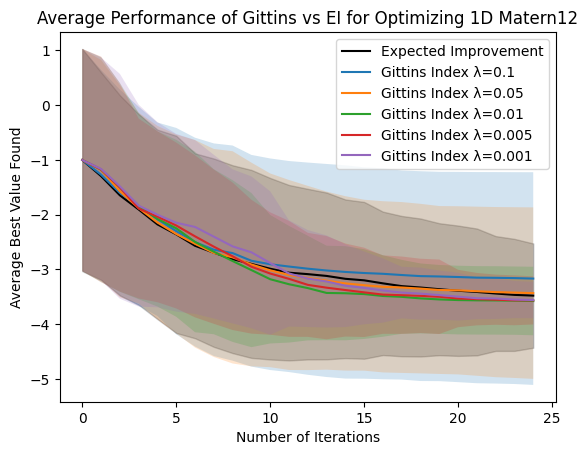

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate average and standard deviation
def calculate_avg_and_std(histories):
    # Convert list of lists to numpy array for easier calculations
    histories_array = np.array(histories)
    avg_performance = np.mean(histories_array, axis=0)
    std_performance = np.std(histories_array, axis=0)
    return avg_performance, std_performance

# Calculate average and standard deviation for EI
EI_avg_performance, EI_std_performance = calculate_avg_and_std(EI_best_histories)

# Plotting for EI
plt.plot(range(num_iterations+1), EI_avg_performance, label='Expected Improvement', color='black')
plt.fill_between(range(num_iterations+1), EI_avg_performance - 1.96 * EI_std_performance, EI_avg_performance + 1.96 * EI_std_performance, color='black', alpha=0.2)

# Calculate and plot for each λ in GI
for lmbda in lmbda_values:
    GI_avg_performance, GI_std_performance = calculate_avg_and_std(GI_best_histories[lmbda])

    plt.plot(range(num_iterations+1), GI_avg_performance, label=f'Gittins Index λ={lmbda}')
    plt.fill_between(range(num_iterations+1), GI_avg_performance - 1.96 * GI_std_performance, GI_avg_performance + 1.96 * GI_std_performance, alpha=0.2)

# Customize plot
plt.xlabel('Number of Iterations')
plt.ylabel('Average Best Value Found')
plt.title("Average Performance of Gittins vs EI for Optimizing 1D Matern12")
plt.legend()
plt.show()

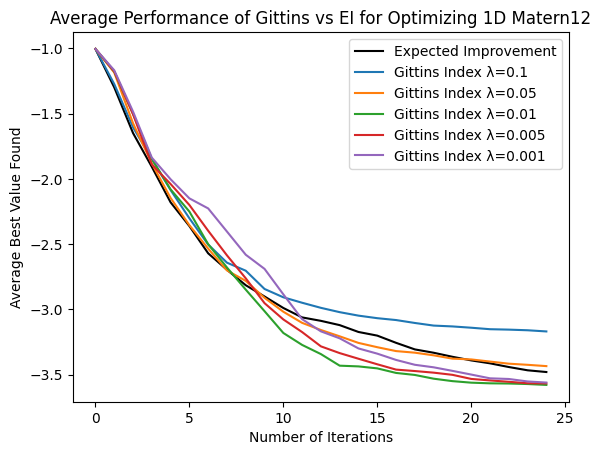

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate average and standard deviation
def calculate_avg_and_std(histories):
    # Convert list of lists to numpy array for easier calculations
    histories_array = np.array(histories)
    avg_performance = np.mean(histories_array, axis=0)
    std_performance = np.std(histories_array, axis=0)
    return avg_performance, std_performance

# Calculate average and standard deviation for EI
EI_avg_performance, EI_std_performance = calculate_avg_and_std(EI_best_histories)

# Plotting for EI
plt.plot(range(num_iterations+1), EI_avg_performance, label='Expected Improvement', color='black')
# plt.fill_between(range(num_iterations+1), EI_avg_performance - 1.96 * EI_std_performance, EI_avg_performance + 1.96 * EI_std_performance, color='black', alpha=0.2)

# Calculate and plot for each λ in GI
for lmbda in lmbda_values:
    GI_avg_performance, GI_std_performance = calculate_avg_and_std(GI_best_histories[lmbda])

    plt.plot(range(num_iterations+1), GI_avg_performance, label=f'Gittins Index λ={lmbda}')
#     plt.fill_between(range(num_iterations+1), GI_avg_performance - 1.96 * GI_std_performance, GI_avg_performance + 1.96 * GI_std_performance, alpha=0.2)

# Customize plot
plt.xlabel('Number of Iterations')
plt.ylabel('Average Best Value Found')
plt.title("Average Performance of Gittins vs EI for Optimizing 1D Matern12")
plt.legend()
plt.show()

In [ ]:
import json

# Open a file and write the string to it
with open('EI best (Matern12).txt', 'w') as file:
    file.write(json.dumps(EI_best_histories, indent=4))
    
with open('GI best (Matern12).txt', 'w') as file:
    file.write(json.dumps(GI_best_histories, indent=4))